# Evolving Neural Networks - Genetic Algorithm Approach
### Inspired by <a href='https://arxiv.org/abs/2004.02967'>Liu, Hanxiao, et al. "Evolving normalization-activation layers." Advances in Neural Information Processing Systems 33 (2020): 13539-13550</a>


In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import uuid
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations
from IPython.display import display

In [ ]:
# Run on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Architecture search space
We will define the architecture search space for the parameters of the network architectures to consider.

In [ ]:
ss_conv_layers = [2, 3, 4, 5] # Number of layers
ss_conv_filters = [16, 32, 64, 128] # Number of filters in conv layers
ss_kernel_size = [3, 5] # Kernel sizes
ss_activation = ['relu', 'sigmoid', 'leaky_relu'] # Activation functions
ss_pooling = [None, 'max', 'avg'] # Pooling layers

## Functions

### generate_architecture

Generate an architecture based on the search space:

In [ ]:
def generate_architecture(inp_shape = (1, 28, 28), out_features = 128):
    """Generate architecture specification"""
    num_conv_layers = random.choice(ss_conv_layers)

    conv_layers = []
    for _ in range(num_conv_layers):
        conv_layers.append({
            'out_channels': random.choice(ss_conv_filters),
            'kernel_size': random.choice(ss_kernel_size),
            'padding': None,  # Will be set based on kernel_size
            'activation': random.choice(ss_activation),
            'pooling': {
                'type': 'max',
                'size': 2
            }
        })
        # Set padding based on kernel_size
        conv_layers[-1]['padding'] = conv_layers[-1]['kernel_size'] // 2

    return {
        'input_shape': inp_shape, # TBD - dynamic; needed to accommodate CIFAR
        'conv_layers': conv_layers,
        'fc_layers': [
            {
                'out_features': out_features,
                'activation': 'relu'
            },
            {
                'out_features': output_categories,
                'activation': None
            }
        ]
    }

### NN

Build a model based on architecture:

In [ ]:
class NN(nn.Module):
    def __init__(self, architecture, input_height, input_width):
        super(NN, self).__init__()
        self.architecture = architecture
        self._id = uuid.uuid4()
        self.parent_ids = []
        self.fitness_score = 0
        self._viable = True

        # Build NN based on architecture
        try:
            # Get input dimensions
            input_channels, input_height, input_width = architecture['input_shape']

            # Initialize dimension tracking
            current_channels = input_channels
            current_height = input_height
            current_width = input_width

            # Add convolutional layers
            self.conv_layers = nn.ModuleList()
            for i, layer_config in enumerate(architecture['conv_layers']):
                conv = nn.Conv2d(
                    in_channels=current_channels,
                    out_channels=layer_config['out_channels'],
                    kernel_size=layer_config['kernel_size'],
                    padding=layer_config['padding']
                )
                self.conv_layers.append(conv)

                # Calculate dimensions after convolution
                kernel_size = layer_config['kernel_size']
                padding = layer_config['padding']
                stride = 1
                current_height = ((current_height + 2*padding - kernel_size) // stride) + 1
                current_width = ((current_width + 2*padding - kernel_size) // stride) + 1

                # Update dimensions
                current_channels = layer_config['out_channels']

                # Add activation
                if layer_config['activation'] == 'relu':
                    self.conv_layers.append(nn.ReLU())
                elif layer_config['activation'] == 'leaky_relu':
                    self.conv_layers.append(nn.LeakyReLU())
                elif layer_config['activation'] == 'sigmoid':
                    self.conv_layers.append(nn.Sigmoid())

                # Add pooling
                if layer_config['pooling'] and current_height >= 2 and current_width >= 2:
                    if layer_config['pooling']['type'] == 'max':
                        self.conv_layers.append(nn.MaxPool2d(layer_config['pooling']['size']))
                        current_height //= layer_config['pooling']['size']
                        current_width //= layer_config['pooling']['size']

            # Calculate flattened size for FC layers
            self.flattened_size = current_channels * current_height * current_width

            # Add fully connected layers
            self.fc_layers = nn.ModuleList()

            # Add flattened layer
            self.fc_layers.append(nn.Flatten())

            # Add FC layers
            current_features = self.flattened_size
            for layer_config in architecture['fc_layers']:
                # Linear layer
                fc = nn.Linear(current_features, layer_config['out_features'])
                self.fc_layers.append(fc)
                current_features = layer_config['out_features']

                # Activation
                if layer_config['activation'] == 'relu':
                    self.fc_layers.append(nn.ReLU())
                elif layer_config['activation'] == 'leaky_relu':
                    self.fc_layers.append(nn.LeakyReLU())
                elif layer_config['activation'] == 'sigmoid':
                    self.fc_layers.append(nn.Sigmoid())

            # Test forward pass
            with torch.no_grad():
                test_input = torch.randn(batch_size, *architecture['input_shape'])
                test_output = self.forward(test_input)
                if test_output.shape != (batch_size, output_categories):
                    raise ValueError(f"from NN: Invalid output shape: {test_output.shape}")

        except Exception as e:
            print(f"{self._id}: Error creating network: {str(e)}")
            self._viable = False

    def forward(self, x):
        if not self._viable:
            raise RuntimeError('from NN: Network is not viable')

        # Pass through conv layers
        for layer in self.conv_layers:
            x = layer(x)

        # Pass through fc layers
        for layer in self.fc_layers:
            x = layer(x)

        return x

    @property
    def viable(self):
        return self._viable

    @property
    def network_architecture(self):
        """Returns a detailed description of the NN architecture"""
        if not self._viable:
            return "from NN: Non-viable NN"

        info = [f"NN (ID: {self._id})",
                f"Parent IDs: {self.parent_ids}",
                f"Fitness score: {self.fitness_score}\n",
                "Architecture:"]

        for name, module in self.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear, nn.ReLU, nn.LeakyReLU, nn.MaxPool2d, nn.Flatten)):
                indent = '  ' * (len(name.split('.')) - 1)
                info.append(f"{indent}{module}")

        total_params = sum(p.numel() for p in self.parameters())
        info.append(f"\nTotal parameters: {total_params:,}")

        return '\n'.join(info)

    def __str__(self):
        return self.network_architecture


### evaluate_fitness

Fitness function, to be used in selecting the best-performing architectures

Uses:
* Adam optimizer
* Cross-entropy loss as a fitness criterion

In [ ]:
def evaluate_fitness(model, train_loader, test_loader, num_epochs, num_batches=50):
    """Train and evaluate model fitness"""
    if not model.viable:
        return float('-inf')

    # Training phase
    model.train()
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # Quick training
    for epoch in range(num_epochs):
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if batch_idx >= num_batches:
                break

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluation phase
    model.eval()
    correct = 0
    total = 0

    try:
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):  # Use test_loader for evaluation
                if batch_idx >= num_batches:
                    break

                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        accuracy = 100. * correct / total
        return accuracy

    except Exception as e:
        print(f"Error during fitness evaluation: {str(e)}")
        return float('-inf')

### roulette_wheel_select

Select the candidates for the next generation based on the Roulette-wheel selection algorithm proposed in <a href="https://www.sciencedirect.com/science/article/abs/pii/S0378437111009010">Lipowski, Adam, and Dorota Lipowska. "Roulette-wheel selection via stochastic acceptance." Physica A: Statistical Mechanics and its Applications 391.6 (2012): 2193-2196</a>

In [ ]:
def roulette_wheel_select(population, num_selections):
    # Find maximum fitness to normalize probabilities
    max_fitness = max(ind.fitness_score for ind in population)

    selected = []
    for _ in range(num_selections):
        while True:

            # Pick a random individual
            candidate = random.choice(population)

            # Generate random number between 0 and 1
            r = random.random()

            # Accept with probability = fitness/max_fitness
            if r <= candidate.fitness_score/max_fitness:
                selected.append(candidate)
                break

    return selected

### evolve



In [ ]:
def evolve(num_generations,
           train_loader,
           test_loader,
           in_population,
           num_top_surv,
           mutation_rate,
           crossover_type,
           num_epochs,
           selection_method):
    '''Evolve population'''
    population_size = len(in_population)
    curr_population = in_population.copy()
    df_res = pd.DataFrame(columns=['ID', 'ParentIDs', 'Fitness', 'Generation'])

    for generation in range(num_generations):

        gen_num = generation + 1

        print(f'\nEvolving gen {gen_num} ---------------------------------')

        # 1: Evaluate fitness and assign to each individual
        for ind in curr_population:
            ind.fitness_score = evaluate_fitness(ind, train_loader, test_loader, num_epochs)
            print(f'\nIndividual {ind._id}: {ind.fitness_score}')

        # 2: Choose the survivors based on the selected method
        match selection_method.lower():
            case 'elitist':
                top_population = sorted(curr_population, key=lambda x: x.fitness_score, reverse=True)[:num_top_surv]
                curr_population = top_population.copy()
            case 'roulette':
                top_population = roulette_wheel_select(curr_population, num_top_surv)
                curr_population = top_population.copy()
            case _:
                raise ValueError(f"\nfrom evolve: Invalid value for selection_method: {selection_method}\n")

        print(f"\n\nThe {num_top_surv} survivors:")
        for ind in curr_population:
            print(f"\nID: {ind._id}, Fitness: {ind.fitness_score:.3f}")
            print(f'Architecture: {ind.network_architecture}')

        #3: Apply crossover and mutation to generate new generation
        while len(curr_population) < population_size:
            parent1, parent2 = random.choices(top_population, k=2)

            print(f'Applying crossover to {parent1._id} and {parent2._id}')

            if crossover_type == 'simple':
                child_architecture = crossover_simple(parent1.architecture, parent2.architecture)
            else:
                child_architecture = crossover_layer_exchange(parent1.architecture, parent2.architecture)

            child_architecture = mutate(child_architecture, mutation_rate)
            child = NN(child_architecture, input_height, input_width)
            child.parent_ids = [parent1._id, parent2._id]  # Add parent IDs
            curr_population.append(child)

            print('Child:', child)

        print(f"\n\nGeneration {generation + 1} : Results ------------------------------")
        for ind in curr_population:
            #print(f"   ID: {ind._id}, Parent IDs: {ind.parent_ids}, Fitness: {ind.fitness_score}")
            df_res.loc[len(df_res)] = {
                    'ID': str(ind._id),
                    'ParentIDs': str(ind.parent_ids),
                    'Fitness': ind.fitness_score,
                    'Generation': gen_num
                    }

        display(df_res[df_res['Generation'] == gen_num])

    return df_res

## Genetic Algorithm operations

The GA will have three operations:

* **Selection**  
  Selecting the most fit individuals using *elitism*: k best performing individuals will survive  
  Will be implemented using the fitness function.
  
  **TBD**: implement roulette wheel (random selection based on fitness probability)
  

* **Crossover**  
  Mixing parts of the "parent" architectures - number of filters, kernel size, etc.

* **Mutation**  
  Random modification of an individual.

In [ ]:
# Helper functions
def is_conv_layer(layer):
    """Check if a layer is a convolutional layer"""
    return isinstance(layer, dict) and 'out_channels' in layer and 'kernel_size' in layer


def calculate_output_shape(input_shape, layer):
    """Calculate output shape after any type of layer"""
    channels, height, width = input_shape

    # Handle conv layers
    if is_conv_layer(layer):
        out_channels = layer['out_channels']
        kernel_size = layer['kernel_size']
        stride = layer.get('stride', 1)
        padding = layer['padding']

        # Calculate output dimensions
        h_out = ((height + 2 * padding - kernel_size) // stride) + 1
        w_out = ((width + 2 * padding - kernel_size) // stride) + 1
        return (out_channels, h_out, w_out)

    # Handle pooling layers
    if 'pooling' in layer and layer['pooling']:
        pool_size = layer['pooling']['size']
        return (channels, height // pool_size, width // pool_size)

    # For all other layers (activation, etc.), return input shape unchanged
    return (channels, height, width)


def make_layers_compatible(layer1, layer2, input_shape):
    """Try to make layer2 compatible with layer1's output by adjusting its parameters"""
    # Only process if both are conv layers
    if not is_conv_layer(layer1) or not is_conv_layer(layer2):
        return layer2, False

    # Get output shape from layer1
    output_shape = calculate_output_shape(input_shape, layer1)

    # Try different kernel sizes and paddings
    for kernel_size in [3, 5]:
        for padding in range(3):
            test_layer = layer2.copy()
            test_layer['kernel_size'] = kernel_size
            test_layer['padding'] = padding

            try:
                next_shape = calculate_output_shape(output_shape, test_layer)
                if all(dim > 0 for dim in next_shape):
                    return test_layer, True
            except:
                continue

    return layer2, False

In [ ]:
def crossover_simple(parent1, parent2):
     """Perform crossover by choosing all layers from one parent"""
     # Randomly choose which parent to take layers from
     parent = random.choice([parent1, parent2])

     # Create child with exact copy of chosen parent's architecture
     child = {
         'input_shape': parent['input_shape'],
         'conv_layers': [layer.copy() for layer in parent['conv_layers']],  # Deep copy of layers
         'fc_layers': parent['fc_layers']
     }

     return child


def crossover_layer_exchange(parent1, parent2):
    """Perform crossover with layer dropping and adding"""

    print(f' performing crossover...')

    # Start with parent1's layers
    child = {
        'input_shape': parent1['input_shape'],
        'conv_layers': [layer.copy() for layer in parent1['conv_layers']],
        'fc_layers': parent1['fc_layers'].copy()
    }

    # Calculate number of layers to potentially modify
    conv_layers_count = len(child['conv_layers'])
    max_layers_to_modify = max(1, conv_layers_count // 3)

    print(f'will modify up to {max_layers_to_modify} layers')

    # Randomly choose number of layers to drop
    num_layers_to_drop = random.randint(1, max_layers_to_modify)

    print(f'will drop {num_layers_to_drop} layers')

    # Drop random layers (except last few layers before flatten)
    droppable_indices = list(range(conv_layers_count - 3))  # Keep last few layers
    if droppable_indices:
        drop_indices = sorted(random.sample(droppable_indices,
                                          min(num_layers_to_drop, len(droppable_indices))),
                            reverse=True)

        for idx in drop_indices:
            child['conv_layers'].pop(idx)

    # Choose layers from parent2 to add
    num_layers_to_add = random.randint(1, max_layers_to_modify)

    print(f'will add {num_layers_to_add} layers')

    available_parent2_layers = [layer.copy() for layer in parent2['conv_layers'][:-3]]  # Exclude last few layers

    if available_parent2_layers:
        layers_to_add = random.sample(available_parent2_layers,
                                    min(num_layers_to_add, len(available_parent2_layers)))

        # Try to add each layer at random positions
        current_shape = parent1['input_shape']

        for layer in layers_to_add:
            # Find a valid position for this layer
            valid_positions = []
            temp_layers = child['conv_layers'].copy()

            for insert_pos in range(len(temp_layers)):
                # Try inserting at this position
                test_layers = temp_layers.copy()
                compatible_layer, is_compatible = make_layers_compatible(
                    test_layers[insert_pos-1] if insert_pos > 0 else {'out_channels': 1},
                    layer,
                    current_shape
                )

                if is_compatible:
                    valid_positions.append((insert_pos, compatible_layer))

            if valid_positions:
                # Choose a random valid position
                pos, compatible_layer = random.choice(valid_positions)
                child['conv_layers'].insert(pos, compatible_layer)

    # Recalculate final conv layer output shape for FC layer
    current_shape = list(parent1['input_shape'])
    for layer in child['conv_layers']:
        current_shape = list(calculate_output_shape(current_shape, layer))

    # Update first FC layer input features
    flattened_size = current_shape[0] * current_shape[1] * current_shape[2]
    child['fc_layers'][0]['in_features'] = flattened_size

    print(f'child after crossover: {child}\n\n')

    return child


def mutate(individual, mutation_rate):
    """Mutate architecture while tracking and maintaining valid dimensions"""
    mutated = {
        'input_shape': individual['input_shape'],
        'conv_layers': [],
        'fc_layers': individual['fc_layers']
    }

    # Track dimensions
    current_channels = individual['input_shape'][0]  # Start with input channels (1)
    current_height = individual['input_shape'][1]    # Start with input height (28)
    current_width = individual['input_shape'][2]     # Start with input width (28)

    for layer in individual['conv_layers']:
        mutated_layer = layer.copy()

        # Track dimensions before mutation
        #print(f"Before mutation: {current_height}x{current_width}, channels: {current_channels}")

        # Mutate out_channels (number of filters)
        if random.random() < mutation_rate:
            mutated_layer['out_channels'] = random.choice(ss_conv_filters)
        current_channels = mutated_layer['out_channels']

        # Mutate kernel_size and padding
        if random.random() < mutation_rate:
            mutated_layer['kernel_size'] = random.choice(ss_kernel_size)
            mutated_layer['padding'] = mutated_layer['kernel_size'] // 2

        # Mutate activation
        if random.random() < mutation_rate:
            mutated_layer['activation'] = random.choice(ss_activation)

        # Mutate pooling only if dimensions allow it
        if random.random() < mutation_rate and current_height >= 4 and current_width >= 4:
            pool_type = random.choice(ss_pooling)
            if pool_type:  # if not None
                mutated_layer['pooling'] = {
                    'type': pool_type,
                    'size': 2
                }
                current_height //= 2
                current_width //= 2
            else:
                mutated_layer['pooling'] = None
        elif mutated_layer['pooling']:  # If keeping existing pooling
            current_height //= 2
            current_width //= 2

        #print(f"After mutation: {current_height}x{current_width}, channels: {current_channels}")

        # Verify dimensions are still valid
        if current_height < 1 or current_width < 1:
            print(f"- - - - - From mutation funciton: Invalid dimensions, reverting pooling")
            mutated_layer['pooling'] = None
            current_height *= 2
            current_width *= 2

        mutated['conv_layers'].append(mutated_layer)

    return mutated

## Visualization and statistical functions

In [ ]:
def visualize_method_x_crossover(df, gen, selection_methods, crossover_methods):
    '''Visualize Method x Crossover box plot and print stats for each combination'''
    plt.figure(figsize=(10, 6))
    min_fitness = curr_df['Fitness'].min()
    max_fitness = curr_df['Fitness'].max()
    plt.ylim(min_fitness - 2, max_fitness + 5)  # Make room for labels

    ax = sns.boxplot(data=curr_df,
                    x='Method',
                    y='Fitness',
                    hue='Crossover Type',
                    width = 0.5)

    plt.legend(bbox_to_anchor=(0, 0), loc='lower left')

    for i, method in enumerate(selection_methods):
        for j, crossover in enumerate(crossover_methods):
            data = df[(df['Method'] == method) &
                          (df['Crossover Type'] == crossover)]['Fitness']

            # Calculate stats
            max_val = data.max()
            mean = data.mean()
            median = data.median()
            std = data.std()

            # Position for the text
            x = i + (j-0.5)*0.5

            # Alternate between left and right placement
            halign = 'left' if j == 0 else 'right'
            xoffset = -0.1 if j == 0 else 0.1

            # Add text annotations
            ax.text(x, max_fitness + 2,
                    f'Max={max_val:.1f}\nMean={mean:.1f}\nMedian={median:.1f}\nStD={std:.1f}',
                    horizontalalignment=halign,
                    verticalalignment='center',
                    fontsize=9)

    plt.title(f'Fitness Distribution in Generation {gen} by Selection Method and Crossover Type')
    plt.ylabel('Fitness Score')
    plt.xlabel('Selection Method')

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    plt.show()

    summary = df.groupby(['Method', 'Crossover Type'])['Fitness'].agg([
        'mean', 'std', 'min', 'max'
    ]).round(2)
    print("\nNumerical Summary for Generation 5 (excluding zero fitness):")
    print(summary)

In [ ]:
def plot_heatmap_pairwise_mannwhitney(df, groups):
    '''Perform Pairwise Mann-Whitney U test with Bonferroni correction and plot a heatmap'''

    # Create empty matrix for adjusted p-values
    n = len(groups)

    # Calculate number of comparisons for Bonferroni correction
    n_comparisons = (n * (n-1)) // 2

    p_values_adjusted = np.zeros((n, n))

    # Set diagonal to NaN instead of 1 to make it gray without numbers
    for i in range(n):
        p_values_adjusted[i, i] = np.nan

    # Calculate adjusted p-values for each pair
    for i, group1_name in enumerate(groups):
        for j, group2_name in enumerate(groups):
            if i < j:  # Only calculate for upper triangle
                method1, cross1 = group1_name.split('-')
                method2, cross2 = group2_name.split('-')

                group1 = df[(df['Method'] == method1) &
                                (df['Crossover Type'] == cross1)]['Fitness']
                group2 = df[(df['Method'] == method2) &
                                (df['Crossover Type'] == cross2)]['Fitness']

                stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                adjusted_p = min(p_value * n_comparisons, 1.0)  # Bonferroni correction

                p_values_adjusted[i, j] = adjusted_p
                p_values_adjusted[j, i] = adjusted_p  # Mirror

    # Create custom colors for the heatmap
    colors = []
    for i in range(256):
        if i/255 <= 0.1:  # p < 0.1
            colors.append([1, 0, 0, 1])  # Red
        else:
            # Grayscale from light to dark, but not completely black
            # Now the darkest color will be dark gray instead of black
            gray_val = max(0.3, 0.8 - (i/255 - 0.1) / 0.9 * 0.5)  # Minimum gray value is 0.3
            colors.append([gray_val, gray_val, gray_val, 1])
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

    # Create figure
    plt.figure(figsize=(10, 8))

    # Create heatmap
    ax = sns.heatmap(p_values_adjusted,
                    annot=False,  # We'll add annotations manually
                    cmap=custom_cmap,
                    xticklabels=groups,
                    yticklabels=groups,
                    vmin=0,
                    vmax=1,
                    cbar_kws={'label': 'Bonferroni-adjusted p-value'})

    # Add text annotations manually
    for i in range(len(groups)):
        for j in range(len(groups)):
            if not np.isnan(p_values_adjusted[i, j]):  # Skip diagonal
                color = 'yellow' if p_values_adjusted[i, j] <= 0.1 else 'white'
                text = f'{p_values_adjusted[i, j]:.3f}'
                text_size = 16 if p_values_adjusted[i, j] <= 0.1 else 14
                ax.text(j + 0.5, i + 0.5, text,
                      ha='center', va='center',
                      color=color,
                      fontsize=text_size)

    plt.title('Pairwise Mann-Whitney U test\n(Bonferroni-adjusted p-values)')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_gen_values(df, gen, colors):
    '''Plot values for each method & crossover group, e.g., elitist simple, in a given generation'''
    # Get min and max fitness
    min_fitness = df['Fitness'].min()
    max_fitness = 100

    # Create figure
    plt.figure(figsize=(8, 8))

    # Process each group
    for i, (method, crossover) in enumerate(groups):
        # Get data for this group
        mask = (df['Method'] == method) & (df['Crossover Type'] == crossover)
        values = sorted(df[mask]['Fitness'].values, reverse=True)

        # Plot circles
        for j, value in enumerate(values):
            plt.scatter(i, value, c=colors[(method, crossover)], s=50)

            # For first value (highest), put text to the left of circle
            # For others, stack them vertically
            if j == 0:
                y_text = value
            else:
                # Calculate position based on the previous values to avoid overlap
                y_text = values[0] - (j * 1)  # vertical spacing

            plt.text(i-0.1, y_text, f'{value:.1f}',
                    verticalalignment='center',
                    horizontalalignment='right',
                    fontsize=10,
                    color=colors[(method, crossover)])

    # Customize plot
    plt.xlim(-0.5, 3.5)
    plt.xticks(range(len(groups)), [f'{method}\n{crossover}' for method, crossover in groups])
    plt.ylim(min_fitness - 2, max_fitness)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.title(f'Distribution of Non-Zero Fitness Values in Generation {gen}')
    plt.ylabel('Fitness Score')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_evo_paths(df):
    '''Plot evolution paths for each ID over generations'''
    # Create a 2x2 subplot grid for each combination of Method and Crossover Type
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Fitness Evolution by ID', fontsize=16)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Get max generation number
    max_gen = df['Generation'].max()

    # Counter for subplot
    i = 0

    # For each combination of Method and Crossover Type
    for method in df['Method'].unique():
        for crossover in df['Crossover Type'].unique():
            # Filter data for this combination
            mask = (df['Method'] == method) & (df['Crossover Type'] == crossover)
            subset = df[mask]

            # Dictionary to keep track of label positions for each x-coordinate
            label_positions = {}

            # Plot lines for each ID in this combination
            for id in subset['ID'].unique():
                id_data = subset[subset['ID'] == id].sort_values('Generation')

                # Get a color for this line from the default color cycle
                line = axes[i].plot(id_data['Generation'], id_data['Fitness'], marker='o')[0]
                color = line.get_color()

                # Add data labels for non-zero fitness values
                for x, y in zip(id_data['Generation'], id_data['Fitness']):
                    if y > 0:  # Only label non-zero values
                        # Initialize list for this x if not exists
                        if x not in label_positions:
                            label_positions[x] = []

                        # Add this label's y-value to the list
                        label_positions[x].append((y, color))

            # Now add labels with proper offsets
            for x in label_positions:
                # Sort labels for this x-coordinate by y-value
                labels = sorted(label_positions[x], reverse=True)

                # Add labels with increasing offset
                for idx, (y, color) in enumerate(labels):
                    offset = -15 - (idx * 15)  # Increase offset for each label
                    axes[i].annotate(f'{y:.1f}',
                                  xy=(x, y),
                                  xytext=(0, offset),
                                  textcoords='offset points',
                                  fontsize=8,
                                  color=color,
                                  horizontalalignment='center',
                                  bbox=dict(facecolor='white',
                                          alpha=0.7,  # Transparency level
                                          edgecolor='none',
                                          pad=1))  # Padding around text

            axes[i].set_xlabel('Generation')
            axes[i].set_ylabel('Fitness Score')
            axes[i].set_title(f'{method} - {crossover}')
            axes[i].grid(True, linestyle='--', alpha=0.7)
            axes[i].set_xticks(range(1, int(max_gen) + 1))

            i += 1

    plt.tight_layout()
    plt.show()

# Experiments

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## 1. Experiment with MNIST

In [ ]:
from torchvision.datasets import MNIST

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [ ]:
#Evolutionaty process characteristics
population_size = 15
num_generations = 5
mutation_rate = 0.1
num_top_surv = 8  # Top k individuals survive

In [ ]:
num_train_epochs = 3 # Each evolutionary model will be trained for a limited number of epochs
input_height = 28
input_width = 28

batch_size = 64
output_categories = 10

In [ ]:
inp_shape = (1, input_height, input_width)
first_fc_layer_out_features = 128

### Create population
The population of individuals to be considered for selection:

In [ ]:
population = []
while len(population) < population_size:
    entity = NN(generate_architecture(inp_shape=inp_shape, out_features=first_fc_layer_out_features), input_height=input_height, input_width=input_width)
    if entity._viable:
        population.append(entity)
    else:
        print(f'Entity {entity._id} is not viable:')
        print(ind.network_architecture)

print('\n\nPopulation:')
for ind in population:
    print('\n')
    print('-' * 50)
    print(ind.network_architecture)  # This will print everything
    print('-' * 50)



Population:


--------------------------------------------------
NN (ID: f4daad79-6799-48f8-8ec5-79ef33fa5b6f)
Parent IDs: []
Fitness score: 0

Architecture:
  Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  ReLU()
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  ReLU()
  Flatten(start_dim=1, end_dim=-1)
  Linear(in_features=128, out_featur

First, we will try different selection methods and determine which one leads to the growth of accuracy over evolved generations.

### Try different selection methods with and without crossover

Evolve networks to recognize digits in MNIST.

Try:
- Elitist (top n performers) and Roulette (Roulette-wheel selection via stochastic acceptance)
- Without Crossover (simple) and With Crossover (layers)

In [ ]:
methods = ['elitist', 'roulette']
crossover_types = ['simple', 'layers']

all_dfs = []

for m in methods:
    for ct in crossover_types:
        print(f'\n\nSelection method: {m}, Crossover type: {ct}\n')
        population0 = population.copy()
        df0 = evolve(num_generations, train_loader, test_loader,
                     population0,
                     num_top_surv, mutation_rate,
                     crossover_type=ct,
                     num_epochs=num_train_epochs,
                     selection_method=m)
        df0['Method'] = m
        df0['Crossover Type'] = ct
        all_dfs.append(df0)

# Combine all DataFrames
comb_df = pd.concat(all_dfs, ignore_index=True)
comb_df



Selection method: elitist, Crossover type: simple


Evolving gen 1 ---------------------------------

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 93.71875

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 94.5

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 93.4375

Individual da3085e0-ee90-445d-9707-e08753dcbc89: 11.25

Individual bf64e4d2-7749-4d3a-998e-562cd396ec10: 67.34375

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 94.3125

Individual 6d155b05-9eb6-4307-9836-ef14c14aa5c7: 83.15625

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 82.84375

Individual 14097f74-62a6-435f-8e9b-1e1c78d3bafa: 81.59375

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 93.46875

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 90.9375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 92.25

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 82.6875

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 93.1875

Individual 9327eab7-31b9-45a8-a699-cac9a46ede30: 41.71875


The 8 survivors:

ID: 5e2

ID  \
0   5e22c700-48f9-493e-8e88-bf400a0f9cef   
1   48dbedcc-0e1b-49ac-81a2-a4a536a332af   
2   f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
3   3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
4   7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
5   abde9bca-7b6e-446d-8cb3-d64d25234e92   
6   e0693066-f7c6-4896-bd8a-c74294f4b46b   
7   f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
8   78f7b781-45f3-4483-99b9-4b024a4efa8d   
9   ee1d993a-032e-4b17-9639-ecbbd480c252   
10  412002ad-a575-40ed-b56c-dbdb388b31da   
11  ff225b90-e454-4aee-9843-84ed918e3343   
12  f58538a7-76ec-4850-9696-892693d09f15   
13  898173f0-eeb8-404e-a5ec-262adec350ca   
14  e5619a58-cbb2-494f-beb0-f770eefdeab6   

                                            ParentIDs   Fitness  Generation  
0                                                  []  94.50000           1  
1                                                  []  94.31250           1  
2                                                  []  93.71875           1  
3                                                  []  93.46875           1  
4                                                  []  93.43750           1  
5                                                  []  93.18750           1  
6                                                  []  92.25000           1  
7                                                  []  90.93750           1  
8   [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           1  
9   [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           1  
10  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           1  
11  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           1  
12  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...   0.00000           1  
13  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           1  
14  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 95.34375

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 96.8125

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 94.8125

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 95.1875

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 96.3125

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 96.34375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 95.71875

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 94.96875

Individual 78f7b781-45f3-4483-99b9-4b024a4efa8d: 88.40625

Individual ee1d993a-032e-4b17-9639-ecbbd480c252: 87.1875

Individual 412002ad-a575-40ed-b56c-dbdb388b31da: 94.59375

Individual ff225b90-e454-4aee-9843-84ed918e3343: 91.6875

Individual f58538a7-76ec-4850-9696-892693d09f15: 94.875

Individual 898173f0-eeb8-404e-a5ec-262adec350ca: 92.46875

Individual e5619a58-cbb2-494f-beb0-f770eefdeab6: 92.40625


The 8 survivors:

ID: 48dbedcc-0e1b-49ac-81a2-a4a536a332af, Fitness: 96

ID  \
15  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
16  abde9bca-7b6e-446d-8cb3-d64d25234e92   
17  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
18  e0693066-f7c6-4896-bd8a-c74294f4b46b   
19  5e22c700-48f9-493e-8e88-bf400a0f9cef   
20  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
21  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
22  f58538a7-76ec-4850-9696-892693d09f15   
23  73100178-2262-4b21-8d6e-e93358670ed3   
24  a5fdad52-f36f-40b9-b286-e870c3489e37   
25  7c7967d7-9ef0-4e0a-ab7c-273dba219e95   
26  2d3dd10d-d386-4d75-9bc6-866b54050e85   
27  2dd7cb15-8862-4ac1-a40e-3eeb5529d498   
28  2a3d8efd-a820-40b0-a0c0-38f66be6157c   
29  02c083a9-6d1e-43d2-8c5e-d1605e069881   

                                            ParentIDs   Fitness  Generation  
15                                                 []  96.81250           2  
16                                                 []  96.34375           2  
17                                                 []  96.31250           2  
18                                                 []  95.71875           2  
19                                                 []  95.34375           2  
20                                                 []  95.18750           2  
21                                                 []  94.96875           2  
22  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...  94.87500           2  
23  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           2  
24  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           2  
25  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           2  
26  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           2  
27  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           2  
28  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           2  
29  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 97.21875

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 96.09375

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 97.34375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 95.71875

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 96.90625

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.625

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 96.5

Individual f58538a7-76ec-4850-9696-892693d09f15: 96.71875

Individual 73100178-2262-4b21-8d6e-e93358670ed3: 93.21875

Individual a5fdad52-f36f-40b9-b286-e870c3489e37: 92.96875

Individual 7c7967d7-9ef0-4e0a-ab7c-273dba219e95: 94.25

Individual 2d3dd10d-d386-4d75-9bc6-866b54050e85: 94.625

Individual 2dd7cb15-8862-4ac1-a40e-3eeb5529d498: 91.25

Individual 2a3d8efd-a820-40b0-a0c0-38f66be6157c: 93.6875

Individual 02c083a9-6d1e-43d2-8c5e-d1605e069881: 92.6875


The 8 survivors:

ID: 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7, Fitness: 97.625
Arc

ID  \
30  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
31  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
32  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
33  5e22c700-48f9-493e-8e88-bf400a0f9cef   
34  f58538a7-76ec-4850-9696-892693d09f15   
35  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
36  abde9bca-7b6e-446d-8cb3-d64d25234e92   
37  e0693066-f7c6-4896-bd8a-c74294f4b46b   
38  06849ad3-2ce6-4801-b40b-ef5cb80566f3   
39  2a7cfd97-b87f-4275-a379-c7649dcf905f   
40  9312cf9e-8875-4ad1-a3f3-e7393064d82b   
41  2dd8a105-1472-4ab4-8a74-dc0a46387611   
42  63a0143f-28ef-4b1f-8bc8-aaeb1769197f   
43  a1b9089d-0dfc-459f-bed1-0ce612df4b94   
44  24b9f755-545e-4843-bb50-c742df7d5f6e   

                                            ParentIDs   Fitness  Generation  
30                                                 []  97.62500           3  
31                                                 []  97.34375           3  
32                                                 []  97.21875           3  
33                                                 []  96.90625           3  
34  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...  96.71875           3  
35                                                 []  96.50000           3  
36                                                 []  96.09375           3  
37                                                 []  95.71875           3  
38  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           3  
39  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           3  
40  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           3  
41  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           3  
42  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           3  
43  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...   0.00000           3  
44  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.53125

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 97.9375

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 96.8125

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 97.375

Individual f58538a7-76ec-4850-9696-892693d09f15: 96.375

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 96.21875

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 97.59375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 96.3125

Individual 06849ad3-2ce6-4801-b40b-ef5cb80566f3: 94.03125

Individual 2a7cfd97-b87f-4275-a379-c7649dcf905f: 93.78125

Individual 9312cf9e-8875-4ad1-a3f3-e7393064d82b: 92.8125

Individual 2dd8a105-1472-4ab4-8a74-dc0a46387611: 92.65625

Individual 63a0143f-28ef-4b1f-8bc8-aaeb1769197f: 89.21875

Individual a1b9089d-0dfc-459f-bed1-0ce612df4b94: 92.84375

Individual 24b9f755-545e-4843-bb50-c742df7d5f6e: 91.75


The 8 survivors:

ID: 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd, Fitness: 97.93

ID  \
45  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
46  abde9bca-7b6e-446d-8cb3-d64d25234e92   
47  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
48  5e22c700-48f9-493e-8e88-bf400a0f9cef   
49  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
50  f58538a7-76ec-4850-9696-892693d09f15   
51  e0693066-f7c6-4896-bd8a-c74294f4b46b   
52  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
53  084af661-8354-4335-9fb3-af276c3aaf0d   
54  8db20a97-a25b-44cc-b440-840d63022750   
55  e1ed98c4-d7ef-4a14-a2b0-b856b4c2f9b6   
56  09526b8c-6476-45fc-86b1-5bf0fd8191e1   
57  62e30e3b-db79-4e27-b034-ac680ce1347d   
58  3354001e-0f0f-4761-8bac-95483b228038   
59  a82cc243-e776-444f-a95b-3c8009b3ce4b   

                                            ParentIDs   Fitness  Generation  
45                                                 []  97.93750           4  
46                                                 []  97.59375           4  
47                                                 []  97.53125           4  
48                                                 []  97.37500           4  
49                                                 []  96.81250           4  
50  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...  96.37500           4  
51                                                 []  96.31250           4  
52                                                 []  96.21875           4  
53  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           4  
54  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           4  
55  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           4  
56  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           4  
57  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           4  
58  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           4  
59  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 97.9375

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 97.5625

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.375

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 97.96875

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 98.0

Individual f58538a7-76ec-4850-9696-892693d09f15: 97.34375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.375

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 96.5625

Individual 084af661-8354-4335-9fb3-af276c3aaf0d: 93.03125

Individual 8db20a97-a25b-44cc-b440-840d63022750: 93.0625

Individual e1ed98c4-d7ef-4a14-a2b0-b856b4c2f9b6: 92.84375

Individual 09526b8c-6476-45fc-86b1-5bf0fd8191e1: 95.03125

Individual 62e30e3b-db79-4e27-b034-ac680ce1347d: 85.875

Individual 3354001e-0f0f-4761-8bac-95483b228038: 95.15625

Individual a82cc243-e776-444f-a95b-3c8009b3ce4b: 92.6875


The 8 survivors:

ID: 48dbedcc-0e1b-49ac-81a2-a4a536a332af, Fitness: 98.000
Ar

ID  \
60  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
61  5e22c700-48f9-493e-8e88-bf400a0f9cef   
62  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
63  abde9bca-7b6e-446d-8cb3-d64d25234e92   
64  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
65  e0693066-f7c6-4896-bd8a-c74294f4b46b   
66  f58538a7-76ec-4850-9696-892693d09f15   
67  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
68  15e6f01c-aefe-4a02-9a6e-3a0489b96513   
69  b29cb165-9aa3-4129-9d4c-9bed7bb06097   
70  24f047c2-6f48-46c7-b31a-81668d84d585   
71  7b6de792-5b23-4658-8627-4395430729e8   
72  756dad89-e3d4-4bea-9982-a10d954c7683   
73  99f468c0-b6fc-46cc-a6c7-e5c11c54ee61   
74  35e49e6d-503c-4ab8-bd70-957ffb8e79e2   

                                            ParentIDs   Fitness  Generation  
60                                                 []  98.00000           5  
61                                                 []  97.96875           5  
62                                                 []  97.93750           5  
63                                                 []  97.56250           5  
64                                                 []  97.37500           5  
65                                                 []  97.37500           5  
66  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...  97.34375           5  
67                                                 []  96.56250           5  
68  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           5  
69  [UUID('f58538a7-76ec-4850-9696-892693d09f15'),...   0.00000           5  
70  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           5  
71  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           5  
72  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...   0.00000           5  
73  [UUID('f58538a7-76ec-4850-9696-892693d09f15'),...   0.00000           5  
74  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           5



Selection method: elitist, Crossover type: layers


Evolving gen 1 ---------------------------------

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 96.375

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 97.6875

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 97.21875

Individual da3085e0-ee90-445d-9707-e08753dcbc89: 11.25

Individual bf64e4d2-7749-4d3a-998e-562cd396ec10: 87.34375

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 97.78125

Individual 6d155b05-9eb6-4307-9836-ef14c14aa5c7: 87.96875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 92.71875

Individual 14097f74-62a6-435f-8e9b-1e1c78d3bafa: 91.0

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.21875

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 97.09375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.28125

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 87.84375

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 97.09375

Individual 9327eab7-31b9-45a8-a699-cac9a46ede30: 78.28125


The 8 survivors:

ID

ID  \
0   48dbedcc-0e1b-49ac-81a2-a4a536a332af   
1   5e22c700-48f9-493e-8e88-bf400a0f9cef   
2   e0693066-f7c6-4896-bd8a-c74294f4b46b   
3   7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
4   3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
5   f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
6   abde9bca-7b6e-446d-8cb3-d64d25234e92   
7   f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
8   e925c2e5-9ceb-40af-97fc-8d73fc96a1de   
9   fb058a0c-d15b-4fae-aebe-2a15b7d1b33a   
10  da848747-4b8a-4afd-8039-a5dc58b5bd91   
11  4010cc63-e1f1-4e4d-891c-bfb8411f0296   
12  092537d3-66ad-4ef3-9643-ce1dd165e8b0   
13  99ff8c0a-2ed1-4dff-81ea-454e066a18bd   
14  f8a91441-c081-46c0-813d-2d82b8a416fc   

                                            ParentIDs   Fitness  Generation  
0                                                  []  97.78125           1  
1                                                  []  97.68750           1  
2                                                  []  97.28125           1  
3                                                  []  97.21875           1  
4                                                  []  97.21875           1  
5                                                  []  97.09375           1  
6                                                  []  97.09375           1  
7                                                  []  96.37500           1  
8   [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           1  
9   [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           1  
10  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           1  
11  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           1  
12  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           1  
13  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           1  
14  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 98.0

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.25

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.78125

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 98.125

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.875

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 97.3125

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 98.21875

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 97.59375

Individual e925c2e5-9ceb-40af-97fc-8d73fc96a1de: 84.46875

Individual fb058a0c-d15b-4fae-aebe-2a15b7d1b33a: 91.53125

Individual da848747-4b8a-4afd-8039-a5dc58b5bd91: 94.59375

Individual 4010cc63-e1f1-4e4d-891c-bfb8411f0296: 94.28125

Individual 092537d3-66ad-4ef3-9643-ce1dd165e8b0: 85.8125

Individual 99ff8c0a-2ed1-4dff-81ea-454e066a18bd: 94.1875

Individual f8a91441-c081-46c0-813d-2d82b8a416fc: 88.0


The 8 survivors:

ID: 5e22c700-48f9-493e-8e88-bf400a0f9cef, Fitness: 98.250
Archi

ID  \
15  5e22c700-48f9-493e-8e88-bf400a0f9cef   
16  abde9bca-7b6e-446d-8cb3-d64d25234e92   
17  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
18  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
19  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
20  e0693066-f7c6-4896-bd8a-c74294f4b46b   
21  f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
22  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
23  7d046f9f-9329-4c7e-8f06-eb7ec8df23b4   
24  a4370936-6ade-48ef-aaef-a0a6bca96e88   
25  50bc14a9-4540-420d-8028-703ffa9dcd2d   
26  d2bd4906-afeb-4c81-8386-894047c41403   
27  7371567c-cfe8-432c-bab2-dda04323dd65   
28  e3af3f05-cd57-4a18-91b1-665f5e03a949   
29  6c26438c-a856-4f50-bd0c-2fb0c872781a   

                                            ParentIDs   Fitness  Generation  
15                                                 []  98.25000           2  
16                                                 []  98.21875           2  
17                                                 []  98.12500           2  
18                                                 []  98.00000           2  
19                                                 []  97.87500           2  
20                                                 []  97.78125           2  
21                                                 []  97.59375           2  
22                                                 []  97.31250           2  
23  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           2  
24  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           2  
25  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           2  
26  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           2  
27  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           2  
28  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           2  
29  [UUID('f4daad79-6799-48f8-8ec5-79ef33fa5b6f'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 97.875

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 97.59375

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 98.125

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 97.96875

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 98.375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 96.75

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 97.84375

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 97.96875

Individual 7d046f9f-9329-4c7e-8f06-eb7ec8df23b4: 91.78125

Individual a4370936-6ade-48ef-aaef-a0a6bca96e88: 88.03125

Individual 50bc14a9-4540-420d-8028-703ffa9dcd2d: 93.71875

Individual d2bd4906-afeb-4c81-8386-894047c41403: 84.59375

Individual 7371567c-cfe8-432c-bab2-dda04323dd65: 95.25

Individual e3af3f05-cd57-4a18-91b1-665f5e03a949: 95.21875

Individual 6c26438c-a856-4f50-bd0c-2fb0c872781a: 91.09375


The 8 survivors:

ID: 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7, Fitness: 98.375

ID  \
30  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
31  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
32  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
33  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
34  5e22c700-48f9-493e-8e88-bf400a0f9cef   
35  f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
36  abde9bca-7b6e-446d-8cb3-d64d25234e92   
37  e0693066-f7c6-4896-bd8a-c74294f4b46b   
38  d1dfb6c4-9071-4c2e-8549-4d8a36347712   
39  206b36bb-9c83-4f82-922a-9f53213fcffa   
40  dd2123fe-7e60-428e-9f46-f20aad17270f   
41  e6c92d6c-61da-4182-af6e-a4a7bf0c3c01   
42  4610e699-0370-425f-a12f-8085f277a8d4   
43  92a24175-63b4-4c8d-bcf6-d34ace7e8746   
44  d78c9e02-3da4-4d16-af03-655054fdf3b2   

                                            ParentIDs   Fitness  Generation  
30                                                 []  98.37500           3  
31                                                 []  98.12500           3  
32                                                 []  97.96875           3  
33                                                 []  97.96875           3  
34                                                 []  97.87500           3  
35                                                 []  97.84375           3  
36                                                 []  97.59375           3  
37                                                 []  96.75000           3  
38  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           3  
39  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           3  
40  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           3  
41  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           3  
42  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...   0.00000           3  
43  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           3  
44  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.3125

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 98.0

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 97.4375

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 98.03125

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 97.53125

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 96.75

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 98.34375

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.46875

Individual d1dfb6c4-9071-4c2e-8549-4d8a36347712: 92.125

Individual 206b36bb-9c83-4f82-922a-9f53213fcffa: 80.90625

Individual dd2123fe-7e60-428e-9f46-f20aad17270f: 81.15625

Individual e6c92d6c-61da-4182-af6e-a4a7bf0c3c01: 94.28125

Individual 4610e699-0370-425f-a12f-8085f277a8d4: 94.375

Individual 92a24175-63b4-4c8d-bcf6-d34ace7e8746: 93.21875

Individual d78c9e02-3da4-4d16-af03-655054fdf3b2: 10.34375


The 8 survivors:

ID: abde9bca-7b6e-446d-8cb3-d64d25234e92, Fitness: 98.344


ID  \
45  abde9bca-7b6e-446d-8cb3-d64d25234e92   
46  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
47  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
48  5e22c700-48f9-493e-8e88-bf400a0f9cef   
49  e0693066-f7c6-4896-bd8a-c74294f4b46b   
50  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
51  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
52  f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
53  620d7827-16fe-410b-a422-097f24957f25   
54  f1960480-4d3c-4682-a2ef-5c7829d58889   
55  c628f147-bce9-4536-80af-777beff81a21   
56  7be4fb14-843e-421a-8150-aea45e31e4c3   
57  3aec8ee7-4df1-4b9f-8e7e-0fd06f0239a5   
58  de8bf032-fc1e-4802-975a-44f7448ab72c   
59  6d96fbb0-f897-4435-9e28-aa1202e14753   

                                            ParentIDs   Fitness  Generation  
45                                                 []  98.34375           4  
46                                                 []  98.03125           4  
47                                                 []  98.00000           4  
48                                                 []  97.53125           4  
49                                                 []  97.46875           4  
50                                                 []  97.43750           4  
51                                                 []  97.31250           4  
52                                                 []  96.75000           4  
53  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           4  
54  [UUID('7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd'),...   0.00000           4  
55  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...   0.00000           4  
56  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           4  
57  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           4  
58  [UUID('f4daad79-6799-48f8-8ec5-79ef33fa5b6f'),...   0.00000           4  
59  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 98.28125

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 97.90625

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 98.3125

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.0625

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.21875

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 98.15625

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.875

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 96.9375

Individual 620d7827-16fe-410b-a422-097f24957f25: 94.96875

Individual f1960480-4d3c-4682-a2ef-5c7829d58889: 93.8125

Individual c628f147-bce9-4536-80af-777beff81a21: 93.0625

Individual 7be4fb14-843e-421a-8150-aea45e31e4c3: 95.5

Individual 3aec8ee7-4df1-4b9f-8e7e-0fd06f0239a5: 93.1875

Individual de8bf032-fc1e-4802-975a-44f7448ab72c: 94.1875

Individual 6d96fbb0-f897-4435-9e28-aa1202e14753: 94.96875


The 8 survivors:

ID: 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd, Fitness: 98.312


ID  \
60  7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
61  abde9bca-7b6e-446d-8cb3-d64d25234e92   
62  48dbedcc-0e1b-49ac-81a2-a4a536a332af   
63  5e22c700-48f9-493e-8e88-bf400a0f9cef   
64  f8d68f7c-5a06-4cc8-ab40-4cfc9028da62   
65  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
66  e0693066-f7c6-4896-bd8a-c74294f4b46b   
67  f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
68  4ea00aec-235e-4cfe-9d8a-586c3ada57cf   
69  6e2ec135-60e0-412b-8113-70d1fc958f90   
70  1654ce29-eef8-422b-9f92-c4a7b2d041e8   
71  5b836475-c45c-4662-825a-01587c42813a   
72  70565c2a-a967-4437-a7cb-781cdc12f818   
73  7d25e818-88ca-4c46-9423-49796722f9db   
74  16494b56-01e7-4b0b-a961-24c260effe1e   

                                            ParentIDs   Fitness  Generation  
60                                                 []  98.31250           5  
61                                                 []  98.28125           5  
62                                                 []  98.15625           5  
63                                                 []  98.06250           5  
64                                                 []  97.90625           5  
65                                                 []  97.87500           5  
66                                                 []  97.21875           5  
67                                                 []  96.93750           5  
68  [UUID('f4daad79-6799-48f8-8ec5-79ef33fa5b6f'),...   0.00000           5  
69  [UUID('48dbedcc-0e1b-49ac-81a2-a4a536a332af'),...   0.00000           5  
70  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           5  
71  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           5  
72  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           5  
73  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           5  
74  [UUID('f8d68f7c-5a06-4cc8-ab40-4cfc9028da62'),...   0.00000           5



Selection method: roulette, Crossover type: simple


Evolving gen 1 ---------------------------------

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 97.71875

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.28125

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 98.375

Individual da3085e0-ee90-445d-9707-e08753dcbc89: 29.21875

Individual bf64e4d2-7749-4d3a-998e-562cd396ec10: 91.90625

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 98.3125

Individual 6d155b05-9eb6-4307-9836-ef14c14aa5c7: 90.84375

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 94.34375

Individual 14097f74-62a6-435f-8e9b-1e1c78d3bafa: 91.8125

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 96.65625

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 97.0625

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.34375

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 90.6875

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 98.21875

Individual 9327eab7-31b9-45a8-a699-cac9a46ede30: 88.15625


The 8 survivors

ID  \
0   14097f74-62a6-435f-8e9b-1e1c78d3bafa   
1   3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
2   bf64e4d2-7749-4d3a-998e-562cd396ec10   
3   0b1a36cd-6080-43f5-b309-875c5cbeceea   
4   1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae   
5   abde9bca-7b6e-446d-8cb3-d64d25234e92   
6   3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
7   0b1a36cd-6080-43f5-b309-875c5cbeceea   
8   ed986dcc-4855-49c1-92c4-a5877c11fbd9   
9   7e31d9e6-04f7-45e7-911a-88b698438900   
10  80e3a0b6-b633-42e2-bdef-a6dc054b6dc0   
11  050770f0-6780-4675-a917-9457de989bc3   
12  ba4ed1fe-35c4-4576-945b-8c6df74fa8bb   
13  9f3b5be9-4e28-46e1-9329-9b70a3be1db5   
14  a0caf41e-d31c-42ff-b026-a93eddf9e29d   

                                            ParentIDs   Fitness  Generation  
0                                                  []  91.81250           1  
1                                                  []  96.65625           1  
2                                                  []  91.90625           1  
3                                                  []  94.34375           1  
4                                                  []  90.68750           1  
5                                                  []  98.21875           1  
6                                                  []  96.65625           1  
7                                                  []  94.34375           1  
8   [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           1  
9   [UUID('14097f74-62a6-435f-8e9b-1e1c78d3bafa'),...   0.00000           1  
10  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           1  
11  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           1  
12  [UUID('bf64e4d2-7749-4d3a-998e-562cd396ec10'),...   0.00000           1  
13  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           1  
14  [UUID('14097f74-62a6-435f-8e9b-1e1c78d3bafa'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual 14097f74-62a6-435f-8e9b-1e1c78d3bafa: 93.0

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 98.21875

Individual bf64e4d2-7749-4d3a-998e-562cd396ec10: 93.5625

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 95.5625

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 92.4375

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 98.0625

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.96875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 95.625

Individual ed986dcc-4855-49c1-92c4-a5877c11fbd9: 93.90625

Individual 7e31d9e6-04f7-45e7-911a-88b698438900: 85.6875

Individual 80e3a0b6-b633-42e2-bdef-a6dc054b6dc0: 89.09375

Individual 050770f0-6780-4675-a917-9457de989bc3: 90.5

Individual ba4ed1fe-35c4-4576-945b-8c6df74fa8bb: 93.75

Individual 9f3b5be9-4e28-46e1-9329-9b70a3be1db5: 93.21875

Individual a0caf41e-d31c-42ff-b026-a93eddf9e29d: 86.21875


The 8 survivors:

ID: 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7, Fitness: 97.969
Archi

ID  \
15  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
16  1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae   
17  ba4ed1fe-35c4-4576-945b-8c6df74fa8bb   
18  0b1a36cd-6080-43f5-b309-875c5cbeceea   
19  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
20  7e31d9e6-04f7-45e7-911a-88b698438900   
21  abde9bca-7b6e-446d-8cb3-d64d25234e92   
22  14097f74-62a6-435f-8e9b-1e1c78d3bafa   
23  49d5f6d9-560b-4f70-8497-20b0a69e0ee9   
24  ce8c7f60-2674-4f4a-9373-a846c03856fe   
25  5f55f51a-0a60-4fe4-9960-2be37302eac6   
26  9a8b84ef-c48a-4a61-9223-65ad33ff86e2   
27  9b6adfcc-954e-4c5c-ba92-60f7b02a0dd5   
28  643e7689-5b95-40d7-ae55-df592c141630   
29  5af7faae-a8ba-48f9-a11f-ebb02f2cdf15   

                                            ParentIDs   Fitness  Generation  
15                                                 []  97.96875           2  
16                                                 []  92.43750           2  
17  [UUID('bf64e4d2-7749-4d3a-998e-562cd396ec10'),...  93.75000           2  
18                                                 []  95.62500           2  
19                                                 []  97.96875           2  
20  [UUID('14097f74-62a6-435f-8e9b-1e1c78d3bafa'),...  85.68750           2  
21                                                 []  98.06250           2  
22                                                 []  93.00000           2  
23  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           2  
24  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           2  
25  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           2  
26  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           2  
27  [UUID('14097f74-62a6-435f-8e9b-1e1c78d3bafa'),...   0.00000           2  
28  [UUID('ba4ed1fe-35c4-4576-945b-8c6df74fa8bb'),...   0.00000           2  
29  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.78125

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 93.4375

Individual ba4ed1fe-35c4-4576-945b-8c6df74fa8bb: 96.65625

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 96.8125

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 97.84375

Individual 7e31d9e6-04f7-45e7-911a-88b698438900: 92.21875

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 98.46875

Individual 14097f74-62a6-435f-8e9b-1e1c78d3bafa: 96.1875

Individual 49d5f6d9-560b-4f70-8497-20b0a69e0ee9: 92.09375

Individual ce8c7f60-2674-4f4a-9373-a846c03856fe: 84.875

Individual 5f55f51a-0a60-4fe4-9960-2be37302eac6: 93.03125

Individual 9a8b84ef-c48a-4a61-9223-65ad33ff86e2: 80.90625

Individual 9b6adfcc-954e-4c5c-ba92-60f7b02a0dd5: 77.3125

Individual 643e7689-5b95-40d7-ae55-df592c141630: 94.71875

Individual 5af7faae-a8ba-48f9-a11f-ebb02f2cdf15: 80.6875


The 8 survivors:

ID: 9a8b84ef-c48a-4a61-9223-65ad33ff86e2, Fitness: 8

ID  \
30  9a8b84ef-c48a-4a61-9223-65ad33ff86e2   
31  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
32  5af7faae-a8ba-48f9-a11f-ebb02f2cdf15   
33  ba4ed1fe-35c4-4576-945b-8c6df74fa8bb   
34  49d5f6d9-560b-4f70-8497-20b0a69e0ee9   
35  5af7faae-a8ba-48f9-a11f-ebb02f2cdf15   
36  1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae   
37  643e7689-5b95-40d7-ae55-df592c141630   
38  c3daeb44-a3f7-4e04-b824-5aab5f0c413e   
39  b979b6f6-4dbf-4d1f-a6ad-3fcd4e25dd9a   
40  999a22ad-ca5e-4f08-b5f1-d35d3629b3d0   
41  9649cdb3-2816-4155-a6e4-992a84943019   
42  56276b80-d04c-4d38-bdd8-14c3eb1e8614   
43  abb60806-b53b-4a8b-ad1e-03bfe0e184a1   
44  7d16847c-a3a1-4bd3-8c8f-b1fd8d762223   

                                            ParentIDs   Fitness  Generation  
30  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...  80.90625           3  
31                                                 []  97.84375           3  
32  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...  80.68750           3  
33  [UUID('bf64e4d2-7749-4d3a-998e-562cd396ec10'),...  96.65625           3  
34  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...  92.09375           3  
35  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...  80.68750           3  
36                                                 []  93.43750           3  
37  [UUID('ba4ed1fe-35c4-4576-945b-8c6df74fa8bb'),...  94.71875           3  
38  [UUID('ba4ed1fe-35c4-4576-945b-8c6df74fa8bb'),...   0.00000           3  
39  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...   0.00000           3  
40  [UUID('49d5f6d9-560b-4f70-8497-20b0a69e0ee9'),...   0.00000           3  
41  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...   0.00000           3  
42  [UUID('5af7faae-a8ba-48f9-a11f-ebb02f2cdf15'),...   0.00000           3  
43  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...   0.00000           3  
44  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual 9a8b84ef-c48a-4a61-9223-65ad33ff86e2: 91.375

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 98.15625

Individual 5af7faae-a8ba-48f9-a11f-ebb02f2cdf15: 87.9375

Individual ba4ed1fe-35c4-4576-945b-8c6df74fa8bb: 96.96875

Individual 49d5f6d9-560b-4f70-8497-20b0a69e0ee9: 95.53125

Individual 5af7faae-a8ba-48f9-a11f-ebb02f2cdf15: 88.59375

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 94.0

Individual 643e7689-5b95-40d7-ae55-df592c141630: 97.75

Individual c3daeb44-a3f7-4e04-b824-5aab5f0c413e: 94.375

Individual b979b6f6-4dbf-4d1f-a6ad-3fcd4e25dd9a: 92.25

Individual 999a22ad-ca5e-4f08-b5f1-d35d3629b3d0: 94.375

Individual 9649cdb3-2816-4155-a6e4-992a84943019: 96.03125

Individual 56276b80-d04c-4d38-bdd8-14c3eb1e8614: 90.40625

Individual abb60806-b53b-4a8b-ad1e-03bfe0e184a1: 94.625

Individual 7d16847c-a3a1-4bd3-8c8f-b1fd8d762223: 96.4375


The 8 survivors:

ID: c3daeb44-a3f7-4e04-b824-5aab5f0c413e, Fitness: 94.375
Archite

ID  \
45  c3daeb44-a3f7-4e04-b824-5aab5f0c413e   
46  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
47  1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae   
48  9649cdb3-2816-4155-a6e4-992a84943019   
49  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
50  643e7689-5b95-40d7-ae55-df592c141630   
51  5af7faae-a8ba-48f9-a11f-ebb02f2cdf15   
52  9649cdb3-2816-4155-a6e4-992a84943019   
53  bc35db89-c8a8-4f66-8d2c-24c5b7370bc0   
54  2fc49f72-f3d5-4421-9c25-b99155ebfa24   
55  e3b1c199-1ab1-4575-b98c-65b1c166cbe9   
56  950effde-ad31-48a0-aa19-0649d2379c63   
57  0a40046f-f1f7-4e0f-83ce-2a8a7cff7b51   
58  df17ddf6-4271-4855-91a5-f4ac6fc4b81c   
59  fdb6d046-37a2-4882-8a33-86b9048b526f   

                                            ParentIDs   Fitness  Generation  
45  [UUID('ba4ed1fe-35c4-4576-945b-8c6df74fa8bb'),...  94.37500           4  
46                                                 []  98.15625           4  
47                                                 []  94.00000           4  
48  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...  96.03125           4  
49                                                 []  98.15625           4  
50  [UUID('ba4ed1fe-35c4-4576-945b-8c6df74fa8bb'),...  97.75000           4  
51  [UUID('abde9bca-7b6e-446d-8cb3-d64d25234e92'),...  88.59375           4  
52  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...  96.03125           4  
53  [UUID('1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae'),...   0.00000           4  
54  [UUID('5af7faae-a8ba-48f9-a11f-ebb02f2cdf15'),...   0.00000           4  
55  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...   0.00000           4  
56  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           4  
57  [UUID('9649cdb3-2816-4155-a6e4-992a84943019'),...   0.00000           4  
58  [UUID('3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7'),...   0.00000           4  
59  [UUID('9649cdb3-2816-4155-a6e4-992a84943019'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual c3daeb44-a3f7-4e04-b824-5aab5f0c413e: 95.84375

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 98.3125

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 94.9375

Individual 9649cdb3-2816-4155-a6e4-992a84943019: 95.75

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 98.625

Individual 643e7689-5b95-40d7-ae55-df592c141630: 97.8125

Individual 5af7faae-a8ba-48f9-a11f-ebb02f2cdf15: 92.90625

Individual 9649cdb3-2816-4155-a6e4-992a84943019: 97.75

Individual bc35db89-c8a8-4f66-8d2c-24c5b7370bc0: 85.625

Individual 2fc49f72-f3d5-4421-9c25-b99155ebfa24: 78.53125

Individual e3b1c199-1ab1-4575-b98c-65b1c166cbe9: 96.0

Individual 950effde-ad31-48a0-aa19-0649d2379c63: 93.8125

Individual 0a40046f-f1f7-4e0f-83ce-2a8a7cff7b51: 95.5

Individual df17ddf6-4271-4855-91a5-f4ac6fc4b81c: 94.1875

Individual fdb6d046-37a2-4882-8a33-86b9048b526f: 96.125


The 8 survivors:

ID: bc35db89-c8a8-4f66-8d2c-24c5b7370bc0, Fitness: 85.625
Architecture

ID  \
60  bc35db89-c8a8-4f66-8d2c-24c5b7370bc0   
61  3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
62  9649cdb3-2816-4155-a6e4-992a84943019   
63  1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae   
64  c3daeb44-a3f7-4e04-b824-5aab5f0c413e   
65  9649cdb3-2816-4155-a6e4-992a84943019   
66  9649cdb3-2816-4155-a6e4-992a84943019   
67  9649cdb3-2816-4155-a6e4-992a84943019   
68  975212ad-e62b-4a7e-a3ea-747cbf7fc36c   
69  5319aff9-8e9b-4ee5-9b19-1e6704c71d22   
70  74a6613c-2616-47a4-9f1f-95497837e5fb   
71  fa88368e-ddfe-433b-9e90-895d79fbc997   
72  3d36537b-5bb2-41ae-be16-9c48620a2c74   
73  d3abc013-3ee2-4b25-bbe1-f66de29ec9b5   
74  4dfee8af-0ed3-48fe-ac46-c02157f3cfa3   

                                            ParentIDs   Fitness  Generation  
60  [UUID('1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae'),...  85.62500           5  
61                                                 []  98.62500           5  
62  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...  97.75000           5  
63                                                 []  94.93750           5  
64  [UUID('ba4ed1fe-35c4-4576-945b-8c6df74fa8bb'),...  95.84375           5  
65  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...  97.75000           5  
66  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...  97.75000           5  
67  [UUID('643e7689-5b95-40d7-ae55-df592c141630'),...  97.75000           5  
68  [UUID('9649cdb3-2816-4155-a6e4-992a84943019'),...   0.00000           5  
69  [UUID('1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae'),...   0.00000           5  
70  [UUID('c3daeb44-a3f7-4e04-b824-5aab5f0c413e'),...   0.00000           5  
71  [UUID('bc35db89-c8a8-4f66-8d2c-24c5b7370bc0'),...   0.00000           5  
72  [UUID('9649cdb3-2816-4155-a6e4-992a84943019'),...   0.00000           5  
73  [UUID('bc35db89-c8a8-4f66-8d2c-24c5b7370bc0'),...   0.00000           5  
74  [UUID('1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae'),...   0.00000           5



Selection method: roulette, Crossover type: layers


Evolving gen 1 ---------------------------------

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 98.0625

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.1875

Individual 7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd: 98.625

Individual da3085e0-ee90-445d-9707-e08753dcbc89: 72.84375

Individual bf64e4d2-7749-4d3a-998e-562cd396ec10: 94.46875

Individual 48dbedcc-0e1b-49ac-81a2-a4a536a332af: 98.28125

Individual 6d155b05-9eb6-4307-9836-ef14c14aa5c7: 92.9375

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 96.625

Individual 14097f74-62a6-435f-8e9b-1e1c78d3bafa: 93.875

Individual 3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7: 98.65625

Individual f8d68f7c-5a06-4cc8-ab40-4cfc9028da62: 97.53125

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.90625

Individual 1c9959b8-f9d1-4ec3-b7d0-d2c8bd76a9ae: 95.1875

Individual abde9bca-7b6e-446d-8cb3-d64d25234e92: 97.8125

Individual 9327eab7-31b9-45a8-a699-cac9a46ede30: 91.71875


The 8 survivors:

ID

ID  \
0   bf64e4d2-7749-4d3a-998e-562cd396ec10   
1   e0693066-f7c6-4896-bd8a-c74294f4b46b   
2   0b1a36cd-6080-43f5-b309-875c5cbeceea   
3   0b1a36cd-6080-43f5-b309-875c5cbeceea   
4   0b1a36cd-6080-43f5-b309-875c5cbeceea   
5   f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
6   5e22c700-48f9-493e-8e88-bf400a0f9cef   
7   0b1a36cd-6080-43f5-b309-875c5cbeceea   
8   220b6a0b-2842-420b-a52c-38b15cbe7632   
9   aaf7dd03-d58a-4de4-9242-4dca92ea47a9   
10  955a66d6-c613-4573-97d1-14507f96287f   
11  cfbe95ae-ff1c-49cc-8ef2-f793acfd1c46   
12  c68bdf35-47c7-424c-84c2-3c9f33e73d6e   
13  e1d1164a-fdc3-4437-86ce-546bcd2e6ad2   
14  61c41cc2-866e-408d-b06d-009a251b2476   

                                            ParentIDs   Fitness  Generation  
0                                                  []  94.46875           1  
1                                                  []  97.90625           1  
2                                                  []  96.62500           1  
3                                                  []  96.62500           1  
4                                                  []  96.62500           1  
5                                                  []  98.06250           1  
6                                                  []  98.18750           1  
7                                                  []  96.62500           1  
8   [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           1  
9   [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           1  
10  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           1  
11  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           1  
12  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           1  
13  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           1  
14  [UUID('f4daad79-6799-48f8-8ec5-79ef33fa5b6f'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual bf64e4d2-7749-4d3a-998e-562cd396ec10: 95.21875

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.96875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 95.875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.3125

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.1875

Individual f4daad79-6799-48f8-8ec5-79ef33fa5b6f: 98.40625

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.46875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 96.25

Individual 220b6a0b-2842-420b-a52c-38b15cbe7632: 85.875

Individual aaf7dd03-d58a-4de4-9242-4dca92ea47a9: 93.65625

Individual 955a66d6-c613-4573-97d1-14507f96287f: 83.6875

Individual cfbe95ae-ff1c-49cc-8ef2-f793acfd1c46: 94.96875

Individual c68bdf35-47c7-424c-84c2-3c9f33e73d6e: 85.59375

Individual e1d1164a-fdc3-4437-86ce-546bcd2e6ad2: 81.53125

Individual 61c41cc2-866e-408d-b06d-009a251b2476: 93.0625


The 8 survivors:

ID: c68bdf35-47c7-424c-84c2-3c9f33e73d6e, Fitness: 85.59

ID  \
15  c68bdf35-47c7-424c-84c2-3c9f33e73d6e   
16  5e22c700-48f9-493e-8e88-bf400a0f9cef   
17  0b1a36cd-6080-43f5-b309-875c5cbeceea   
18  0b1a36cd-6080-43f5-b309-875c5cbeceea   
19  e0693066-f7c6-4896-bd8a-c74294f4b46b   
20  e0693066-f7c6-4896-bd8a-c74294f4b46b   
21  aaf7dd03-d58a-4de4-9242-4dca92ea47a9   
22  0b1a36cd-6080-43f5-b309-875c5cbeceea   
23  4c7b24be-a957-4daf-8980-3be49cc4ca07   
24  7ee39da0-3bae-4eb2-9d9a-d75acbcfa0f3   
25  b97a79ee-703d-4e7a-86e0-74564ca8063f   
26  8a78d13a-6cb5-4634-8d89-e672e6b00885   
27  d05af6dc-4922-42ab-a760-c34bedb68b47   
28  ce6e655a-b2d7-442a-b7bc-6045991cb6eb   
29  2a6fe92b-cd95-4188-b897-bc3225e7efc6   

                                            ParentIDs   Fitness  Generation  
15  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...  85.59375           2  
16                                                 []  98.46875           2  
17                                                 []  96.25000           2  
18                                                 []  96.25000           2  
19                                                 []  97.96875           2  
20                                                 []  97.96875           2  
21  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...  93.65625           2  
22                                                 []  96.25000           2  
23  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           2  
24  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           2  
25  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           2  
26  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...   0.00000           2  
27  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           2  
28  [UUID('aaf7dd03-d58a-4de4-9242-4dca92ea47a9'),...   0.00000           2  
29  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual c68bdf35-47c7-424c-84c2-3c9f33e73d6e: 91.59375

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.4375

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.375

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.21875

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 97.71875

Individual e0693066-f7c6-4896-bd8a-c74294f4b46b: 98.0

Individual aaf7dd03-d58a-4de4-9242-4dca92ea47a9: 97.21875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.75

Individual 4c7b24be-a957-4daf-8980-3be49cc4ca07: 93.625

Individual 7ee39da0-3bae-4eb2-9d9a-d75acbcfa0f3: 93.0625

Individual b97a79ee-703d-4e7a-86e0-74564ca8063f: 83.90625

Individual 8a78d13a-6cb5-4634-8d89-e672e6b00885: 93.125

Individual d05af6dc-4922-42ab-a760-c34bedb68b47: 10.34375

Individual ce6e655a-b2d7-442a-b7bc-6045991cb6eb: 94.875

Individual 2a6fe92b-cd95-4188-b897-bc3225e7efc6: 75.84375


The 8 survivors:

ID: c68bdf35-47c7-424c-84c2-3c9f33e73d6e, Fitness: 91.594
Arch

ID  \
30  c68bdf35-47c7-424c-84c2-3c9f33e73d6e   
31  0b1a36cd-6080-43f5-b309-875c5cbeceea   
32  0b1a36cd-6080-43f5-b309-875c5cbeceea   
33  5e22c700-48f9-493e-8e88-bf400a0f9cef   
34  8a78d13a-6cb5-4634-8d89-e672e6b00885   
35  0b1a36cd-6080-43f5-b309-875c5cbeceea   
36  0b1a36cd-6080-43f5-b309-875c5cbeceea   
37  0b1a36cd-6080-43f5-b309-875c5cbeceea   
38  b3f217aa-e3a1-4dbd-8c9d-e7cce5f6609d   
39  ff0001a1-6867-4723-abef-c870ca1d7f19   
40  9b4f3573-90e9-44e9-b9d8-9d06759311de   
41  f01359de-e750-4551-88b6-57624cb53506   
42  7c063a28-d483-406e-ac81-79b80bd0e1a9   
43  e3e72233-3139-4b86-9ed1-aa7222d30e33   
44  0cfd65ad-acbc-4db9-a43a-c42d07c75d87   

                                            ParentIDs   Fitness  Generation  
30  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...  91.59375           3  
31                                                 []  97.75000           3  
32                                                 []  97.75000           3  
33                                                 []  98.43750           3  
34  [UUID('e0693066-f7c6-4896-bd8a-c74294f4b46b'),...  93.12500           3  
35                                                 []  97.75000           3  
36                                                 []  97.75000           3  
37                                                 []  97.75000           3  
38  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           3  
39  [UUID('8a78d13a-6cb5-4634-8d89-e672e6b00885'),...   0.00000           3  
40  [UUID('c68bdf35-47c7-424c-84c2-3c9f33e73d6e'),...   0.00000           3  
41  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           3  
42  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           3  
43  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           3  
44  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual c68bdf35-47c7-424c-84c2-3c9f33e73d6e: 94.03125

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.71875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.65625

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.53125

Individual 8a78d13a-6cb5-4634-8d89-e672e6b00885: 95.65625

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.8125

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.71875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.96875

Individual b3f217aa-e3a1-4dbd-8c9d-e7cce5f6609d: 83.25

Individual ff0001a1-6867-4723-abef-c870ca1d7f19: 65.34375

Individual 9b4f3573-90e9-44e9-b9d8-9d06759311de: 84.125

Individual f01359de-e750-4551-88b6-57624cb53506: 83.46875

Individual 7c063a28-d483-406e-ac81-79b80bd0e1a9: 78.4375

Individual e3e72233-3139-4b86-9ed1-aa7222d30e33: 83.125

Individual 0cfd65ad-acbc-4db9-a43a-c42d07c75d87: 94.03125


The 8 survivors:

ID: e3e72233-3139-4b86-9ed1-aa7222d30e33, Fitness: 83.

ID  \
45  e3e72233-3139-4b86-9ed1-aa7222d30e33   
46  0cfd65ad-acbc-4db9-a43a-c42d07c75d87   
47  0b1a36cd-6080-43f5-b309-875c5cbeceea   
48  0b1a36cd-6080-43f5-b309-875c5cbeceea   
49  0b1a36cd-6080-43f5-b309-875c5cbeceea   
50  0b1a36cd-6080-43f5-b309-875c5cbeceea   
51  0b1a36cd-6080-43f5-b309-875c5cbeceea   
52  5e22c700-48f9-493e-8e88-bf400a0f9cef   
53  5c640777-183f-4529-ba3b-7d16732c7829   
54  9ec0af75-3435-4e35-be0e-e76aae3720c1   
55  7e48fc52-f84e-4814-964e-fde403ae2b90   
56  816d5b71-f034-45f3-8046-f8ee8c161b1c   
57  81a3f652-73b5-471c-91f5-3cd2f195705d   
58  c4f1e7bc-d20b-417a-9043-118e69f83647   
59  f1b1f5a6-bbce-43f2-b785-fd55b7b78468   

                                            ParentIDs   Fitness  Generation  
45  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...  83.12500           4  
46  [UUID('5e22c700-48f9-493e-8e88-bf400a0f9cef'),...  94.03125           4  
47                                                 []  97.96875           4  
48                                                 []  97.96875           4  
49                                                 []  97.96875           4  
50                                                 []  97.96875           4  
51                                                 []  97.96875           4  
52                                                 []  98.53125           4  
53  [UUID('e3e72233-3139-4b86-9ed1-aa7222d30e33'),...   0.00000           4  
54  [UUID('e3e72233-3139-4b86-9ed1-aa7222d30e33'),...   0.00000           4  
55  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           4  
56  [UUID('0cfd65ad-acbc-4db9-a43a-c42d07c75d87'),...   0.00000           4  
57  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           4  
58  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           4  
59  [UUID('0cfd65ad-acbc-4db9-a43a-c42d07c75d87'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual e3e72233-3139-4b86-9ed1-aa7222d30e33: 89.875

Individual 0cfd65ad-acbc-4db9-a43a-c42d07c75d87: 96.34375

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 98.21875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.46875

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.40625

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 97.5

Individual 0b1a36cd-6080-43f5-b309-875c5cbeceea: 98.21875

Individual 5e22c700-48f9-493e-8e88-bf400a0f9cef: 98.8125

Individual 5c640777-183f-4529-ba3b-7d16732c7829: 94.78125

Individual 9ec0af75-3435-4e35-be0e-e76aae3720c1: 75.1875

Individual 7e48fc52-f84e-4814-964e-fde403ae2b90: 83.5625

Individual 816d5b71-f034-45f3-8046-f8ee8c161b1c: 95.15625

Individual 81a3f652-73b5-471c-91f5-3cd2f195705d: 88.65625

Individual c4f1e7bc-d20b-417a-9043-118e69f83647: 10.59375

Individual f1b1f5a6-bbce-43f2-b785-fd55b7b78468: 95.46875


The 8 survivors:

ID: 81a3f652-73b5-471c-91f5-3cd2f195705d, Fitness: 88.

ID  \
60  81a3f652-73b5-471c-91f5-3cd2f195705d   
61  f1b1f5a6-bbce-43f2-b785-fd55b7b78468   
62  9ec0af75-3435-4e35-be0e-e76aae3720c1   
63  0b1a36cd-6080-43f5-b309-875c5cbeceea   
64  0b1a36cd-6080-43f5-b309-875c5cbeceea   
65  0b1a36cd-6080-43f5-b309-875c5cbeceea   
66  f1b1f5a6-bbce-43f2-b785-fd55b7b78468   
67  e3e72233-3139-4b86-9ed1-aa7222d30e33   
68  68beae65-6481-4c3f-9a5b-a84daa78ace1   
69  8cf0eed3-d1f2-4c50-b5d8-93136301b16a   
70  cfd5b66d-becb-4a2f-9190-d5069629bdc7   
71  3b377e30-abbf-4604-8bf2-effde46fd072   
72  13bf51a8-b5f9-462b-9b3d-3fa5b18863c4   
73  c867ff85-e063-4e04-9cf9-7fc47a00103c   
74  82df089c-874c-408e-9b00-a69497fb98af   

                                            ParentIDs   Fitness  Generation  
60  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...  88.65625           5  
61  [UUID('0cfd65ad-acbc-4db9-a43a-c42d07c75d87'),...  95.46875           5  
62  [UUID('e3e72233-3139-4b86-9ed1-aa7222d30e33'),...  75.18750           5  
63                                                 []  98.21875           5  
64                                                 []  98.21875           5  
65                                                 []  98.21875           5  
66  [UUID('0cfd65ad-acbc-4db9-a43a-c42d07c75d87'),...  95.46875           5  
67  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...  89.87500           5  
68  [UUID('9ec0af75-3435-4e35-be0e-e76aae3720c1'),...   0.00000           5  
69  [UUID('f1b1f5a6-bbce-43f2-b785-fd55b7b78468'),...   0.00000           5  
70  [UUID('f1b1f5a6-bbce-43f2-b785-fd55b7b78468'),...   0.00000           5  
71  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           5  
72  [UUID('f1b1f5a6-bbce-43f2-b785-fd55b7b78468'),...   0.00000           5  
73  [UUID('9ec0af75-3435-4e35-be0e-e76aae3720c1'),...   0.00000           5  
74  [UUID('f1b1f5a6-bbce-43f2-b785-fd55b7b78468'),...   0.00000           5

ID  \
0    5e22c700-48f9-493e-8e88-bf400a0f9cef   
1    48dbedcc-0e1b-49ac-81a2-a4a536a332af   
2    f4daad79-6799-48f8-8ec5-79ef33fa5b6f   
3    3e3b1d47-19bc-4c1b-bb9a-c970453ff7e7   
4    7cf8a2bf-01ac-4160-a2e4-15d62bf51bbd   
..                                    ...   
295  cfd5b66d-becb-4a2f-9190-d5069629bdc7   
296  3b377e30-abbf-4604-8bf2-effde46fd072   
297  13bf51a8-b5f9-462b-9b3d-3fa5b18863c4   
298  c867ff85-e063-4e04-9cf9-7fc47a00103c   
299  82df089c-874c-408e-9b00-a69497fb98af   

                                             ParentIDs   Fitness  Generation  \
0                                                   []  94.50000           1   
1                                                   []  94.31250           1   
2                                                   []  93.71875           1   
3                                                   []  93.46875           1   
4                                                   []  93.43750           1   
..                                                 ...       ...         ...   
295  [UUID('f1b1f5a6-bbce-43f2-b785-fd55b7b78468'),...   0.00000           5   
296  [UUID('0b1a36cd-6080-43f5-b309-875c5cbeceea'),...   0.00000           5   
297  [UUID('f1b1f5a6-bbce-43f2-b785-fd55b7b78468'),...   0.00000           5   
298  [UUID('9ec0af75-3435-4e35-be0e-e76aae3720c1'),...   0.00000           5   
299  [UUID('f1b1f5a6-bbce-43f2-b785-fd55b7b78468'),...   0.00000           5   

       Method Crossover Type  
0     elitist         simple  
1     elitist         simple  
2     elitist         simple  
3     elitist         simple  
4     elitist         simple  
..        ...            ...  
295  roulette         layers  
296  roulette         layers  
297  roulette         layers  
298  roulette         layers  
299  roulette         layers  

[300 rows x 6 columns]

### Analysis of results

Method x Crossover Type - Results

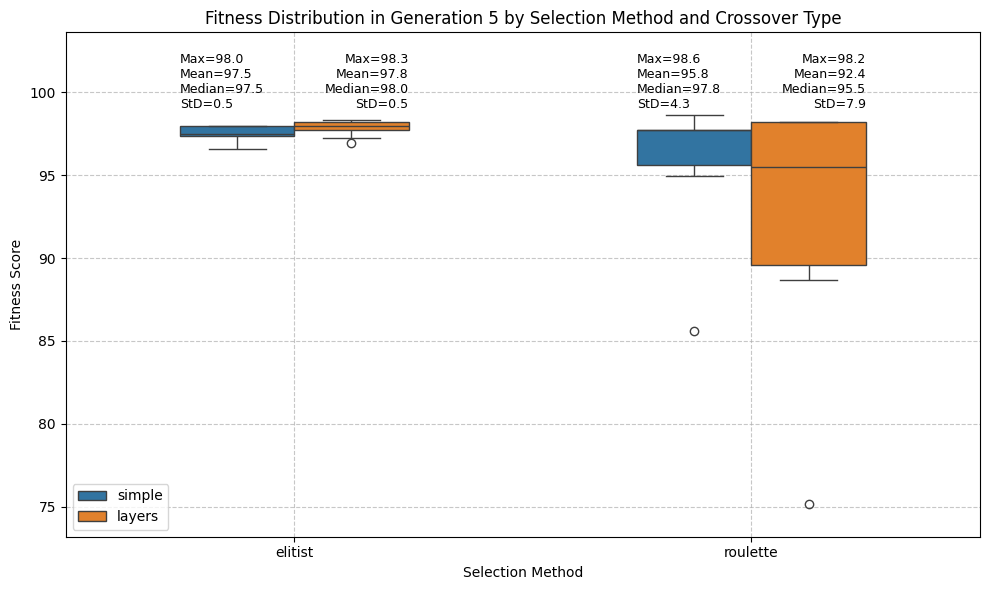


Numerical Summary for Generation 5 (excluding zero fitness):
                          mean   std    min    max
Method   Crossover Type                           
elitist  layers          97.91  0.45  97.09  98.34
         simple          97.40  0.46  96.91  98.28
roulette layers          92.79  6.97  76.25  97.78
         simple          93.47  3.70  87.94  97.84


In [ ]:
gen = 5
curr_df = comb_df[(comb_df['Generation'] == gen) & (comb_df['Fitness'] > 0)]
selection_methods = ['elitist', 'roulette']
crossover_methods = ['simple', 'layers']

visualize_method_x_crossover(curr_df, gen, selection_methods, crossover_methods)

Now let's check if the differences are significant.

Since the sample size is small, we will use the non-parametric **Pairwise Mann-Whitney U test with Bonferroni correction**:

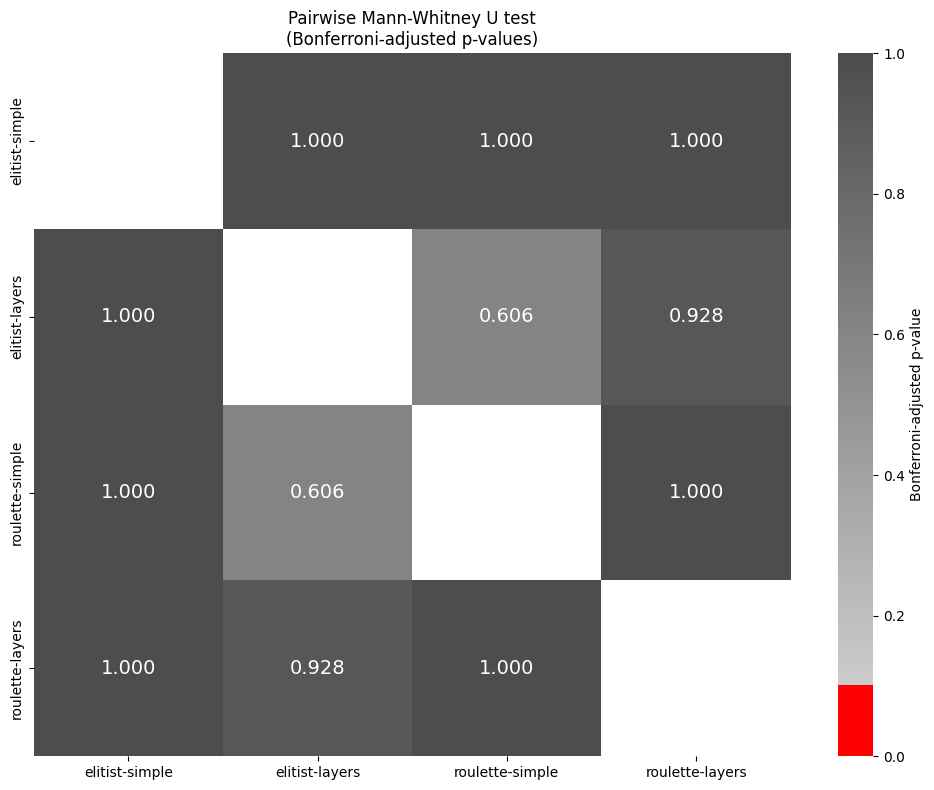

In [ ]:
# Create all group names
groups = ['elitist-simple', 'elitist-layers', 'roulette-simple', 'roulette-layers']
curr_df = comb_df[(comb_df['Generation'] == gen) & (comb_df['Fitness'] > 0)]
plot_heatmap_pairwise_mannwhitney(curr_df, groups)

It is important to note that what we are most interested in are the highest fitness values:

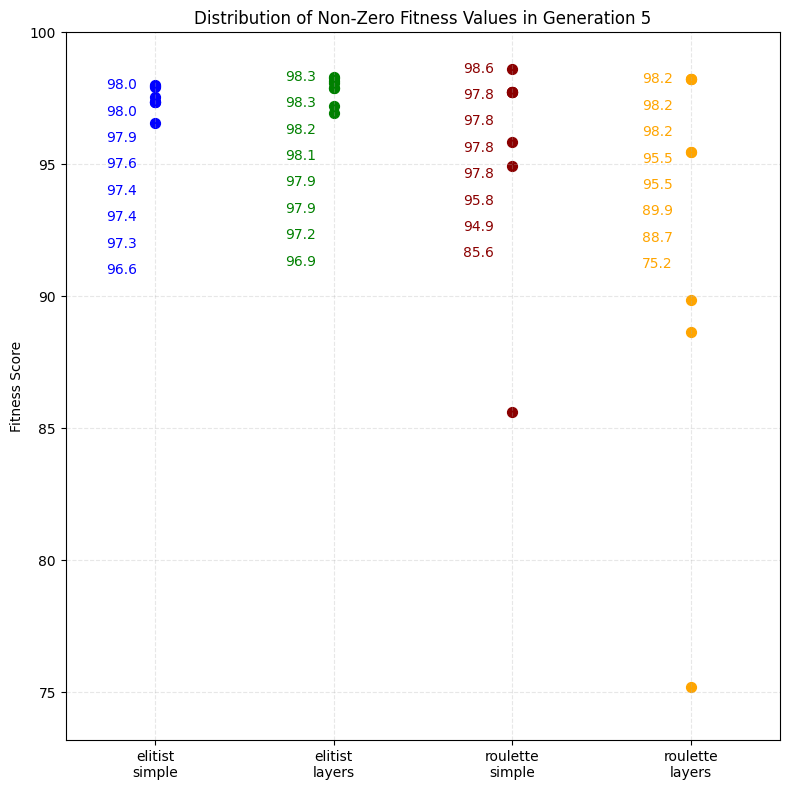

In [ ]:
gen = 5
curr_df = comb_df[(comb_df['Generation'] == gen) & (comb_df['Fitness'] > 0)]

groups = [('elitist', 'simple'), ('elitist', 'layers'), ('roulette', 'simple'), ('roulette', 'layers')]

# Define colors for each group
colors = {
    ('elitist', 'simple'): 'blue',
    ('elitist', 'layers'): 'green',
    ('roulette', 'simple'): 'darkred',
    ('roulette', 'layers'): 'orange'
}

plot_gen_values(curr_df, gen, colors)

Next, let's see how the evolution proceeded.

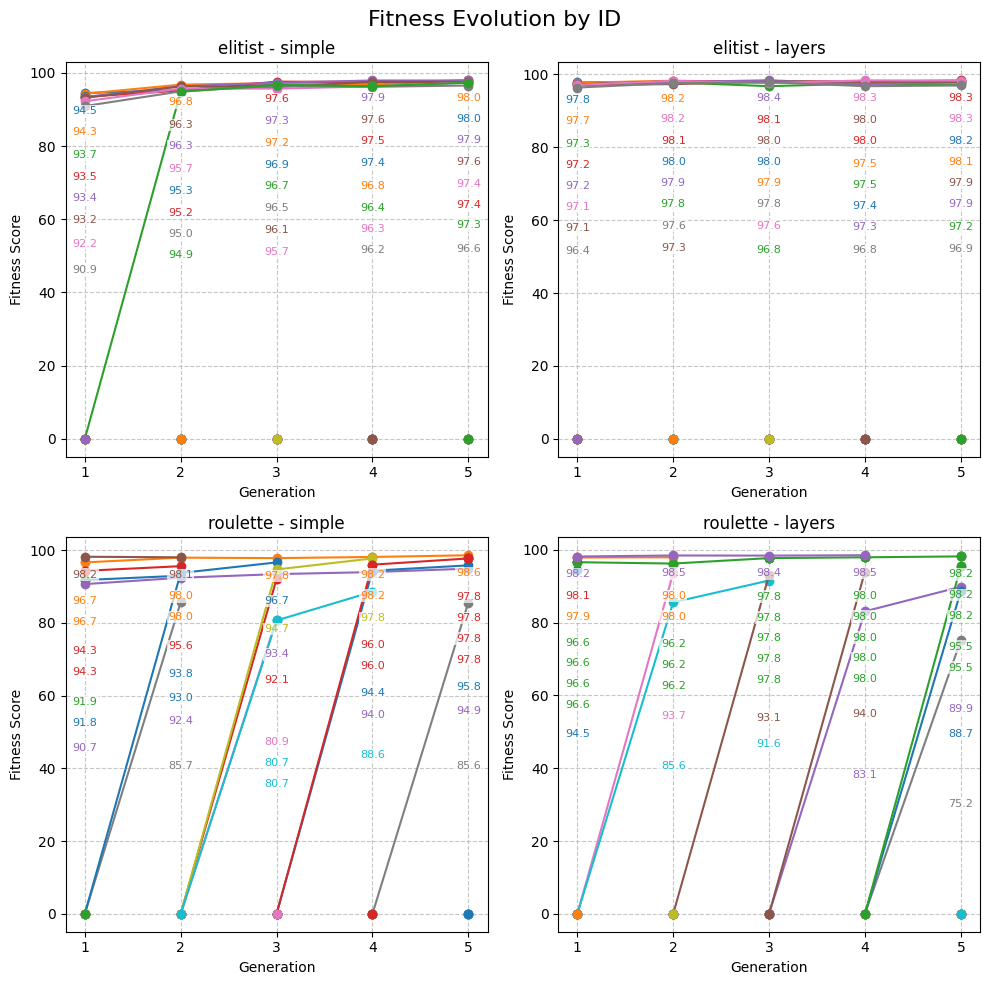

In [ ]:
curr_df = comb_df.copy()

plot_evo_paths(curr_df)

The **evolutionary effort**, calculated as

[number of generations] x [number of training epochs] x [population], is

In [ ]:
evo_effort = num_generations * num_train_epochs * population_size
print(f'{num_generations} x {num_train_epochs} x {population_size} = {evo_effort}')

5 x 3 x 15 = 225


### Compare to a standard architecture for MNIST

We will compare the performance of the evolutionary paradigm in experiments 1.1 and 1.2 to the classical LeNet-5 architecture optimized for MNIST (see <a href='https://ieeexplore.ieee.org/document/726791'>LeCun et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11) (1998): 2278-2324</a>
)

Each model will be trained for 15 epochs to make it comparable to the evolutionary effort in experiments 1.1 and 1.2.

In [ ]:
def generate_lenet5_architecture():
    return {
        'input_shape': (1, 28, 28),
        'conv_layers': [
            {
                'out_channels': 6,    # C1: 6 feature maps
                'kernel_size': 5,     # 5x5 convolutions
                'padding': 2,
                'activation': 'relu',  # originally used tanh, relu seems more efficient
                'pooling': {'type': 'max', 'size': 2}  # originally avg pooling
            },
            {
                'out_channels': 16,   # C3: 16 feature maps
                'kernel_size': 5,
                'padding': 2,
                'activation': 'relu',
                'pooling': {'type': 'max', 'size': 2}
            }
        ],
        'fc_layers': [
            {
                'out_features': 120,  # C5: 120 units
                'activation': 'relu'
            },
            {
                'out_features': 84,   # F6: 84 units
                'activation': 'relu'
            },
            {
                'out_features': 10,   # Output: 10 units (digits 0-9)
                'activation': None
            }
        ]
    }

In [ ]:
print(f'Creating {population_size} models based on LeNet-5 architecture...')
population0 = []
while len(population0) < population_size:
    entity = NN(generate_lenet5_architecture(), input_height=input_height, input_width=input_width)
    if entity._viable:
        population0.append(entity)
    else:
        print(f'Entity {entity._id} is not viable:')
        print(ind.network_architecture)

Creating 15 models based on LeNet-5 architecture...


In order to offer fair comparison, the numebr of epochs to train non-evolved models would be calculated as [evolutionary effort in experiments 1.1 and 1.2] / [populaiton size]:

In [ ]:
num_non_evo_train_epochs = evo_effort // population_size
print(num_non_evo_train_epochs)

15


In [ ]:
print(f'Training each model for {num_non_evo_train_epochs} epochs...')
for ind in population0:
    ind.fitness_score = evaluate_fitness(ind, train_loader, test_loader, num_epochs=num_non_evo_train_epochs)
    print(f'\nIndividual {ind._id}: {ind.fitness_score}')
    comb_df.loc[len(comb_df)] = {
        'ID': str(ind._id),
        'Fitness': ind.fitness_score,
        'ParentIDs': [],
        'Generation': 999,
        'Method': '',
        'Crossover Type': ''
    }

Training each model for 15 epochs...

Individual 52601647-c462-4fac-abba-c32f1b2fdd61: 96.0

Individual fd4c0e5e-5267-4abb-843f-809349bae9a0: 96.96875

Individual eebd0000-58c9-4de9-9d5d-5c5b6d03d2fa: 96.09375

Individual 151fe891-1f9d-4281-a39c-8db9344ae38f: 96.5

Individual 55d5e9c6-2932-4f8d-bd57-b75d4b71046b: 95.96875

Individual 33bdb4f3-2a54-484e-9b88-8de7e2136d36: 96.84375

Individual eccbc7e4-6d44-42f6-bcfd-e32145a9f79b: 96.4375

Individual 11b67f65-4fb0-4d47-93f6-410f270ceec3: 96.28125

Individual e20875b4-cfdf-4aef-87f6-bb55bda5b52b: 96.46875

Individual 1b1bd1ec-2103-46de-a939-2239fc020dc5: 96.28125

Individual 8ec4bd50-abb4-481c-a4b0-6d219b996896: 96.96875

Individual b01db17a-3c10-432b-8dd3-617ee3934713: 97.21875

Individual 20a09fae-7990-461f-bbfc-d6b0ad9cb4af: 96.3125

Individual dadf467e-990c-4930-9702-6b9d371864e3: 96.96875

Individual bec89bd2-8b10-4557-9ee2-cc5cc1c17d29: 96.15625


### Comparison and analysis

In [ ]:
# Get data for the comparison chart
colors = {
    ('elitist', 'simple'): 'blue',
    ('elitist', 'layers'): 'green',
    ('roulette', 'simple'): 'red',
    ('roulette', 'layers'): 'orange',
    ('',''): 'purple'}

# Filter for generations 5 and 999
filtered_df = comb_df[comb_df['Generation'].isin([5, 999])]

result_list = []

# Add the subsets for each method-crossover combination for generation 5
for (method, crossover), color in colors.items():
    if method != '' and crossover != '':  # Skip the empty combination for now
        subset = filtered_df[
            (filtered_df['Method'] == method) &
            (filtered_df['Crossover Type'] == crossover) &
            (filtered_df['Generation'] == 5)
        ]
        if not subset.empty:
            # Get top num_top_surv by fitness
            top_subset = subset.nlargest(num_top_surv, 'Fitness')
            result_list.append([
                top_subset,
                color,
                f'{method} {crossover}'
            ])

# Add the subset for generation 999 (empty method and crossover type)
baseline_subset = filtered_df[
    (filtered_df['Method'] == '') &
    (filtered_df['Crossover Type'] == '') &
    (filtered_df['Generation'] == 999)
]
if not baseline_subset.empty:
    # Get top num_top_surv by Fitness
    top_baseline = baseline_subset.nlargest(num_top_surv, 'Fitness')
    result_list.append([
        top_baseline,
        'purple',
        'baseline'
    ])

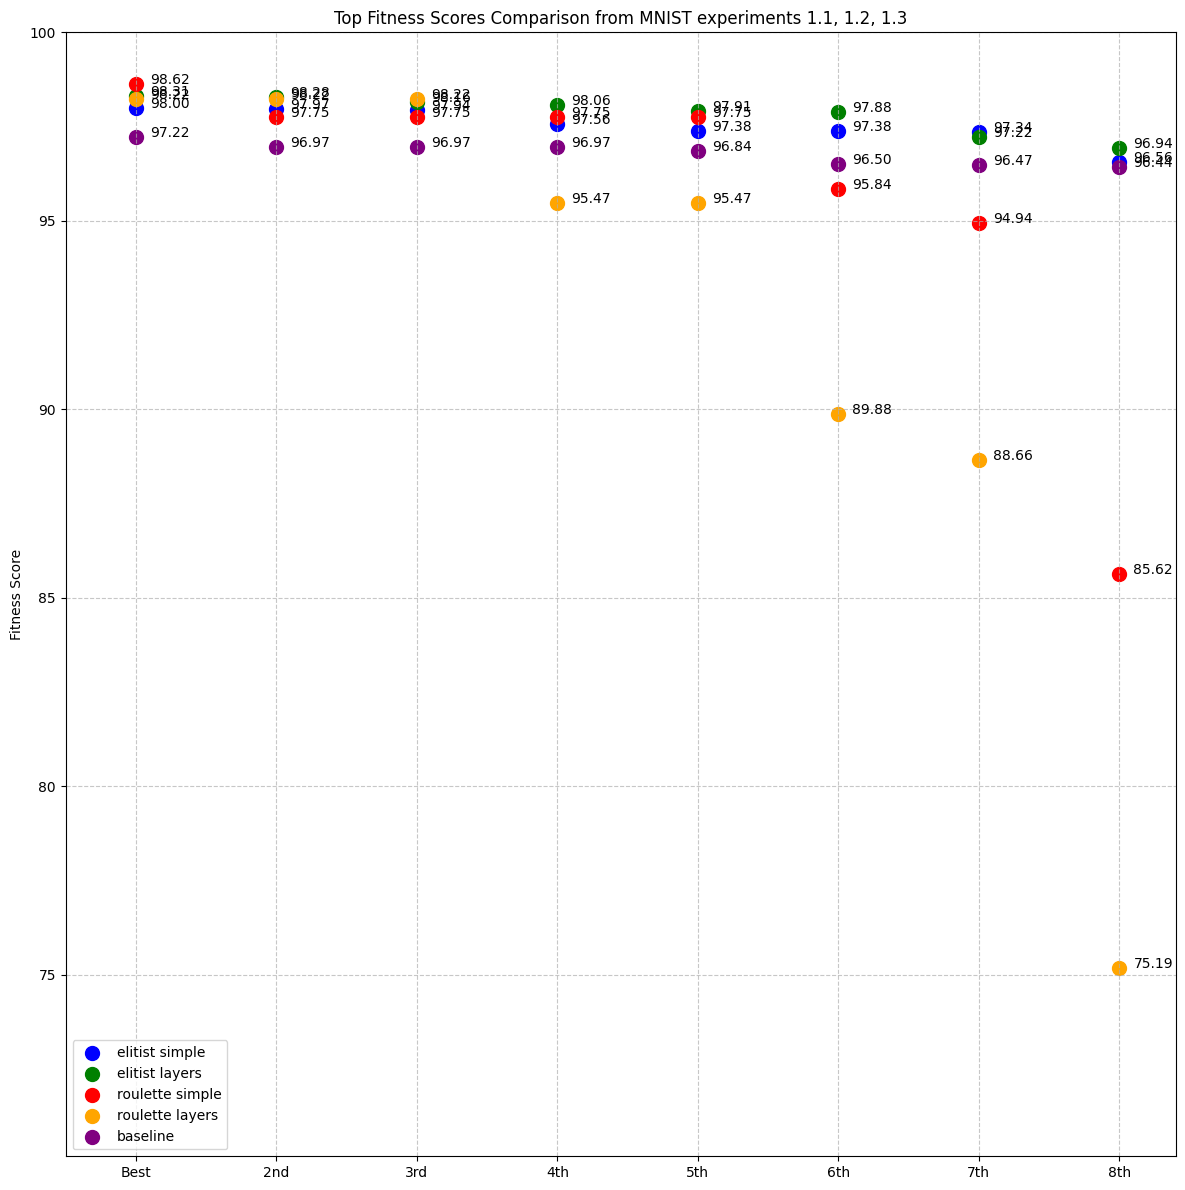

In [ ]:
plt.figure(figsize=(12, 12))

# Plot with labels for legend
min_fitness = float('inf')  # Initialize with infinity
for d in result_list:
   fitness_values = d[0]['Fitness'].values
   min_fitness = min(min_fitness, min(fitness_values))  # Track minimum fitness
   for i, fitness in enumerate(fitness_values):
       plt.scatter([i+1], [fitness], color=d[1], s=100, label=d[2] if i == 0 else "")
       plt.annotate(f'{fitness:.2f}', (i+1.1, fitness))

plt.ylabel('Fitness Score')

positions = list(range(1, num_top_surv + 1))
labels = ['Best'] + [f'{i}nd' if i == 2 else f'{i}rd' if i == 3 else f'{i}th' for i in range(2, num_top_surv + 1)]
plt.xticks(positions, labels)

plt.title('Top Fitness Scores Comparison from MNIST experiments 1.1, 1.2, 1.3')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(0.5, num_top_surv + 0.4)
plt.ylim(min_fitness - 5, 100)  # Set y-axis from lowest value minus 5 to 100

plt.tight_layout()

plt.legend(loc='lower left')

# Show the plot
plt.show()

Now let's analyze the differences statistically. As we have a very small sample and we do not know the underlying distribution, pairwise **Mann-Whitney U tests with a Bonferroni correction** would be appropriate.

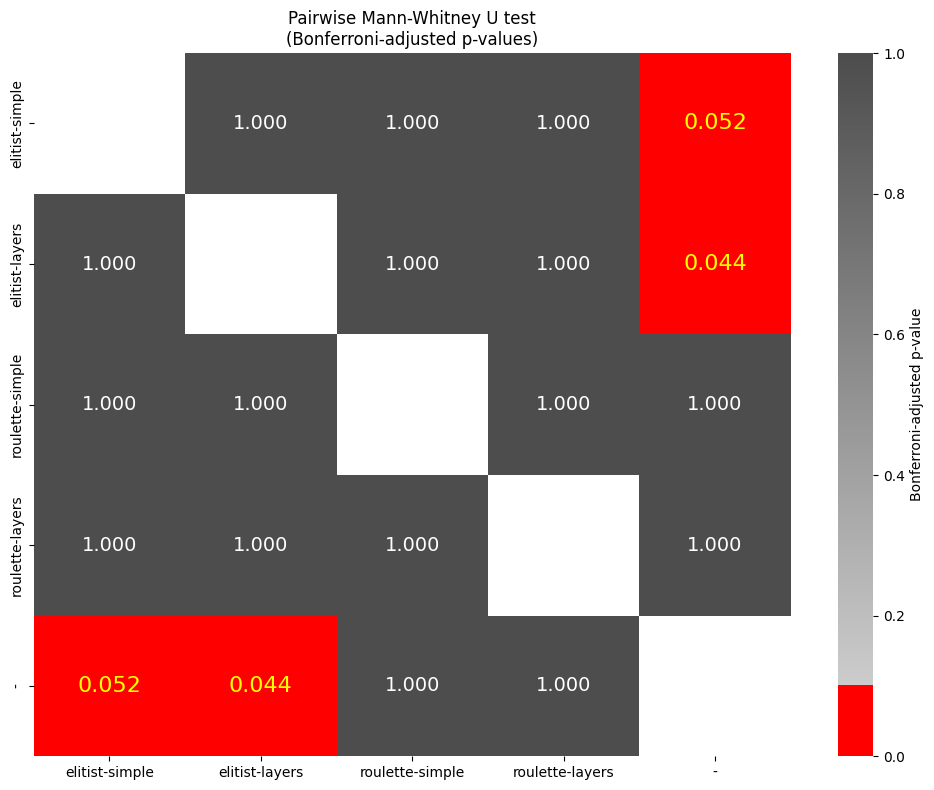

In [ ]:
# Create a new DataFrame combining all the data from result_list
combined_df = pd.DataFrame()
for df, color, label in result_list:
    # Split the label to get method and crossover type
    if label == 'baseline':
        method, crossover = '', ''
    else:
        method, crossover = label.split()

    # Add method and crossover type to the DataFrame
    df_copy = df.copy()
    df_copy['Method'] = method
    df_copy['Crossover Type'] = crossover
    combined_df = pd.concat([combined_df, df_copy], ignore_index=True)

# Create groups list
groups = [d[2].replace(' ', '-') if d[2] != 'baseline' else '-' for d in result_list]

# Call the function
plot_heatmap_pairwise_mannwhitney(combined_df, groups)

<font color=blue>
<u>Results:</u>
<ul>
<li>The Elitist selection method, with and without crossover, performs better than than both the Roulette method and the Baseline architecture.
<li>The difference in performance between different evolutionary methods seems less pronounced for the four top-performing evolved architectures, even though it is not feasible to ascertain that statistically due to the small number of samples.
</font>

However, MNIST is a relatively small and well-studied dataset. In order to achieve more solid conclusions, we will try the method on CIFAR.

## 2. Experiment with CIFAR

In [ ]:
from torchvision.datasets import CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # RGB
])

# Load CIFAR
cifar_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)


# Create DataLoader
train_loader = DataLoader(cifar_train, batch_size=64, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_train_epochs = 7 # Each evolutionary model will be trained for a limited number of epochs
input_height = 32  # CIFAR is 32x32
input_width = 32
input_channels = 3  # RGB instead of grayscale

batch_size = 64
output_categories = 10

In [ ]:
inp_shape = (input_channels, input_height, input_width) # for CIFAR's RGB
first_fc_layer_out_features = 512 # more for the more complex CIFAR images

In [ ]:
#Evolutionaty process characteristics
population_size = 20
num_generations = 8
mutation_rate = 0.1
num_top_surv = 10  # Top k individuals survive

In [ ]:
ss_conv_layers = [4, 5, 6] # Number of layers; deeper networks for CIFAR
ss_conv_filters = [32, 64, 128, 256] # More filters for CIFAR
ss_kernel_size = [3, 5] # Kernel sizes
ss_activation = ['relu', 'leaky_relu'] # Activation functions; sigmoid causes vanishing gradients
ss_pooling = [None, 'max', 'avg'] # Pooling layers

### Create population

In [ ]:
population = []
while len(population) < population_size:
    entity = NN(generate_architecture(inp_shape=inp_shape, out_features=first_fc_layer_out_features), input_height=input_height, input_width=input_width)
    if entity._viable:
        population.append(entity)
    else:
        print(f'Entity {entity._id} is not viable:')
        print(ind.network_architecture)

print('\n\nPopulation:')
for ind in population:
    print('\n')
    print('-' * 50)
    print(ind.network_architecture)  # This will print everything
    print('-' * 50)



Population:


--------------------------------------------------
NN (ID: 0074a2ce-f960-4cf9-87e3-01e72e57f783)
Parent IDs: []
Fitness score: 0

Architecture:
  Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(256, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  ReLU()
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(32, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  ReLU()
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

### Try different selection methods with and without crossover

Evolve networks to recognize images in CIFAR-10.

Try:
- Elitist (top n performers) and Roulette (Roulette-wheel selection via stochastic acceptance)
- Without Crossover (simple) and With Crossover (layers)

In [ ]:
methods = ['elitist', 'roulette']
crossover_types = ['simple', 'layers']

all_dfs = []

for m in methods:
    for ct in crossover_types:
        print(f'\n\nSelection method: {m}, Crossover type: {ct}\n')
        population0 = population.copy()
        df0 = evolve(num_generations, train_loader, test_loader,
                     population0,
                     num_top_surv, mutation_rate,
                     crossover_type=ct,
                     num_epochs=num_train_epochs,
                     selection_method=m)
        df0['Method'] = m
        df0['Crossover Type'] = ct
        all_dfs.append(df0)

# Combine all DataFrames
comb_df = pd.concat(all_dfs, ignore_index=True)
comb_df



Selection method: elitist, Crossover type: simple


Evolving gen 1 ---------------------------------

Individual 0074a2ce-f960-4cf9-87e3-01e72e57f783: 44.75

Individual 6f5c77cb-53a5-4e86-9653-bc0b69da932d: 35.53125

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 49.0625

Individual 6717263f-ed7a-449e-85da-dc3c0d7313bb: 42.84375

Individual cf8d8246-c6aa-4e63-8e60-7d99c861bb23: 43.5

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 51.46875

Individual d1b2fe23-975b-40e0-965a-df342b5a5362: 39.90625

Individual c7e714bd-3de3-4268-b692-e3e11319771a: 43.25

Individual 63082c8a-ac1a-42c2-9ce7-44e3d8ef9087: 38.0

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 48.53125

Individual 51b73d64-f0e7-411f-8563-cca46054078e: 42.40625

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 47.375

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 44.9375

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 47.90625

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 46.4375

Individual b79e7776-95bb-4048-

ID  \
0   ad6adbed-9a71-42cd-b11e-ce18c559587c   
1   de26c87a-9274-4cc3-aada-fbfcee53dc3a   
2   31dbcc2b-5d1a-4817-8b6c-3c986367752c   
3   ecded0f9-84f5-4ff2-971a-905f01b73c4b   
4   09b715d4-98d8-4482-aad6-d2a566720d50   
5   c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
6   62d3ecc2-2035-49ec-87a7-07e9896c3002   
7   cb2858d5-1ce4-4ee7-9489-11649b0de515   
8   3156858b-69ab-4058-ac32-0974dc6d1543   
9   c785f7f5-3592-41da-b252-ea6180c18ace   
10  e7e7967f-d62b-4d69-8457-83d5c7cd99c1   
11  df589bcc-db1a-47c7-ab55-a732969d3b5a   
12  f156be83-00b1-478d-8127-37b199212a37   
13  5fa3ec09-250b-4e9f-a304-a85a4b35acf9   
14  6c2a7c0b-f653-431c-bdba-16bf2914c871   
15  6d881837-72fb-4ed0-81e3-7973af69ec5f   
16  1d628f7a-39bb-4d64-b3a7-3124915abbc8   
17  645bef94-17e9-4e21-a0e9-a0d89f8cef33   
18  f93f3976-2095-47ac-8f6a-a1c609539646   
19  bbd94030-de6a-4228-b279-c1cb13af83b1   

                                            ParentIDs   Fitness  Generation  
0                                                  []  51.46875           1  
1                                                  []  50.68750           1  
2                                                  []  49.06250           1  
3                                                  []  48.53125           1  
4                                                  []  47.90625           1  
5                                                  []  47.37500           1  
6                                                  []  46.84375           1  
7                                                  []  46.62500           1  
8                                                  []  46.43750           1  
9                                                  []  44.93750           1  
10  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           1  
11  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           1  
12  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           1  
13  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           1  
14  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           1  
15  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           1  
16  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           1  
17  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           1  
18  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           1  
19  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 61.0625

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 61.15625

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 57.84375

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 60.03125

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 58.28125

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 53.84375

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 59.0625

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 55.84375

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 56.09375

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 53.96875

Individual e7e7967f-d62b-4d69-8457-83d5c7cd99c1: 47.78125

Individual df589bcc-db1a-47c7-ab55-a732969d3b5a: 46.875

Individual f156be83-00b1-478d-8127-37b199212a37: 52.96875

Individual 5fa3ec09-250b-4e9f-a304-a85a4b35acf9: 50.78125

Individual 6c2a7c0b-f653-431c-bdba-16bf2914c871: 47.6875

Individual 6d881837-72fb-4ed0-81e3-7973af69ec5f: 49.78125

Individual

ID  \
20  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
21  ad6adbed-9a71-42cd-b11e-ce18c559587c   
22  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
23  62d3ecc2-2035-49ec-87a7-07e9896c3002   
24  09b715d4-98d8-4482-aad6-d2a566720d50   
25  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
26  3156858b-69ab-4058-ac32-0974dc6d1543   
27  cb2858d5-1ce4-4ee7-9489-11649b0de515   
28  c785f7f5-3592-41da-b252-ea6180c18ace   
29  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
30  ebdcefff-3be0-44da-8b9a-1a69b5df85e1   
31  44c315ec-0fda-47f4-8717-75b03f8f1e99   
32  66b4b721-737d-44f2-ba03-091389fcdb61   
33  899c741e-f00c-4d51-95d1-7ede1bd1c1da   
34  c1c51b92-a104-4b8c-a82a-8610c200df39   
35  45508ed7-7e25-4f4e-b87c-02adb15d4eb8   
36  1d14ef4f-efe6-436b-b5ee-cc0244326be3   
37  7d23408f-0df1-4b31-91f0-6818378ec19a   
38  d25125bd-4e7c-4434-9780-08db8082a02e   
39  4d8a80eb-fd8a-4d08-9c5b-c7e72f9509ca   

                                            ParentIDs   Fitness  Generation  
20                                                 []  61.15625           2  
21                                                 []  61.06250           2  
22                                                 []  60.03125           2  
23                                                 []  59.06250           2  
24                                                 []  58.28125           2  
25                                                 []  57.84375           2  
26                                                 []  56.09375           2  
27                                                 []  55.84375           2  
28                                                 []  53.96875           2  
29                                                 []  53.84375           2  
30  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           2  
31  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           2  
32  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           2  
33  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           2  
34  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           2  
35  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           2  
36  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           2  
37  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           2  
38  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           2  
39  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 66.4375

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 65.78125

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 64.625

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 63.15625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 64.125

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 63.625

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 61.96875

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 62.96875

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 56.96875

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 61.09375

Individual ebdcefff-3be0-44da-8b9a-1a69b5df85e1: 43.96875

Individual 44c315ec-0fda-47f4-8717-75b03f8f1e99: 47.3125

Individual 66b4b721-737d-44f2-ba03-091389fcdb61: 43.96875

Individual 899c741e-f00c-4d51-95d1-7ede1bd1c1da: 50.625

Individual c1c51b92-a104-4b8c-a82a-8610c200df39: 47.8125

Individual 45508ed7-7e25-4f4e-b87c-02adb15d4eb8: 49.96875

Individual 1d14e

ID  \
40  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
41  ad6adbed-9a71-42cd-b11e-ce18c559587c   
42  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
43  09b715d4-98d8-4482-aad6-d2a566720d50   
44  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
45  62d3ecc2-2035-49ec-87a7-07e9896c3002   
46  cb2858d5-1ce4-4ee7-9489-11649b0de515   
47  3156858b-69ab-4058-ac32-0974dc6d1543   
48  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
49  c785f7f5-3592-41da-b252-ea6180c18ace   
50  9836a3fc-2d8e-4843-893e-bb9c72c0d159   
51  60e2e69d-bd06-4d1a-b2a2-fc365bd22742   
52  145ee610-21e4-4c3b-9bff-af1937139d72   
53  22d3599c-7049-4aef-a72f-90273196c556   
54  deeac834-fb52-422a-ace6-e2d7e2c90e2e   
55  3c88e661-302d-4391-94b7-88c3314d2aaa   
56  000b4ab9-0313-49f7-8d8c-3d64508f2243   
57  1000a220-d70c-4659-9d77-16091920ee73   
58  045ed12d-ea84-4b7b-aa97-02e2678455cf   
59  5a98927b-155f-47bc-bc96-05af29a68b75   

                                            ParentIDs   Fitness  Generation  
40                                                 []  66.43750           3  
41                                                 []  65.78125           3  
42                                                 []  64.62500           3  
43                                                 []  64.12500           3  
44                                                 []  63.62500           3  
45                                                 []  63.15625           3  
46                                                 []  62.96875           3  
47                                                 []  61.96875           3  
48                                                 []  61.09375           3  
49                                                 []  56.96875           3  
50  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           3  
51  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           3  
52  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           3  
53  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           3  
54  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           3  
55  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           3  
56  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           3  
57  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           3  
58  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           3  
59  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 68.3125

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 69.5625

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 68.03125

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 65.625

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 70.03125

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 65.8125

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 67.09375

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 66.71875

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 63.21875

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 60.625

Individual 9836a3fc-2d8e-4843-893e-bb9c72c0d159: 45.71875

Individual 60e2e69d-bd06-4d1a-b2a2-fc365bd22742: 48.59375

Individual 145ee610-21e4-4c3b-9bff-af1937139d72: 50.8125

Individual 22d3599c-7049-4aef-a72f-90273196c556: 49.5

Individual deeac834-fb52-422a-ace6-e2d7e2c90e2e: 46.15625

Individual 3c88e661-302d-4391-94b7-88c3314d2aaa: 48.53125

Individual 000b4a

ID  \
60  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
61  ad6adbed-9a71-42cd-b11e-ce18c559587c   
62  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
63  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
64  cb2858d5-1ce4-4ee7-9489-11649b0de515   
65  3156858b-69ab-4058-ac32-0974dc6d1543   
66  62d3ecc2-2035-49ec-87a7-07e9896c3002   
67  09b715d4-98d8-4482-aad6-d2a566720d50   
68  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
69  c785f7f5-3592-41da-b252-ea6180c18ace   
70  d8217c9e-6d39-4bf2-9087-8942937b73e6   
71  a0aff42e-3620-49c7-a4c8-6a38e7264e96   
72  3e6bdcd5-5b57-4371-91d8-59c9db540817   
73  ae7536a5-c972-4466-b003-b7592bf61d50   
74  21186bff-794c-414f-b5db-490ce3f193a8   
75  a7141555-b234-4ca7-8fe9-eae7c2eeb1ad   
76  f2c64e60-0b52-4d61-a237-88643ae12703   
77  4bb167bf-bee2-4ec6-b79e-f99980c7fe57   
78  a23f6f8c-6e94-481a-9ebd-f40ad00abb02   
79  d5d70e88-e0e8-4cbe-b571-c48fbe010876   

                                            ParentIDs   Fitness  Generation  
60                                                 []  70.03125           4  
61                                                 []  69.56250           4  
62                                                 []  68.31250           4  
63                                                 []  68.03125           4  
64                                                 []  67.09375           4  
65                                                 []  66.71875           4  
66                                                 []  65.81250           4  
67                                                 []  65.62500           4  
68                                                 []  63.21875           4  
69                                                 []  60.62500           4  
70  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           4  
71  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           4  
72  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           4  
73  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           4  
74  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           4  
75  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           4  
76  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           4  
77  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           4  
78  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           4  
79  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 71.59375

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 69.6875

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 71.28125

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 70.03125

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 70.78125

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 67.4375

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 67.90625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 70.5

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 66.5625

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 64.21875

Individual d8217c9e-6d39-4bf2-9087-8942937b73e6: 44.90625

Individual a0aff42e-3620-49c7-a4c8-6a38e7264e96: 47.0

Individual 3e6bdcd5-5b57-4371-91d8-59c9db540817: 47.0

Individual ae7536a5-c972-4466-b003-b7592bf61d50: 47.96875

Individual 21186bff-794c-414f-b5db-490ce3f193a8: 47.28125

Individual a7141555-b234-4ca7-8fe9-eae7c2eeb1ad: 49.5

Individual f2c64e60-0b52

ID  \
80  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
81  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
82  cb2858d5-1ce4-4ee7-9489-11649b0de515   
83  09b715d4-98d8-4482-aad6-d2a566720d50   
84  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
85  ad6adbed-9a71-42cd-b11e-ce18c559587c   
86  62d3ecc2-2035-49ec-87a7-07e9896c3002   
87  3156858b-69ab-4058-ac32-0974dc6d1543   
88  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
89  c785f7f5-3592-41da-b252-ea6180c18ace   
90  e1eeaddf-6291-46e0-8206-83cfdcb3d255   
91  886c6ce3-a7ac-47a2-9901-ce2dcf84ada8   
92  d849a7c2-4ec1-4c59-8ac3-f0212da47c14   
93  3fbf2d59-4d49-4acf-bcc5-3fb6451482f0   
94  dce1362f-41fe-4e43-8857-8fbda11e5cb1   
95  29038c56-1d7f-4ba0-9eac-4364eea7eb0f   
96  87235a78-0b7b-4f76-bce5-e5df57dc9c9f   
97  0a0a6701-da94-4eee-8c18-3efc08459f80   
98  5dad1cb4-7d56-4d7a-bc3e-9f867d6ce890   
99  e87816a1-430a-4b68-86bd-ef1c6948b07e   

                                            ParentIDs   Fitness  Generation  
80                                                 []  71.59375           5  
81                                                 []  71.28125           5  
82                                                 []  70.78125           5  
83                                                 []  70.50000           5  
84                                                 []  70.03125           5  
85                                                 []  69.68750           5  
86                                                 []  67.90625           5  
87                                                 []  67.43750           5  
88                                                 []  66.56250           5  
89                                                 []  64.21875           5  
90  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           5  
91  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           5  
92  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           5  
93  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           5  
94  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           5  
95  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           5  
96  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           5  
97  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           5  
98  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           5  
99  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           5


Evolving gen 6 ---------------------------------

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 73.5625

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 72.3125

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 72.3125

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 68.1875

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 70.75

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 71.65625

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 70.125

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 69.4375

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 67.6875

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 63.65625

Individual e1eeaddf-6291-46e0-8206-83cfdcb3d255: 48.3125

Individual 886c6ce3-a7ac-47a2-9901-ce2dcf84ada8: 50.84375

Individual d849a7c2-4ec1-4c59-8ac3-f0212da47c14: 49.09375

Individual 3fbf2d59-4d49-4acf-bcc5-3fb6451482f0: 45.28125

Individual dce1362f-41fe-4e43-8857-8fbda11e5cb1: 48.1875

Individual 29038c56-1d7f-4ba0-9eac-4364eea7eb0f: 43.28125

Individual 87235a7

ID  \
100  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
101  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
102  cb2858d5-1ce4-4ee7-9489-11649b0de515   
103  ad6adbed-9a71-42cd-b11e-ce18c559587c   
104  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
105  62d3ecc2-2035-49ec-87a7-07e9896c3002   
106  3156858b-69ab-4058-ac32-0974dc6d1543   
107  09b715d4-98d8-4482-aad6-d2a566720d50   
108  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
109  c785f7f5-3592-41da-b252-ea6180c18ace   
110  9076024c-23fd-4dfa-a142-b173049f7055   
111  794a36ab-8c45-4970-a07b-d26e09de0fb6   
112  ec8d1e3f-689d-4dec-81c6-73a27ac26ff5   
113  1d1ed05e-2794-4b5d-b298-6798f991e52a   
114  d561bf43-ca1c-49fb-9633-1ec798d202d5   
115  372dd297-0101-415e-92c2-0c205fda9efe   
116  23e2dcae-2782-4bc7-a277-5afef3d8f700   
117  8a011860-0341-4723-821f-97dec0c389a9   
118  55589b3d-564a-4f74-aaff-baebc93a9e4d   
119  54a73afc-4893-44c6-b3ee-bea31a708891   

                                             ParentIDs   Fitness  Generation  
100                                                 []  73.56250           6  
101                                                 []  72.31250           6  
102                                                 []  72.31250           6  
103                                                 []  71.65625           6  
104                                                 []  70.75000           6  
105                                                 []  70.12500           6  
106                                                 []  69.43750           6  
107                                                 []  68.18750           6  
108                                                 []  67.68750           6  
109                                                 []  63.65625           6  
110  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           6  
111  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           6  
112  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           6  
113  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           6  
114  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           6  
115  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           6  
116  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           6  
117  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           6  
118  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           6  
119  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           6


Evolving gen 7 ---------------------------------

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 70.84375

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 72.40625

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 73.0

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 71.40625

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 71.75

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 71.90625

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 68.4375

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 71.84375

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 68.65625

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 66.6875

Individual 9076024c-23fd-4dfa-a142-b173049f7055: 45.34375

Individual 794a36ab-8c45-4970-a07b-d26e09de0fb6: 49.875

Individual ec8d1e3f-689d-4dec-81c6-73a27ac26ff5: 47.96875

Individual 1d1ed05e-2794-4b5d-b298-6798f991e52a: 49.5625

Individual d561bf43-ca1c-49fb-9633-1ec798d202d5: 53.90625

Individual 372dd297-0101-415e-92c2-0c205fda9efe: 48.84375

Individual 23e2dc

ID  \
120  cb2858d5-1ce4-4ee7-9489-11649b0de515   
121  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
122  62d3ecc2-2035-49ec-87a7-07e9896c3002   
123  09b715d4-98d8-4482-aad6-d2a566720d50   
124  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
125  ad6adbed-9a71-42cd-b11e-ce18c559587c   
126  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
127  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
128  3156858b-69ab-4058-ac32-0974dc6d1543   
129  c785f7f5-3592-41da-b252-ea6180c18ace   
130  5f73787e-0a22-4576-b2ea-7a0751f6effa   
131  5ec78733-a50d-47ab-914a-833ff8562e2f   
132  ec9aff50-d751-4fc7-ad1a-6a91d2bfe28f   
133  629e8d65-41f0-4b74-929c-1a811ffc242c   
134  82e1db55-9bac-48df-886c-65d7ddcb31d1   
135  319d5ec8-bea7-410a-a718-80085ef2ad82   
136  d3282509-7bb1-4b33-9868-1c422ec5a8c1   
137  d68eef91-94f2-4c7c-995c-f3ce2411a439   
138  11b4670d-47f7-4686-965d-55dbbc6dc1f1   
139  ebbf952b-3028-4db3-aff1-09bab64b69cf   

                                             ParentIDs   Fitness  Generation  
120                                                 []  73.00000           7  
121                                                 []  72.40625           7  
122                                                 []  71.90625           7  
123                                                 []  71.84375           7  
124                                                 []  71.75000           7  
125                                                 []  71.40625           7  
126                                                 []  70.84375           7  
127                                                 []  68.65625           7  
128                                                 []  68.43750           7  
129                                                 []  66.68750           7  
130  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           7  
131  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           7  
132  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           7  
133  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           7  
134  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           7  
135  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           7  
136  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           7  
137  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           7  
138  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           7  
139  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           7


Evolving gen 8 ---------------------------------

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 73.71875

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 74.09375

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 72.625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 72.875

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 71.125

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 72.375

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 73.625

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 70.6875

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 70.65625

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 68.0625

Individual 5f73787e-0a22-4576-b2ea-7a0751f6effa: 44.90625

Individual 5ec78733-a50d-47ab-914a-833ff8562e2f: 47.53125

Individual ec9aff50-d751-4fc7-ad1a-6a91d2bfe28f: 51.71875

Individual 629e8d65-41f0-4b74-929c-1a811ffc242c: 46.40625

Individual 82e1db55-9bac-48df-886c-65d7ddcb31d1: 47.09375

Individual 319d5ec8-bea7-410a-a718-80085ef2ad82: 47.59375

Individual d32825

ID  \
140  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
141  cb2858d5-1ce4-4ee7-9489-11649b0de515   
142  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
143  09b715d4-98d8-4482-aad6-d2a566720d50   
144  62d3ecc2-2035-49ec-87a7-07e9896c3002   
145  ad6adbed-9a71-42cd-b11e-ce18c559587c   
146  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
147  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
148  3156858b-69ab-4058-ac32-0974dc6d1543   
149  c785f7f5-3592-41da-b252-ea6180c18ace   
150  8a5e48f9-507b-4962-8358-e310e9dd420b   
151  ee57984e-9c2b-4c00-b723-79857a42e754   
152  fbeadcf7-5591-4554-9814-905e9b22b6c7   
153  d7f3e438-2a32-4f2a-b953-0d870f2657f8   
154  87f3c505-7a97-45cf-a580-b4c039d85e30   
155  89fbde0d-76b0-47b8-9e92-d58ed02f6695   
156  cdffd45d-d333-4bd4-a60f-b551e9676569   
157  f216e881-7625-4584-8ac9-1b4e42b9f222   
158  7a1aa9d5-0669-4084-aea2-2a7e053a1ced   
159  612f8bb8-3e08-4007-a21d-9cf6efde5f3b   

                                             ParentIDs   Fitness  Generation  
140                                                 []  74.09375           8  
141                                                 []  73.71875           8  
142                                                 []  73.62500           8  
143                                                 []  72.87500           8  
144                                                 []  72.62500           8  
145                                                 []  72.37500           8  
146                                                 []  71.12500           8  
147                                                 []  70.68750           8  
148                                                 []  70.65625           8  
149                                                 []  68.06250           8  
150  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           8  
151  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           8  
152  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           8  
153  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           8  
154  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           8  
155  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           8  
156  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           8  
157  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           8  
158  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           8  
159  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           8



Selection method: elitist, Crossover type: layers


Evolving gen 1 ---------------------------------

Individual 0074a2ce-f960-4cf9-87e3-01e72e57f783: 54.625

Individual 6f5c77cb-53a5-4e86-9653-bc0b69da932d: 51.34375

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 74.28125

Individual 6717263f-ed7a-449e-85da-dc3c0d7313bb: 51.90625

Individual cf8d8246-c6aa-4e63-8e60-7d99c861bb23: 52.40625

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.40625

Individual d1b2fe23-975b-40e0-965a-df342b5a5362: 50.65625

Individual c7e714bd-3de3-4268-b692-e3e11319771a: 50.84375

Individual 63082c8a-ac1a-42c2-9ce7-44e3d8ef9087: 57.15625

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 73.84375

Individual 51b73d64-f0e7-411f-8563-cca46054078e: 51.78125

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 71.09375

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 70.46875

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 72.90625

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 71.15625

Individual b7

ID  \
0   cb2858d5-1ce4-4ee7-9489-11649b0de515   
1   ad6adbed-9a71-42cd-b11e-ce18c559587c   
2   31dbcc2b-5d1a-4817-8b6c-3c986367752c   
3   ecded0f9-84f5-4ff2-971a-905f01b73c4b   
4   62d3ecc2-2035-49ec-87a7-07e9896c3002   
5   09b715d4-98d8-4482-aad6-d2a566720d50   
6   de26c87a-9274-4cc3-aada-fbfcee53dc3a   
7   3156858b-69ab-4058-ac32-0974dc6d1543   
8   c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
9   c785f7f5-3592-41da-b252-ea6180c18ace   
10  693a53a8-44f2-442f-9ef6-c0bb8156bc47   
11  69cdc214-29bc-4159-bad1-4ba92fc57245   
12  923eb459-7653-4c27-b7fe-c995b2391d43   
13  309fdb0d-942d-440b-83b2-3a58a2481baf   
14  e6205a9d-e14d-446c-858a-4347870c1e6d   
15  b440d7da-e1e2-420a-994d-114cf133ce0b   
16  712af6ac-2d74-45c7-a1bf-76676a9eacdd   
17  a1a2e01b-28bc-44eb-9f74-4c1b7d87b2cc   
18  cd38927d-c631-4e71-9027-20d64e26f4f2   
19  102e3ec1-57e3-4d56-aeed-ef64443b188a   

                                            ParentIDs   Fitness  Generation  
0                                                  []  74.68750           1  
1                                                  []  74.40625           1  
2                                                  []  74.28125           1  
3                                                  []  73.84375           1  
4                                                  []  73.06250           1  
5                                                  []  72.90625           1  
6                                                  []  71.56250           1  
7                                                  []  71.15625           1  
8                                                  []  71.09375           1  
9                                                  []  70.46875           1  
10  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           1  
11  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           1  
12  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           1  
13  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           1  
14  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           1  
15  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           1  
16  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           1  
17  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           1  
18  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           1  
19  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 75.3125

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 73.8125

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 75.8125

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 72.21875

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 71.9375

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 72.34375

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 74.96875

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 72.25

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 69.8125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 70.75

Individual 693a53a8-44f2-442f-9ef6-c0bb8156bc47: 54.75

Individual 69cdc214-29bc-4159-bad1-4ba92fc57245: 48.59375

Individual 923eb459-7653-4c27-b7fe-c995b2391d43: 46.0

Individual 309fdb0d-942d-440b-83b2-3a58a2481baf: 44.3125

Individual e6205a9d-e14d-446c-858a-4347870c1e6d: 45.6875

Individual b440d7da-e1e2-420a-994d-114cf133ce0b: 47.90625

Individual 712af6ac-2d74-

ID  \
20  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
21  cb2858d5-1ce4-4ee7-9489-11649b0de515   
22  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
23  ad6adbed-9a71-42cd-b11e-ce18c559587c   
24  09b715d4-98d8-4482-aad6-d2a566720d50   
25  3156858b-69ab-4058-ac32-0974dc6d1543   
26  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
27  62d3ecc2-2035-49ec-87a7-07e9896c3002   
28  c785f7f5-3592-41da-b252-ea6180c18ace   
29  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
30  a73b1963-4a71-4af0-b90a-0a77dc7a6a8e   
31  253adc96-7cdb-4e84-95fe-ca6cc90260fb   
32  6a53d588-29c0-4c63-897e-ef298b50ed01   
33  6d8d566b-f76a-4015-8736-858a455715b6   
34  756e3654-4eca-4a49-949a-141505333f32   
35  544086e3-fa40-4c2a-9f1e-1fc9885fb26f   
36  e52411a0-d89a-4eda-8b6d-b69e3504b09e   
37  249d72fb-bbf3-4019-a6ca-0e84facfe6cb   
38  d208d9d8-441d-4f17-8d3f-b94baef1c6f0   
39  ed860438-4b73-4b30-9c49-d21de39d2a4f   

                                            ParentIDs   Fitness  Generation  
20                                                 []  75.81250           2  
21                                                 []  75.31250           2  
22                                                 []  74.96875           2  
23                                                 []  73.81250           2  
24                                                 []  72.34375           2  
25                                                 []  72.25000           2  
26                                                 []  72.21875           2  
27                                                 []  71.93750           2  
28                                                 []  70.75000           2  
29                                                 []  69.81250           2  
30  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           2  
31  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           2  
32  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           2  
33  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           2  
34  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           2  
35  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           2  
36  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           2  
37  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           2  
38  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           2  
39  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 76.03125

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 75.09375

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 74.28125

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.75

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 72.75

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 72.65625

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 74.21875

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 72.71875

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 69.3125

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 71.625

Individual a73b1963-4a71-4af0-b90a-0a77dc7a6a8e: 39.65625

Individual 253adc96-7cdb-4e84-95fe-ca6cc90260fb: 49.78125

Individual 6a53d588-29c0-4c63-897e-ef298b50ed01: 46.96875

Individual 6d8d566b-f76a-4015-8736-858a455715b6: 47.0

Individual 756e3654-4eca-4a49-949a-141505333f32: 44.71875

Individual 544086e3-fa40-4c2a-9f1e-1fc9885fb26f: 44.3125

Individual e52411a0

ID  \
40  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
41  cb2858d5-1ce4-4ee7-9489-11649b0de515   
42  ad6adbed-9a71-42cd-b11e-ce18c559587c   
43  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
44  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
45  09b715d4-98d8-4482-aad6-d2a566720d50   
46  62d3ecc2-2035-49ec-87a7-07e9896c3002   
47  3156858b-69ab-4058-ac32-0974dc6d1543   
48  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
49  c785f7f5-3592-41da-b252-ea6180c18ace   
50  fefa3def-02be-47a6-a308-1376d68e75bf   
51  0ce6131f-6e63-48fd-8c5b-8996cc7a0795   
52  63fce452-4c0c-45d1-8390-feac19399ec3   
53  fae50661-8300-4591-b370-79577fb40d64   
54  28bc7f06-6a06-43ac-a04c-165975823b52   
55  3eea9446-5c73-479f-9632-d45f5b7f7b3b   
56  d98adcce-2645-4f84-9db2-11544728bb01   
57  3cce87d6-d219-4502-a54a-b264fbaa739c   
58  9508f7c7-b69f-4327-84eb-85816142fe57   
59  658d877b-cd43-4e06-bd56-2a3a7498600d   

                                            ParentIDs   Fitness  Generation  
40                                                 []  76.03125           3  
41                                                 []  75.09375           3  
42                                                 []  74.75000           3  
43                                                 []  74.28125           3  
44                                                 []  74.21875           3  
45                                                 []  72.75000           3  
46                                                 []  72.71875           3  
47                                                 []  72.65625           3  
48                                                 []  71.62500           3  
49                                                 []  69.31250           3  
50  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           3  
51  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           3  
52  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           3  
53  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           3  
54  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           3  
55  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           3  
56  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           3  
57  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           3  
58  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           3  
59  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 75.21875

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 74.875

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.34375

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 74.71875

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 71.5625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 73.3125

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 73.6875

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 71.9375

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 72.125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 71.5

Individual fefa3def-02be-47a6-a308-1376d68e75bf: 46.84375

Individual 0ce6131f-6e63-48fd-8c5b-8996cc7a0795: 50.90625

Individual 63fce452-4c0c-45d1-8390-feac19399ec3: 43.125

Individual fae50661-8300-4591-b370-79577fb40d64: 44.09375

Individual 28bc7f06-6a06-43ac-a04c-165975823b52: 49.71875

Individual 3eea9446-5c73-479f-9632-d45f5b7f7b3b: 50.9375

Individual d98adcce-

ID  \
60  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
61  cb2858d5-1ce4-4ee7-9489-11649b0de515   
62  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
63  ad6adbed-9a71-42cd-b11e-ce18c559587c   
64  62d3ecc2-2035-49ec-87a7-07e9896c3002   
65  09b715d4-98d8-4482-aad6-d2a566720d50   
66  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
67  3156858b-69ab-4058-ac32-0974dc6d1543   
68  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
69  c785f7f5-3592-41da-b252-ea6180c18ace   
70  33308063-a02f-4e12-82a4-0ee02b887e82   
71  28114ed9-e685-42f3-942a-a15e9d869e74   
72  3701f5b2-1676-4148-b268-b3ec6b2bf601   
73  2b88d19a-7a39-4533-a735-42519a6f6482   
74  9e92d7d0-f4a4-46ef-a2fb-2d7f60ed448b   
75  d29d4f24-832e-472a-a534-89a20fe25b19   
76  2335897a-3dd3-4889-8f28-a74016c5d3c1   
77  23ea7d66-479d-42b6-abb1-ec55aa99decc   
78  9a23fbd5-90c6-4a53-956e-36cc0f4ff6fe   
79  8370fe89-b83d-4e74-baa5-39c2d53027e7   

                                            ParentIDs   Fitness  Generation  
60                                                 []  75.21875           4  
61                                                 []  74.87500           4  
62                                                 []  74.71875           4  
63                                                 []  74.34375           4  
64                                                 []  73.68750           4  
65                                                 []  73.31250           4  
66                                                 []  72.12500           4  
67                                                 []  71.93750           4  
68                                                 []  71.56250           4  
69                                                 []  71.50000           4  
70  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           4  
71  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           4  
72  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           4  
73  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           4  
74  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           4  
75  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           4  
76  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           4  
77  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           4  
78  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           4  
79  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 74.59375

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 76.09375

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 74.84375

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.0

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 73.5625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 72.03125

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 71.3125

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 72.03125

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 73.78125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 72.15625

Individual 33308063-a02f-4e12-82a4-0ee02b887e82: 49.1875

Individual 28114ed9-e685-42f3-942a-a15e9d869e74: 43.53125

Individual 3701f5b2-1676-4148-b268-b3ec6b2bf601: 49.46875

Individual 2b88d19a-7a39-4533-a735-42519a6f6482: 48.5

Individual 9e92d7d0-f4a4-46ef-a2fb-2d7f60ed448b: 52.9375

Individual d29d4f24-832e-472a-a534-89a20fe25b19: 51.34375

Individual 233589

ID  \
80  cb2858d5-1ce4-4ee7-9489-11649b0de515   
81  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
82  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
83  ad6adbed-9a71-42cd-b11e-ce18c559587c   
84  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
85  62d3ecc2-2035-49ec-87a7-07e9896c3002   
86  c785f7f5-3592-41da-b252-ea6180c18ace   
87  09b715d4-98d8-4482-aad6-d2a566720d50   
88  3156858b-69ab-4058-ac32-0974dc6d1543   
89  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
90  e0f23d89-43d3-4a2b-815b-e66ed484e907   
91  013f1817-8f7c-4368-b490-828fa7477b39   
92  9d2475a5-0f5e-435d-9104-8497f400a6e2   
93  daf24899-c62f-4038-948c-4aa4e370fae0   
94  7d0a177e-171d-4286-9a9c-81a237fc9713   
95  c124e2e6-a6ba-4e28-a778-d72d3f23a49f   
96  0828a61f-da71-4211-a9fa-5d9cd53236ce   
97  b2f89c97-0a48-41b6-b9d9-2904cb5491c6   
98  c677724d-7d50-4504-99c8-3ee7423af80c   
99  5fb20283-8456-4a43-8421-eac96394422b   

                                            ParentIDs   Fitness  Generation  
80                                                 []  76.09375           5  
81                                                 []  74.84375           5  
82                                                 []  74.59375           5  
83                                                 []  74.00000           5  
84                                                 []  73.78125           5  
85                                                 []  73.56250           5  
86                                                 []  72.15625           5  
87                                                 []  72.03125           5  
88                                                 []  72.03125           5  
89                                                 []  71.31250           5  
90  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           5  
91  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           5  
92  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           5  
93  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           5  
94  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           5  
95  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           5  
96  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           5  
97  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           5  
98  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           5  
99  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           5


Evolving gen 6 ---------------------------------

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 74.9375

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 74.4375

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 75.84375

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 73.0

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 74.875

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 72.84375

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 71.15625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 74.59375

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 71.71875

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 72.53125

Individual e0f23d89-43d3-4a2b-815b-e66ed484e907: 49.3125

Individual 013f1817-8f7c-4368-b490-828fa7477b39: 52.875

Individual 9d2475a5-0f5e-435d-9104-8497f400a6e2: 45.09375

Individual daf24899-c62f-4038-948c-4aa4e370fae0: 50.0

Individual 7d0a177e-171d-4286-9a9c-81a237fc9713: 41.46875

Individual c124e2e6-a6ba-4e28-a778-d72d3f23a49f: 46.5625

Individual 0828a61f-d

ID  \
100  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
101  cb2858d5-1ce4-4ee7-9489-11649b0de515   
102  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
103  09b715d4-98d8-4482-aad6-d2a566720d50   
104  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
105  ad6adbed-9a71-42cd-b11e-ce18c559587c   
106  62d3ecc2-2035-49ec-87a7-07e9896c3002   
107  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
108  3156858b-69ab-4058-ac32-0974dc6d1543   
109  c785f7f5-3592-41da-b252-ea6180c18ace   
110  b6680395-72a4-419f-a4c5-461e62a295e3   
111  8229a272-d879-4a4a-a9f7-df7a07e7c475   
112  da5713dd-db9a-4f8e-93fa-baa1b4166edb   
113  d3ff75ba-ffce-4f4d-a7b7-e8409d742874   
114  5b31b978-9c3a-4c36-a125-9b1aea2f4b9d   
115  4b3a6037-a3d2-47ac-a451-0da3265ad4d0   
116  a4b16378-c275-4ae6-862d-39e59756dd73   
117  0f04c128-5c8c-4ffc-b9b9-005442b8abdc   
118  c892484c-b878-4385-a27b-20fb322f3b40   
119  84c86238-3889-433e-a735-6f10eeeaf594   

                                             ParentIDs   Fitness  Generation  
100                                                 []  75.84375           6  
101                                                 []  74.93750           6  
102                                                 []  74.87500           6  
103                                                 []  74.59375           6  
104                                                 []  74.43750           6  
105                                                 []  73.00000           6  
106                                                 []  72.84375           6  
107                                                 []  72.53125           6  
108                                                 []  71.71875           6  
109                                                 []  71.15625           6  
110  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           6  
111  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           6  
112  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           6  
113  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           6  
114  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           6  
115  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           6  
116  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           6  
117  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           6  
118  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           6  
119  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           6


Evolving gen 7 ---------------------------------

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 75.5625

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 75.9375

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 73.65625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 74.1875

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 74.5

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.125

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 73.53125

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 71.78125

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 71.125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 71.3125

Individual b6680395-72a4-419f-a4c5-461e62a295e3: 44.21875

Individual 8229a272-d879-4a4a-a9f7-df7a07e7c475: 52.59375

Individual da5713dd-db9a-4f8e-93fa-baa1b4166edb: 42.5625

Individual d3ff75ba-ffce-4f4d-a7b7-e8409d742874: 40.875

Individual 5b31b978-9c3a-4c36-a125-9b1aea2f4b9d: 43.40625

Individual 4b3a6037-a3d2-47ac-a451-0da3265ad4d0: 44.90625

Individual a4b16378-

ID  \
120  cb2858d5-1ce4-4ee7-9489-11649b0de515   
121  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
122  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
123  09b715d4-98d8-4482-aad6-d2a566720d50   
124  ad6adbed-9a71-42cd-b11e-ce18c559587c   
125  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
126  62d3ecc2-2035-49ec-87a7-07e9896c3002   
127  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
128  c785f7f5-3592-41da-b252-ea6180c18ace   
129  3156858b-69ab-4058-ac32-0974dc6d1543   
130  0b2bcc30-c326-4ce5-8364-49df40fa3f4c   
131  48e954cc-fd42-4353-84bd-f5a8d975d4ad   
132  14fc6bf4-a4e5-4a24-9e71-1fd56747d94d   
133  801f8962-ef68-443d-a05f-34b602a39765   
134  b79084b9-3b1a-485d-b1c5-827ceb70a6bc   
135  853476cd-dd59-47d8-8ae5-c9cd52f1f524   
136  f5a2963b-21f2-4d1a-a9ab-e6a070c84dfc   
137  7b23f8aa-ed1a-472b-9473-3d1aa25a62f0   
138  32d2a547-5dd7-452f-870c-38e9ca54ff7a   
139  82f4a022-d63c-4a4a-9882-a6aaef7a9568   

                                             ParentIDs   Fitness  Generation  
120                                                 []  75.93750           7  
121                                                 []  75.56250           7  
122                                                 []  74.50000           7  
123                                                 []  74.18750           7  
124                                                 []  74.12500           7  
125                                                 []  73.65625           7  
126                                                 []  73.53125           7  
127                                                 []  71.78125           7  
128                                                 []  71.31250           7  
129                                                 []  71.12500           7  
130  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           7  
131  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           7  
132  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           7  
133  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           7  
134  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           7  
135  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           7  
136  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           7  
137  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           7  
138  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           7  
139  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           7


Evolving gen 8 ---------------------------------

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 75.53125

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 74.1875

Individual de26c87a-9274-4cc3-aada-fbfcee53dc3a: 75.0625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 74.03125

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 73.96875

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 72.0

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 73.5625

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 72.0625

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.0625

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 73.46875

Individual 0b2bcc30-c326-4ce5-8364-49df40fa3f4c: 47.6875

Individual 48e954cc-fd42-4353-84bd-f5a8d975d4ad: 48.46875

Individual 14fc6bf4-a4e5-4a24-9e71-1fd56747d94d: 43.1875

Individual 801f8962-ef68-443d-a05f-34b602a39765: 48.90625

Individual b79084b9-3b1a-485d-b1c5-827ceb70a6bc: 49.6875

Individual 853476cd-dd59-47d8-8ae5-c9cd52f1f524: 48.75

Individual f5a2963b-

ID  \
140  cb2858d5-1ce4-4ee7-9489-11649b0de515   
141  de26c87a-9274-4cc3-aada-fbfcee53dc3a   
142  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
143  09b715d4-98d8-4482-aad6-d2a566720d50   
144  ad6adbed-9a71-42cd-b11e-ce18c559587c   
145  62d3ecc2-2035-49ec-87a7-07e9896c3002   
146  3156858b-69ab-4058-ac32-0974dc6d1543   
147  c785f7f5-3592-41da-b252-ea6180c18ace   
148  c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
149  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
150  4db8e4f2-bbaa-438d-a2f3-3e1efdded950   
151  766c5835-1d9a-46d8-807f-aee399c39627   
152  7dec5cef-268a-42e6-b939-3e2130f74e51   
153  68267c72-09bd-43e6-b62f-30b5a26bc57b   
154  f41dbc4f-ed15-4851-a2f9-19722e602c69   
155  84a1f8a6-f237-4487-82cc-3dc5ee619cd2   
156  47578bce-ac72-47c2-8005-eab6be81fd65   
157  8f977282-cb3f-4cf4-8f11-6731927228f1   
158  22100ee8-eeea-4fd8-8790-f5566a1392fb   
159  41913caf-dcb4-454a-b83c-d53fce7e5e9d   

                                             ParentIDs   Fitness  Generation  
140                                                 []  75.53125           8  
141                                                 []  75.06250           8  
142                                                 []  74.18750           8  
143                                                 []  74.03125           8  
144                                                 []  73.96875           8  
145                                                 []  73.56250           8  
146                                                 []  73.46875           8  
147                                                 []  73.06250           8  
148                                                 []  72.06250           8  
149                                                 []  72.00000           8  
150  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           8  
151  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           8  
152  [UUID('31dbcc2b-5d1a-4817-8b6c-3c986367752c'),...   0.00000           8  
153  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           8  
154  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           8  
155  [UUID('cb2858d5-1ce4-4ee7-9489-11649b0de515'),...   0.00000           8  
156  [UUID('3156858b-69ab-4058-ac32-0974dc6d1543'),...   0.00000           8  
157  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           8  
158  [UUID('de26c87a-9274-4cc3-aada-fbfcee53dc3a'),...   0.00000           8  
159  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           8



Selection method: roulette, Crossover type: simple


Evolving gen 1 ---------------------------------

Individual 0074a2ce-f960-4cf9-87e3-01e72e57f783: 60.4375

Individual 6f5c77cb-53a5-4e86-9653-bc0b69da932d: 58.84375

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 74.59375

Individual 6717263f-ed7a-449e-85da-dc3c0d7313bb: 53.3125

Individual cf8d8246-c6aa-4e63-8e60-7d99c861bb23: 58.09375

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.78125

Individual d1b2fe23-975b-40e0-965a-df342b5a5362: 56.0

Individual c7e714bd-3de3-4268-b692-e3e11319771a: 57.5

Individual 63082c8a-ac1a-42c2-9ce7-44e3d8ef9087: 59.3125

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 73.03125

Individual 51b73d64-f0e7-411f-8563-cca46054078e: 57.9375

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 72.65625

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.40625

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 73.5

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 73.78125

Individual b79e7776-95bb-4

ID  \
0   ad6adbed-9a71-42cd-b11e-ce18c559587c   
1   ecded0f9-84f5-4ff2-971a-905f01b73c4b   
2   c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
3   c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
4   31dbcc2b-5d1a-4817-8b6c-3c986367752c   
5   cf8d8246-c6aa-4e63-8e60-7d99c861bb23   
6   b79e7776-95bb-4048-8233-8d1169938525   
7   c785f7f5-3592-41da-b252-ea6180c18ace   
8   c645d6bc-2765-4b21-a1ae-1e1f9e31cca8   
9   63082c8a-ac1a-42c2-9ce7-44e3d8ef9087   
10  846f3c5e-f5e0-4580-9266-ea5f0fa98d3c   
11  cf5b0ce0-4019-4111-9533-94242c231eb5   
12  55a08360-bbb4-4c85-9b7e-28ac1abf3649   
13  28aa079e-6455-4f24-bb93-cba3f5970a43   
14  4830d2ce-8aed-42ef-bf3a-9806d20807b7   
15  c7d2fd86-3847-4f2e-a44d-19c47e36133d   
16  871982ac-5be2-4a96-815a-0c732938797e   
17  4c24a554-7b4b-477d-9108-a2e50385cc52   
18  92a80445-3288-4ee8-9d6e-1ad2416d07e0   
19  89615827-f6f2-448c-ac11-05e3532acf86   

                                            ParentIDs   Fitness  Generation  
0                                                  []  74.78125           1  
1                                                  []  73.03125           1  
2                                                  []  72.65625           1  
3                                                  []  72.65625           1  
4                                                  []  74.59375           1  
5                                                  []  58.09375           1  
6                                                  []  55.68750           1  
7                                                  []  73.40625           1  
8                                                  []  72.65625           1  
9                                                  []  59.31250           1  
10  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           1  
11  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...   0.00000           1  
12  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           1  
13  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           1  
14  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           1  
15  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           1  
16  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...   0.00000           1  
17  [UUID('63082c8a-ac1a-42c2-9ce7-44e3d8ef9087'),...   0.00000           1  
18  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...   0.00000           1  
19  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.125

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 73.84375

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 72.9375

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 72.3125

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 75.8125

Individual cf8d8246-c6aa-4e63-8e60-7d99c861bb23: 62.09375

Individual b79e7776-95bb-4048-8233-8d1169938525: 60.53125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.09375

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 73.5625

Individual 63082c8a-ac1a-42c2-9ce7-44e3d8ef9087: 65.46875

Individual 846f3c5e-f5e0-4580-9266-ea5f0fa98d3c: 42.53125

Individual cf5b0ce0-4019-4111-9533-94242c231eb5: 47.84375

Individual 55a08360-bbb4-4c85-9b7e-28ac1abf3649: 44.40625

Individual 28aa079e-6455-4f24-bb93-cba3f5970a43: 46.9375

Individual 4830d2ce-8aed-42ef-bf3a-9806d20807b7: 47.0625

Individual c7d2fd86-3847-4f2e-a44d-19c47e36133d: 45.8125

Individual 871

ID  \
20  63082c8a-ac1a-42c2-9ce7-44e3d8ef9087   
21  cf5b0ce0-4019-4111-9533-94242c231eb5   
22  28aa079e-6455-4f24-bb93-cba3f5970a43   
23  b79e7776-95bb-4048-8233-8d1169938525   
24  89615827-f6f2-448c-ac11-05e3532acf86   
25  cf8d8246-c6aa-4e63-8e60-7d99c861bb23   
26  31dbcc2b-5d1a-4817-8b6c-3c986367752c   
27  cf8d8246-c6aa-4e63-8e60-7d99c861bb23   
28  cf5b0ce0-4019-4111-9533-94242c231eb5   
29  c785f7f5-3592-41da-b252-ea6180c18ace   
30  c8868409-72a1-4aa1-8469-48b3e88ef6dd   
31  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
32  2af5fcf0-a196-4784-b4c0-ecf57e9f88c8   
33  aafbbd15-e662-4383-a8f6-02e965422a3d   
34  2865d3b2-c298-407b-80ae-816fbb54fac0   
35  45869115-32a7-4e40-8e21-47c327cdad3d   
36  c15ee22b-442d-41ca-96b2-970bd701e3bb   
37  7d4ff579-92cd-47ff-98c3-a01f5778edf0   
38  0893f1c3-2aa5-4c9e-b835-ab3aba25b9fe   
39  5d9bc713-e279-4b43-be72-de560141d900   

                                            ParentIDs   Fitness  Generation  
20                                                 []  65.46875           2  
21  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...  47.84375           2  
22  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...  46.93750           2  
23                                                 []  60.53125           2  
24  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  41.87500           2  
25                                                 []  62.09375           2  
26                                                 []  75.81250           2  
27                                                 []  62.09375           2  
28  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...  47.84375           2  
29                                                 []  73.09375           2  
30  [UUID('cf8d8246-c6aa-4e63-8e60-7d99c861bb23'),...   0.00000           2  
31  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...   0.00000           2  
32  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           2  
33  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...   0.00000           2  
34  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...   0.00000           2  
35  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           2  
36  [UUID('89615827-f6f2-448c-ac11-05e3532acf86'),...   0.00000           2  
37  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...   0.00000           2  
38  [UUID('cf8d8246-c6aa-4e63-8e60-7d99c861bb23'),...   0.00000           2  
39  [UUID('28aa079e-6455-4f24-bb93-cba3f5970a43'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual 63082c8a-ac1a-42c2-9ce7-44e3d8ef9087: 67.59375

Individual cf5b0ce0-4019-4111-9533-94242c231eb5: 58.125

Individual 28aa079e-6455-4f24-bb93-cba3f5970a43: 56.03125

Individual b79e7776-95bb-4048-8233-8d1169938525: 62.34375

Individual 89615827-f6f2-448c-ac11-05e3532acf86: 52.34375

Individual cf8d8246-c6aa-4e63-8e60-7d99c861bb23: 62.5

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 75.03125

Individual cf8d8246-c6aa-4e63-8e60-7d99c861bb23: 63.625

Individual cf5b0ce0-4019-4111-9533-94242c231eb5: 60.84375

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.0

Individual c8868409-72a1-4aa1-8469-48b3e88ef6dd: 45.1875

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 45.15625

Individual 2af5fcf0-a196-4784-b4c0-ecf57e9f88c8: 49.34375

Individual aafbbd15-e662-4383-a8f6-02e965422a3d: 46.46875

Individual 2865d3b2-c298-407b-80ae-816fbb54fac0: 45.5625

Individual 45869115-32a7-4e40-8e21-47c327cdad3d: 45.40625

Individual c15ee22b

ID  \
40  89615827-f6f2-448c-ac11-05e3532acf86   
41  5d9bc713-e279-4b43-be72-de560141d900   
42  28aa079e-6455-4f24-bb93-cba3f5970a43   
43  cf5b0ce0-4019-4111-9533-94242c231eb5   
44  89615827-f6f2-448c-ac11-05e3532acf86   
45  c785f7f5-3592-41da-b252-ea6180c18ace   
46  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
47  2af5fcf0-a196-4784-b4c0-ecf57e9f88c8   
48  cf5b0ce0-4019-4111-9533-94242c231eb5   
49  2af5fcf0-a196-4784-b4c0-ecf57e9f88c8   
50  5eedc315-ea7e-4aa3-a7c6-eec82ccaef83   
51  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
52  c981587a-1d76-4f00-8c00-c918ee58456e   
53  6d4767aa-54f3-405a-84e2-935a56e18320   
54  f28a3525-b7d9-45ae-b52e-75e66dd14fdd   
55  7bd1d6fa-c1f1-4fae-9c27-b3c1e961d87a   
56  64ea135d-2e99-438f-a063-6284c1effac8   
57  61055366-f11f-4991-8ece-9683e94086ef   
58  b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae   
59  592bfc50-066d-41af-adbd-a7c8fde9cfab   

                                            ParentIDs   Fitness  Generation  
40  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  52.34375           3  
41  [UUID('28aa079e-6455-4f24-bb93-cba3f5970a43'),...  46.78125           3  
42  [UUID('c645d6bc-2765-4b21-a1ae-1e1f9e31cca8'),...  56.03125           3  
43  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...  60.84375           3  
44  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  52.34375           3  
45                                                 []  73.00000           3  
46  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  45.15625           3  
47  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  49.34375           3  
48  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...  60.84375           3  
49  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  49.34375           3  
50  [UUID('5d9bc713-e279-4b43-be72-de560141d900'),...   0.00000           3  
51  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...   0.00000           3  
52  [UUID('89615827-f6f2-448c-ac11-05e3532acf86'),...   0.00000           3  
53  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           3  
54  [UUID('89615827-f6f2-448c-ac11-05e3532acf86'),...   0.00000           3  
55  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...   0.00000           3  
56  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...   0.00000           3  
57  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...   0.00000           3  
58  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...   0.00000           3  
59  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual 89615827-f6f2-448c-ac11-05e3532acf86: 56.625

Individual 5d9bc713-e279-4b43-be72-de560141d900: 53.75

Individual 28aa079e-6455-4f24-bb93-cba3f5970a43: 59.78125

Individual cf5b0ce0-4019-4111-9533-94242c231eb5: 67.40625

Individual 89615827-f6f2-448c-ac11-05e3532acf86: 59.0

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 72.6875

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 56.96875

Individual 2af5fcf0-a196-4784-b4c0-ecf57e9f88c8: 56.0

Individual cf5b0ce0-4019-4111-9533-94242c231eb5: 66.59375

Individual 2af5fcf0-a196-4784-b4c0-ecf57e9f88c8: 63.5

Individual 5eedc315-ea7e-4aa3-a7c6-eec82ccaef83: 46.71875

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 49.125

Individual c981587a-1d76-4f00-8c00-c918ee58456e: 45.0625

Individual 6d4767aa-54f3-405a-84e2-935a56e18320: 47.375

Individual f28a3525-b7d9-45ae-b52e-75e66dd14fdd: 47.40625

Individual 7bd1d6fa-c1f1-4fae-9c27-b3c1e961d87a: 49.09375

Individual 64ea135d-2e99-438

ID  \
60  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
61  c981587a-1d76-4f00-8c00-c918ee58456e   
62  b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae   
63  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
64  2af5fcf0-a196-4784-b4c0-ecf57e9f88c8   
65  cf5b0ce0-4019-4111-9533-94242c231eb5   
66  c785f7f5-3592-41da-b252-ea6180c18ace   
67  5d9bc713-e279-4b43-be72-de560141d900   
68  cf5b0ce0-4019-4111-9533-94242c231eb5   
69  61055366-f11f-4991-8ece-9683e94086ef   
70  d85f4336-ac99-463c-a535-d43fd1f0b0ef   
71  aacac4f4-fbac-4bdf-b068-863bd9a142c4   
72  051ac5ad-44fc-47fe-9652-cb997eed7696   
73  03a373b0-3ffd-48e7-af91-e86a3b176d81   
74  8b07213c-8bd6-4103-b3ab-4a305e3177cb   
75  ab9a40e4-977f-42a3-afc4-7417b89065cf   
76  792390ef-aff4-45ec-ac3e-ad77e7984e0a   
77  ee83c47e-de8f-46e4-a045-ac7c30f3a3a6   
78  5bf33b90-72e3-459e-a5c5-3833ae964dfe   
79  ca927dcb-558d-40b9-bb78-367a07e0eab1   

                                            ParentIDs   Fitness  Generation  
60  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  49.12500           4  
61  [UUID('89615827-f6f2-448c-ac11-05e3532acf86'),...  45.06250           4  
62  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  50.25000           4  
63  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  56.96875           4  
64  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  63.50000           4  
65  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...  66.59375           4  
66                                                 []  72.68750           4  
67  [UUID('28aa079e-6455-4f24-bb93-cba3f5970a43'),...  53.75000           4  
68  [UUID('b79e7776-95bb-4048-8233-8d1169938525'),...  66.59375           4  
69  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  51.50000           4  
70  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           4  
71  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...   0.00000           4  
72  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           4  
73  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           4  
74  [UUID('61055366-f11f-4991-8ece-9683e94086ef'),...   0.00000           4  
75  [UUID('61055366-f11f-4991-8ece-9683e94086ef'),...   0.00000           4  
76  [UUID('5d9bc713-e279-4b43-be72-de560141d900'),...   0.00000           4  
77  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           4  
78  [UUID('61055366-f11f-4991-8ece-9683e94086ef'),...   0.00000           4  
79  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 57.96875

Individual c981587a-1d76-4f00-8c00-c918ee58456e: 55.125

Individual b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae: 54.4375

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 58.5625

Individual 2af5fcf0-a196-4784-b4c0-ecf57e9f88c8: 64.78125

Individual cf5b0ce0-4019-4111-9533-94242c231eb5: 69.125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 72.0

Individual 5d9bc713-e279-4b43-be72-de560141d900: 58.96875

Individual cf5b0ce0-4019-4111-9533-94242c231eb5: 72.375

Individual 61055366-f11f-4991-8ece-9683e94086ef: 57.65625

Individual d85f4336-ac99-463c-a535-d43fd1f0b0ef: 45.96875

Individual aacac4f4-fbac-4bdf-b068-863bd9a142c4: 45.96875

Individual 051ac5ad-44fc-47fe-9652-cb997eed7696: 45.25

Individual 03a373b0-3ffd-48e7-af91-e86a3b176d81: 43.53125

Individual 8b07213c-8bd6-4103-b3ab-4a305e3177cb: 44.625

Individual ab9a40e4-977f-42a3-afc4-7417b89065cf: 49.84375

Individual 792390ef-af

ID  \
80  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
81  c785f7f5-3592-41da-b252-ea6180c18ace   
82  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
83  b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae   
84  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
85  8b07213c-8bd6-4103-b3ab-4a305e3177cb   
86  ca927dcb-558d-40b9-bb78-367a07e0eab1   
87  ca927dcb-558d-40b9-bb78-367a07e0eab1   
88  c785f7f5-3592-41da-b252-ea6180c18ace   
89  aacac4f4-fbac-4bdf-b068-863bd9a142c4   
90  c16c76d6-8c35-4d23-b150-55c368a3e2d2   
91  35576dca-0356-4d58-90f4-233feb2156a2   
92  f4bd868d-eb5e-4af1-946f-a59d4b3600fb   
93  0f1cf9ea-614c-4116-a0f0-6b017880b4cf   
94  c86cfbff-697a-444a-b537-2efd7a59e084   
95  df1bbceb-5b64-424f-8853-214a47badf9c   
96  7674a034-913a-4894-89aa-84e2162bca98   
97  7e85c4b7-51c7-4692-8922-11a8b88b10ca   
98  1e22d72c-7da6-4dd2-b256-99f2cd39133d   
99  1d96dfdf-6edb-4634-bd1c-d69f0267adb4   

                                            ParentIDs   Fitness  Generation  
80  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  57.96875           5  
81                                                 []  72.00000           5  
82  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  58.56250           5  
83  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  54.43750           5  
84  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  57.96875           5  
85  [UUID('61055366-f11f-4991-8ece-9683e94086ef'),...  44.62500           5  
86  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...  47.03125           5  
87  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...  47.03125           5  
88                                                 []  72.00000           5  
89  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  45.96875           5  
90  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           5  
91  [UUID('aacac4f4-fbac-4bdf-b068-863bd9a142c4'),...   0.00000           5  
92  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...   0.00000           5  
93  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           5  
94  [UUID('aacac4f4-fbac-4bdf-b068-863bd9a142c4'),...   0.00000           5  
95  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...   0.00000           5  
96  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           5  
97  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           5  
98  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           5  
99  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           5


Evolving gen 6 ---------------------------------

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 62.34375

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.375

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 64.59375

Individual b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae: 60.90625

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 65.875

Individual 8b07213c-8bd6-4103-b3ab-4a305e3177cb: 58.53125

Individual ca927dcb-558d-40b9-bb78-367a07e0eab1: 51.125

Individual ca927dcb-558d-40b9-bb78-367a07e0eab1: 58.46875

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.1875

Individual aacac4f4-fbac-4bdf-b068-863bd9a142c4: 56.53125

Individual c16c76d6-8c35-4d23-b150-55c368a3e2d2: 47.03125

Individual 35576dca-0356-4d58-90f4-233feb2156a2: 45.375

Individual f4bd868d-eb5e-4af1-946f-a59d4b3600fb: 48.0625

Individual 0f1cf9ea-614c-4116-a0f0-6b017880b4cf: 45.21875

Individual c86cfbff-697a-444a-b537-2efd7a59e084: 48.375

Individual df1bbceb-5b64-424f-8853-214a47badf9c: 47.4375

Individual 7674a03

ID  \
100  c785f7f5-3592-41da-b252-ea6180c18ace   
101  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
102  0f1cf9ea-614c-4116-a0f0-6b017880b4cf   
103  ca927dcb-558d-40b9-bb78-367a07e0eab1   
104  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
105  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
106  ca927dcb-558d-40b9-bb78-367a07e0eab1   
107  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
108  df1bbceb-5b64-424f-8853-214a47badf9c   
109  8b07213c-8bd6-4103-b3ab-4a305e3177cb   
110  6f242b0a-d45d-45d2-8186-d99521af84a6   
111  3c3a53bf-9019-4db2-9e41-72cab2bc368d   
112  6b7e986d-3824-4e55-af38-48f92311c6dd   
113  e0615f5d-0473-4153-957f-10a7b8ad2d6a   
114  0ab3397e-3507-45ba-83b9-af4d9d9019b8   
115  45862e42-dd43-421b-a984-8764cbd6c897   
116  ce38c841-4ac4-42db-a508-f2c0bcd12c0d   
117  805d32ca-ad0a-4433-a158-f06c8191a5b9   
118  839905a5-a17f-447e-ae22-a1489c017113   
119  5c00edf3-79f1-472b-8ff8-2e5b81ee65e0   

                                             ParentIDs   Fitness  Generation  
100                                                 []  73.18750           6  
101  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  64.59375           6  
102  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...  45.21875           6  
103  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...  58.46875           6  
104  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  64.59375           6  
105  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  65.87500           6  
106  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...  58.46875           6  
107  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  65.87500           6  
108  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...  47.43750           6  
109  [UUID('61055366-f11f-4991-8ece-9683e94086ef'),...  58.53125           6  
110  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           6  
111  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           6  
112  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           6  
113  [UUID('8b07213c-8bd6-4103-b3ab-4a305e3177cb'),...   0.00000           6  
114  [UUID('ca927dcb-558d-40b9-bb78-367a07e0eab1'),...   0.00000           6  
115  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           6  
116  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           6  
117  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           6  
118  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           6  
119  [UUID('0f1cf9ea-614c-4116-a0f0-6b017880b4cf'),...   0.00000           6


Evolving gen 7 ---------------------------------

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.59375

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 69.0

Individual 0f1cf9ea-614c-4116-a0f0-6b017880b4cf: 57.5625

Individual ca927dcb-558d-40b9-bb78-367a07e0eab1: 63.40625

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 67.90625

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 67.21875

Individual ca927dcb-558d-40b9-bb78-367a07e0eab1: 64.59375

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 69.59375

Individual df1bbceb-5b64-424f-8853-214a47badf9c: 58.3125

Individual 8b07213c-8bd6-4103-b3ab-4a305e3177cb: 62.4375

Individual 6f242b0a-d45d-45d2-8186-d99521af84a6: 44.0

Individual 3c3a53bf-9019-4db2-9e41-72cab2bc368d: 46.1875

Individual 6b7e986d-3824-4e55-af38-48f92311c6dd: 46.3125

Individual e0615f5d-0473-4153-957f-10a7b8ad2d6a: 49.96875

Individual 0ab3397e-3507-45ba-83b9-af4d9d9019b8: 46.71875

Individual 45862e42-dd43-421b-a984-8764cbd6c897: 47.21875

Individual ce38c84

ID  \
120  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
121  c785f7f5-3592-41da-b252-ea6180c18ace   
122  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
123  6b7e986d-3824-4e55-af38-48f92311c6dd   
124  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
125  5c00edf3-79f1-472b-8ff8-2e5b81ee65e0   
126  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
127  c785f7f5-3592-41da-b252-ea6180c18ace   
128  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
129  ca927dcb-558d-40b9-bb78-367a07e0eab1   
130  7061f57e-c29f-42cb-b431-7700df3a4a08   
131  a0b9bad4-31d8-4d2a-af6f-3fbb0bb64d15   
132  6da42eac-bd66-49e6-a25a-97a54cbf8799   
133  f9cd8c82-19f8-467a-a16e-d4c37c50fbbe   
134  68199867-07bb-46a2-af89-582de766d0c2   
135  1cb23090-512a-47bb-b550-9c4bb94c5a6b   
136  58d46926-f41f-4401-83d7-30c09504a1aa   
137  e1b41fdd-7381-46f3-a8a9-6a9f5f4add0b   
138  7b50871d-66af-4de5-a498-8f564e90fc07   
139  d1586f7c-0ef8-4e35-8e47-c08e22781e03   

                                             ParentIDs   Fitness  Generation  
120  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  69.59375           7  
121                                                 []  73.59375           7  
122  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  69.59375           7  
123  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...  46.31250           7  
124  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  67.90625           7  
125  [UUID('0f1cf9ea-614c-4116-a0f0-6b017880b4cf'),...  49.34375           7  
126  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  67.90625           7  
127                                                 []  73.59375           7  
128  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  69.59375           7  
129  [UUID('b2be49ef-ad3f-4a77-90aa-5ee0ff39cfae'),...  64.59375           7  
130  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           7  
131  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           7  
132  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           7  
133  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           7  
134  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           7  
135  [UUID('6b7e986d-3824-4e55-af38-48f92311c6dd'),...   0.00000           7  
136  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           7  
137  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           7  
138  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           7  
139  [UUID('5c00edf3-79f1-472b-8ff8-2e5b81ee65e0'),...   0.00000           7


Evolving gen 8 ---------------------------------

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 69.65625

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.71875

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 72.21875

Individual 6b7e986d-3824-4e55-af38-48f92311c6dd: 55.8125

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 70.8125

Individual 5c00edf3-79f1-472b-8ff8-2e5b81ee65e0: 55.96875

Individual a51eb983-ab67-471d-b47d-ac9e88c5dec4: 70.28125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.03125

Individual 3062e61c-1ed8-4ddf-ba69-58009bbc7596: 72.6875

Individual ca927dcb-558d-40b9-bb78-367a07e0eab1: 67.59375

Individual 7061f57e-c29f-42cb-b431-7700df3a4a08: 46.125

Individual a0b9bad4-31d8-4d2a-af6f-3fbb0bb64d15: 51.40625

Individual 6da42eac-bd66-49e6-a25a-97a54cbf8799: 48.90625

Individual f9cd8c82-19f8-467a-a16e-d4c37c50fbbe: 45.0

Individual 68199867-07bb-46a2-af89-582de766d0c2: 45.15625

Individual 1cb23090-512a-47bb-b550-9c4bb94c5a6b: 45.625

Individual 58d46

ID  \
140  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
141  a51eb983-ab67-471d-b47d-ac9e88c5dec4   
142  1cb23090-512a-47bb-b550-9c4bb94c5a6b   
143  1cb23090-512a-47bb-b550-9c4bb94c5a6b   
144  a0b9bad4-31d8-4d2a-af6f-3fbb0bb64d15   
145  c785f7f5-3592-41da-b252-ea6180c18ace   
146  d1586f7c-0ef8-4e35-8e47-c08e22781e03   
147  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
148  3062e61c-1ed8-4ddf-ba69-58009bbc7596   
149  d1586f7c-0ef8-4e35-8e47-c08e22781e03   
150  613a7306-5b62-467a-88cf-d7fbb3a5a4d7   
151  234c9dae-b35f-4908-9465-0f4c3ad8e03c   
152  8c43aec3-787a-49f2-8f55-f7e6506e54d9   
153  e4376c4d-6419-4f82-901f-9dc78b3a509e   
154  426e39dd-8475-4b0f-89ef-06b3edb957e2   
155  eef0ca3d-c7d2-4d76-a1f4-ea00f8a66a7e   
156  efbd8a7a-c722-419d-8a82-01c821de9aae   
157  e9c3a91a-ba50-48f2-b384-771b5f58f5f3   
158  1893496d-5d91-4539-82ce-49b37431c7e8   
159  212eab31-fca4-45d6-8eef-7fe4c6adf658   

                                             ParentIDs   Fitness  Generation  
140  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  72.68750           8  
141  [UUID('cf5b0ce0-4019-4111-9533-94242c231eb5'),...  70.28125           8  
142  [UUID('6b7e986d-3824-4e55-af38-48f92311c6dd'),...  45.62500           8  
143  [UUID('6b7e986d-3824-4e55-af38-48f92311c6dd'),...  45.62500           8  
144  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  51.40625           8  
145                                                 []  73.03125           8  
146  [UUID('5c00edf3-79f1-472b-8ff8-2e5b81ee65e0'),...  45.71875           8  
147  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  72.68750           8  
148  [UUID('2af5fcf0-a196-4784-b4c0-ecf57e9f88c8'),...  72.68750           8  
149  [UUID('5c00edf3-79f1-472b-8ff8-2e5b81ee65e0'),...  45.71875           8  
150  [UUID('d1586f7c-0ef8-4e35-8e47-c08e22781e03'),...   0.00000           8  
151  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           8  
152  [UUID('d1586f7c-0ef8-4e35-8e47-c08e22781e03'),...   0.00000           8  
153  [UUID('3062e61c-1ed8-4ddf-ba69-58009bbc7596'),...   0.00000           8  
154  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           8  
155  [UUID('1cb23090-512a-47bb-b550-9c4bb94c5a6b'),...   0.00000           8  
156  [UUID('a51eb983-ab67-471d-b47d-ac9e88c5dec4'),...   0.00000           8  
157  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           8  
158  [UUID('d1586f7c-0ef8-4e35-8e47-c08e22781e03'),...   0.00000           8  
159  [UUID('1cb23090-512a-47bb-b550-9c4bb94c5a6b'),...   0.00000           8



Selection method: roulette, Crossover type: layers


Evolving gen 1 ---------------------------------

Individual 0074a2ce-f960-4cf9-87e3-01e72e57f783: 61.65625

Individual 6f5c77cb-53a5-4e86-9653-bc0b69da932d: 59.875

Individual 31dbcc2b-5d1a-4817-8b6c-3c986367752c: 75.1875

Individual 6717263f-ed7a-449e-85da-dc3c0d7313bb: 62.46875

Individual cf8d8246-c6aa-4e63-8e60-7d99c861bb23: 66.0625

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 74.125

Individual d1b2fe23-975b-40e0-965a-df342b5a5362: 61.78125

Individual c7e714bd-3de3-4268-b692-e3e11319771a: 61.5625

Individual 63082c8a-ac1a-42c2-9ce7-44e3d8ef9087: 68.75

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 74.375

Individual 51b73d64-f0e7-411f-8563-cca46054078e: 63.28125

Individual c645d6bc-2765-4b21-a1ae-1e1f9e31cca8: 72.65625

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 72.3125

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 74.03125

Individual 3156858b-69ab-4058-ac32-0974dc6d1543: 73.21875

Individual b79e7776-95b

ID  \
0   98190b34-d21f-492d-81ad-13a3f776e780   
1   ecded0f9-84f5-4ff2-971a-905f01b73c4b   
2   98190b34-d21f-492d-81ad-13a3f776e780   
3   09b715d4-98d8-4482-aad6-d2a566720d50   
4   98190b34-d21f-492d-81ad-13a3f776e780   
5   cb2858d5-1ce4-4ee7-9489-11649b0de515   
6   62d3ecc2-2035-49ec-87a7-07e9896c3002   
7   c785f7f5-3592-41da-b252-ea6180c18ace   
8   ad6adbed-9a71-42cd-b11e-ce18c559587c   
9   09b715d4-98d8-4482-aad6-d2a566720d50   
10  6a39ad2d-741a-4c84-8d09-03e1a4346624   
11  96bb6538-ed56-4728-98c5-834783a71457   
12  ebaf63f5-f93a-412f-a712-16816e3b9838   
13  ac4c4fb3-1644-4618-b220-790f59a33d48   
14  959be20c-e72a-4f36-a9aa-593ebf90911d   
15  975139cc-604f-4d0e-950a-2133109cfd95   
16  1d5a33b8-0d02-4276-85e1-be02e2f3eeb7   
17  67dafec4-87c7-4166-a278-c64823680087   
18  4958f27f-5651-4da6-aa6e-e079e7856059   
19  999d56b0-e299-4ec6-8df5-7a65bb9ebc2c   

                                            ParentIDs   Fitness  Generation  
0                                                  []  55.90625           1  
1                                                  []  74.37500           1  
2                                                  []  55.90625           1  
3                                                  []  74.03125           1  
4                                                  []  55.90625           1  
5                                                  []  74.62500           1  
6                                                  []  74.03125           1  
7                                                  []  72.31250           1  
8                                                  []  74.12500           1  
9                                                  []  74.03125           1  
10  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           1  
11  [UUID('98190b34-d21f-492d-81ad-13a3f776e780'),...   0.00000           1  
12  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           1  
13  [UUID('98190b34-d21f-492d-81ad-13a3f776e780'),...   0.00000           1  
14  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           1  
15  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           1  
16  [UUID('62d3ecc2-2035-49ec-87a7-07e9896c3002'),...   0.00000           1  
17  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           1  
18  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...   0.00000           1  
19  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           1


Evolving gen 2 ---------------------------------

Individual 98190b34-d21f-492d-81ad-13a3f776e780: 60.875

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 72.875

Individual 98190b34-d21f-492d-81ad-13a3f776e780: 60.4375

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 73.3125

Individual 98190b34-d21f-492d-81ad-13a3f776e780: 65.5

Individual cb2858d5-1ce4-4ee7-9489-11649b0de515: 75.1875

Individual 62d3ecc2-2035-49ec-87a7-07e9896c3002: 73.59375

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.5625

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 73.8125

Individual 09b715d4-98d8-4482-aad6-d2a566720d50: 73.5625

Individual 6a39ad2d-741a-4c84-8d09-03e1a4346624: 45.53125

Individual 96bb6538-ed56-4728-98c5-834783a71457: 43.15625

Individual ebaf63f5-f93a-412f-a712-16816e3b9838: 52.125

Individual ac4c4fb3-1644-4618-b220-790f59a33d48: 43.78125

Individual 959be20c-e72a-4f36-a9aa-593ebf90911d: 47.125

Individual 975139cc-604f-4d0e-950a-2133109cfd95: 48.46875

Individual 1d5a33b8-0d0

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


9c3ceddb-c191-4bba-8cc2-4e0f799fdddb: Error creating network: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size
Child: from NN: Non-viable NN
Applying crossover to ad6adbed-9a71-42cd-b11e-ce18c559587c and ad6adbed-9a71-42cd-b11e-ce18c559587c
 performing crossover...
will modify up to 1 layers
will drop 1 layers
will add 1 layers
child after crossover: {'input_shape': (3, 32, 32), 'conv_layers': [{'out_channels': 64, 'kernel_size': 3, 'padding': 1, 'activation': 'leaky_relu', 'pooling': {'type': 'max', 'size': 2}}, {'out_channels': 128, 'kernel_size': 3, 'padding': 0, 'activation': 'relu', 'pooling': {'type': 'max', 'size': 2}}, {'out_channels': 256, 'kernel_size': 5, 'padding': 2, 'activation': 'leaky_relu', 'pooling': {'type': 'max', 'size': 2}}, {'out_channels': 64, 'kernel_size': 3, 'padding': 1, 'activation': 'leaky_relu', 'pooling': {'type': 'max', 'size': 2}}], 'fc_layers': [{'out_features': 512, 'activati

ID  \
20  4958f27f-5651-4da6-aa6e-e079e7856059   
21  96bb6538-ed56-4728-98c5-834783a71457   
22  96bb6538-ed56-4728-98c5-834783a71457   
23  ac4c4fb3-1644-4618-b220-790f59a33d48   
24  98190b34-d21f-492d-81ad-13a3f776e780   
25  98190b34-d21f-492d-81ad-13a3f776e780   
26  c785f7f5-3592-41da-b252-ea6180c18ace   
27  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
28  ad6adbed-9a71-42cd-b11e-ce18c559587c   
29  975139cc-604f-4d0e-950a-2133109cfd95   
30  5a9ce08d-945a-447e-84b6-f5e06163f7ac   
31  ec1bf9f6-2647-4fbd-bedc-fc503c1bb5c0   
32  fefd94d5-0337-49c8-851b-70e7a01d2e78   
33  daa20df0-7b2a-4b7d-99ac-89d5683c13c1   
34  95ec60ca-c2ff-481d-898b-3c75705d68b1   
35  9bda210c-28f8-4e0e-903f-31a218e687f4   
36  9e4ca3a2-f6b3-4ec2-8d82-2e8ee5451594   
37  4ff05613-65d6-4d52-a6cb-811ddd2ca085   
38  9c3ceddb-c191-4bba-8cc2-4e0f799fdddb   
39  b63621d3-9b37-4e98-bc97-5c529da07535   

                                            ParentIDs   Fitness  Generation  
20  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...  50.84375           2  
21  [UUID('98190b34-d21f-492d-81ad-13a3f776e780'),...  43.15625           2  
22  [UUID('98190b34-d21f-492d-81ad-13a3f776e780'),...  43.15625           2  
23  [UUID('98190b34-d21f-492d-81ad-13a3f776e780'),...  43.78125           2  
24                                                 []  65.50000           2  
25                                                 []  65.50000           2  
26                                                 []  73.56250           2  
27                                                 []  72.87500           2  
28                                                 []  73.81250           2  
29  [UUID('09b715d4-98d8-4482-aad6-d2a566720d50'),...  48.46875           2  
30  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           2  
31  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           2  
32  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           2  
33  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           2  
34  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           2  
35  [UUID('ac4c4fb3-1644-4618-b220-790f59a33d48'),...   0.00000           2  
36  [UUID('4958f27f-5651-4da6-aa6e-e079e7856059'),...   0.00000           2  
37  [UUID('975139cc-604f-4d0e-950a-2133109cfd95'),...   0.00000           2  
38  [UUID('98190b34-d21f-492d-81ad-13a3f776e780'),...   0.00000           2  
39  [UUID('ad6adbed-9a71-42cd-b11e-ce18c559587c'),...   0.00000           2


Evolving gen 3 ---------------------------------

Individual 4958f27f-5651-4da6-aa6e-e079e7856059: 56.90625

Individual 96bb6538-ed56-4728-98c5-834783a71457: 53.625

Individual 96bb6538-ed56-4728-98c5-834783a71457: 60.46875

Individual ac4c4fb3-1644-4618-b220-790f59a33d48: 53.25

Individual 98190b34-d21f-492d-81ad-13a3f776e780: 64.4375

Individual 98190b34-d21f-492d-81ad-13a3f776e780: 68.0

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.875

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 75.6875

Individual ad6adbed-9a71-42cd-b11e-ce18c559587c: 73.28125

Individual 975139cc-604f-4d0e-950a-2133109cfd95: 54.71875

Individual 5a9ce08d-945a-447e-84b6-f5e06163f7ac: 48.28125

Individual ec1bf9f6-2647-4fbd-bedc-fc503c1bb5c0: 47.625

Individual fefd94d5-0337-49c8-851b-70e7a01d2e78: 50.6875

Individual daa20df0-7b2a-4b7d-99ac-89d5683c13c1: 44.0625

Individual 95ec60ca-c2ff-481d-898b-3c75705d68b1: 42.875

Individual 9bda210c-28f8-4e0e-903f-31a218e687f4: 44.84375

Individual 9e4ca3a2-f6b3

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Child: NN (ID: 9f3e8625-c351-499f-b622-ecf428479ad2)
Parent IDs: [UUID('9bda210c-28f8-4e0e-903f-31a218e687f4'), UUID('95ec60ca-c2ff-481d-898b-3c75705d68b1')]
Fitness score: 0

Architecture:
  Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1))
  ReLU()
  Conv2d(32, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  ReLU()
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  LeakyReLU(negative_slope=0.01)
  Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Flatten(start_dim=1, end_dim=-1)
  Linear(in_features=1024, out_features=512, bias=True)
  ReLU()
  Linear(in_features=512, out_features=10, bias=

ID  \
40  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
41  96bb6538-ed56-4728-98c5-834783a71457   
42  95ec60ca-c2ff-481d-898b-3c75705d68b1   
43  9bda210c-28f8-4e0e-903f-31a218e687f4   
44  daa20df0-7b2a-4b7d-99ac-89d5683c13c1   
45  5a9ce08d-945a-447e-84b6-f5e06163f7ac   
46  c785f7f5-3592-41da-b252-ea6180c18ace   
47  95ec60ca-c2ff-481d-898b-3c75705d68b1   
48  95ec60ca-c2ff-481d-898b-3c75705d68b1   
49  daa20df0-7b2a-4b7d-99ac-89d5683c13c1   
50  35da4a37-9e29-4674-9cc8-aeaa2eedee4f   
51  563d1e5e-b228-4be8-87f8-97138e8e581d   
52  b8ac9d37-ee2c-44ed-a149-409db5f76294   
53  94a41c50-7c1f-47aa-a21a-4cd43f36141a   
54  163d41a5-8a37-4f6d-abfb-cca98e4f65f5   
55  9f3e8625-c351-499f-b622-ecf428479ad2   
56  624122f8-5c56-4835-ae66-0c1c234c794a   
57  b7ece360-d717-4a53-b8bf-30b4324c4e76   
58  f54f1676-8095-492a-9611-c22bfea5380e   
59  964f8045-a6fa-49c6-9c75-63dbe28b5e34   

                                            ParentIDs   Fitness  Generation  
40                                                 []  75.68750           3  
41  [UUID('98190b34-d21f-492d-81ad-13a3f776e780'),...  60.46875           3  
42  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  42.87500           3  
43  [UUID('ac4c4fb3-1644-4618-b220-790f59a33d48'),...  44.84375           3  
44  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  44.06250           3  
45  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  48.28125           3  
46                                                 []  73.87500           3  
47  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  42.87500           3  
48  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  42.87500           3  
49  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  44.06250           3  
50  [UUID('daa20df0-7b2a-4b7d-99ac-89d5683c13c1'),...   0.00000           3  
51  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           3  
52  [UUID('9bda210c-28f8-4e0e-903f-31a218e687f4'),...   0.00000           3  
53  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           3  
54  [UUID('95ec60ca-c2ff-481d-898b-3c75705d68b1'),...   0.00000           3  
55  [UUID('9bda210c-28f8-4e0e-903f-31a218e687f4'),...   0.00000           3  
56  [UUID('95ec60ca-c2ff-481d-898b-3c75705d68b1'),...   0.00000           3  
57  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           3  
58  [UUID('95ec60ca-c2ff-481d-898b-3c75705d68b1'),...   0.00000           3  
59  [UUID('daa20df0-7b2a-4b7d-99ac-89d5683c13c1'),...   0.00000           3


Evolving gen 4 ---------------------------------

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 76.1875

Individual 96bb6538-ed56-4728-98c5-834783a71457: 64.34375

Individual 95ec60ca-c2ff-481d-898b-3c75705d68b1: 46.90625

Individual 9bda210c-28f8-4e0e-903f-31a218e687f4: 56.46875

Individual daa20df0-7b2a-4b7d-99ac-89d5683c13c1: 56.75

Individual 5a9ce08d-945a-447e-84b6-f5e06163f7ac: 58.0

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 72.6875

Individual 95ec60ca-c2ff-481d-898b-3c75705d68b1: 58.1875

Individual 95ec60ca-c2ff-481d-898b-3c75705d68b1: 60.71875

Individual daa20df0-7b2a-4b7d-99ac-89d5683c13c1: 61.96875

Individual 35da4a37-9e29-4674-9cc8-aeaa2eedee4f: 48.28125

Individual 563d1e5e-b228-4be8-87f8-97138e8e581d: 47.25

Individual b8ac9d37-ee2c-44ed-a149-409db5f76294: -inf

Individual 94a41c50-7c1f-47aa-a21a-4cd43f36141a: 41.875

Individual 163d41a5-8a37-4f6d-abfb-cca98e4f65f5: 46.5625

Individual 9f3e8625-c351-499f-b622-ecf428479ad2: 41.1875

Individual 624122f8-5c56-4

ID  \
60  35da4a37-9e29-4674-9cc8-aeaa2eedee4f   
61  daa20df0-7b2a-4b7d-99ac-89d5683c13c1   
62  ecded0f9-84f5-4ff2-971a-905f01b73c4b   
63  624122f8-5c56-4835-ae66-0c1c234c794a   
64  c785f7f5-3592-41da-b252-ea6180c18ace   
65  94a41c50-7c1f-47aa-a21a-4cd43f36141a   
66  35da4a37-9e29-4674-9cc8-aeaa2eedee4f   
67  9bda210c-28f8-4e0e-903f-31a218e687f4   
68  c785f7f5-3592-41da-b252-ea6180c18ace   
69  5a9ce08d-945a-447e-84b6-f5e06163f7ac   
70  d9f26556-a44b-428c-8e9a-2fdddd253ad0   
71  9c566e63-acb2-4102-b67a-da510a4d2863   
72  42c0f651-633c-47e7-9ea1-c224ebfce495   
73  a4d5e9e9-f20f-4b5e-ae66-874f7a80fe1f   
74  d2398c32-4352-4cf2-ba27-24ad0bf3b9f3   
75  eff57091-585a-4df6-ac20-4913958d36d3   
76  28bf825b-c3ad-488a-9566-496997dd752c   
77  ba31ace9-b82f-4046-8825-0b1d8545b90a   
78  8812bc0c-59e3-48f0-b56f-9e9311d1cd3c   
79  2681c853-4a85-45c7-a443-9097ed7b541d   

                                            ParentIDs   Fitness  Generation  
60  [UUID('daa20df0-7b2a-4b7d-99ac-89d5683c13c1'),...  48.28125           4  
61  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...  61.96875           4  
62                                                 []  76.18750           4  
63  [UUID('95ec60ca-c2ff-481d-898b-3c75705d68b1'),...  47.84375           4  
64                                                 []  72.68750           4  
65  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  41.87500           4  
66  [UUID('daa20df0-7b2a-4b7d-99ac-89d5683c13c1'),...  48.28125           4  
67  [UUID('ac4c4fb3-1644-4618-b220-790f59a33d48'),...  56.46875           4  
68                                                 []  72.68750           4  
69  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  58.00000           4  
70  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           4  
71  [UUID('5a9ce08d-945a-447e-84b6-f5e06163f7ac'),...   0.00000           4  
72  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           4  
73  [UUID('daa20df0-7b2a-4b7d-99ac-89d5683c13c1'),...   0.00000           4  
74  [UUID('5a9ce08d-945a-447e-84b6-f5e06163f7ac'),...   0.00000           4  
75  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           4  
76  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           4  
77  [UUID('5a9ce08d-945a-447e-84b6-f5e06163f7ac'),...   0.00000           4  
78  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...   0.00000           4  
79  [UUID('624122f8-5c56-4835-ae66-0c1c234c794a'),...   0.00000           4


Evolving gen 5 ---------------------------------

Individual 35da4a37-9e29-4674-9cc8-aeaa2eedee4f: 56.90625

Individual daa20df0-7b2a-4b7d-99ac-89d5683c13c1: 66.75

Individual ecded0f9-84f5-4ff2-971a-905f01b73c4b: 73.75

Individual 624122f8-5c56-4835-ae66-0c1c234c794a: 58.1875

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.5625

Individual 94a41c50-7c1f-47aa-a21a-4cd43f36141a: 53.15625

Individual 35da4a37-9e29-4674-9cc8-aeaa2eedee4f: 61.9375

Individual 9bda210c-28f8-4e0e-903f-31a218e687f4: 61.71875

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 73.53125

Individual 5a9ce08d-945a-447e-84b6-f5e06163f7ac: 62.09375

Individual d9f26556-a44b-428c-8e9a-2fdddd253ad0: 40.6875

Individual 9c566e63-acb2-4102-b67a-da510a4d2863: 45.125

Individual 42c0f651-633c-47e7-9ea1-c224ebfce495: 40.84375

Individual a4d5e9e9-f20f-4b5e-ae66-874f7a80fe1f: 45.0625

Individual d2398c32-4352-4cf2-ba27-24ad0bf3b9f3: 44.15625

Individual eff57091-585a-4df6-ac20-4913958d36d3: 45.46875

Individual 28bf825

ID  \
80  9bda210c-28f8-4e0e-903f-31a218e687f4   
81  c785f7f5-3592-41da-b252-ea6180c18ace   
82  5a9ce08d-945a-447e-84b6-f5e06163f7ac   
83  eff57091-585a-4df6-ac20-4913958d36d3   
84  d9f26556-a44b-428c-8e9a-2fdddd253ad0   
85  eff57091-585a-4df6-ac20-4913958d36d3   
86  35da4a37-9e29-4674-9cc8-aeaa2eedee4f   
87  ba31ace9-b82f-4046-8825-0b1d8545b90a   
88  8812bc0c-59e3-48f0-b56f-9e9311d1cd3c   
89  624122f8-5c56-4835-ae66-0c1c234c794a   
90  4b8a2601-1b02-4cec-ad62-0b92f338805b   
91  484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2   
92  6572218f-3355-4d8e-8fe4-12a95118b311   
93  031c44e0-6291-41cc-8e99-7ff9c6bc32a6   
94  37ad89be-d7e0-4bf7-a3a9-182073d4eb80   
95  0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c   
96  a5aebd1f-2c05-4d8c-9474-89686730d494   
97  33e5d36b-0b67-41e0-826b-2cd1e0348d36   
98  7ffc7cc9-ac06-45de-a565-bdda421d4b57   
99  88a23035-5608-456f-9a89-9d115278ec9d   

                                            ParentIDs   Fitness  Generation  
80  [UUID('ac4c4fb3-1644-4618-b220-790f59a33d48'),...  61.71875           5  
81                                                 []  73.53125           5  
82  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  62.09375           5  
83  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  45.46875           5  
84  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  40.68750           5  
85  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  45.46875           5  
86  [UUID('daa20df0-7b2a-4b7d-99ac-89d5683c13c1'),...  61.93750           5  
87  [UUID('5a9ce08d-945a-447e-84b6-f5e06163f7ac'),...  44.90625           5  
88  [UUID('ecded0f9-84f5-4ff2-971a-905f01b73c4b'),...  50.43750           5  
89  [UUID('95ec60ca-c2ff-481d-898b-3c75705d68b1'),...  58.18750           5  
90  [UUID('35da4a37-9e29-4674-9cc8-aeaa2eedee4f'),...   0.00000           5  
91  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...   0.00000           5  
92  [UUID('8812bc0c-59e3-48f0-b56f-9e9311d1cd3c'),...   0.00000           5  
93  [UUID('ba31ace9-b82f-4046-8825-0b1d8545b90a'),...   0.00000           5  
94  [UUID('c785f7f5-3592-41da-b252-ea6180c18ace'),...   0.00000           5  
95  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...   0.00000           5  
96  [UUID('9bda210c-28f8-4e0e-903f-31a218e687f4'),...   0.00000           5  
97  [UUID('35da4a37-9e29-4674-9cc8-aeaa2eedee4f'),...   0.00000           5  
98  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...   0.00000           5  
99  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...   0.00000           5


Evolving gen 6 ---------------------------------

Individual 9bda210c-28f8-4e0e-903f-31a218e687f4: 62.8125

Individual c785f7f5-3592-41da-b252-ea6180c18ace: 72.8125

Individual 5a9ce08d-945a-447e-84b6-f5e06163f7ac: 66.5

Individual eff57091-585a-4df6-ac20-4913958d36d3: 55.1875

Individual d9f26556-a44b-428c-8e9a-2fdddd253ad0: 52.28125

Individual eff57091-585a-4df6-ac20-4913958d36d3: 61.78125

Individual 35da4a37-9e29-4674-9cc8-aeaa2eedee4f: 66.5625

Individual ba31ace9-b82f-4046-8825-0b1d8545b90a: 53.4375

Individual 8812bc0c-59e3-48f0-b56f-9e9311d1cd3c: 61.53125

Individual 624122f8-5c56-4835-ae66-0c1c234c794a: 62.59375

Individual 4b8a2601-1b02-4cec-ad62-0b92f338805b: 48.84375

Individual 484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2: 50.46875

Individual 6572218f-3355-4d8e-8fe4-12a95118b311: 47.375

Individual 031c44e0-6291-41cc-8e99-7ff9c6bc32a6: 45.71875

Individual 37ad89be-d7e0-4bf7-a3a9-182073d4eb80: 48.96875

Individual 0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c: 43.46875

Individual a5aeb

ID  \
100  6572218f-3355-4d8e-8fe4-12a95118b311   
101  0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c   
102  484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2   
103  88a23035-5608-456f-9a89-9d115278ec9d   
104  484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2   
105  9bda210c-28f8-4e0e-903f-31a218e687f4   
106  88a23035-5608-456f-9a89-9d115278ec9d   
107  88a23035-5608-456f-9a89-9d115278ec9d   
108  7ffc7cc9-ac06-45de-a565-bdda421d4b57   
109  484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2   
110  276b768a-33ca-48b2-baac-91ebd8126820   
111  f7d7bc2d-7519-4388-bec8-88137ca8afd2   
112  67ca12f3-1a8f-450a-bce5-bed096397547   
113  a827eb62-18fd-42e8-b79e-661df9ac6178   
114  2d2bd3e2-120f-4974-8f9a-1e74429676a0   
115  b7a11266-721e-4b50-86d4-9e5840e22304   
116  f4dec59c-4bdf-48bc-b079-5433df0fd107   
117  3a3bf954-e673-44c7-9edd-c1fe2fc51fe0   
118  ca12cf9f-9cd8-4bfe-8ba1-402ed9a892c6   
119  fe0cfe30-2607-429f-bb0b-0f27a1b21091   

                                             ParentIDs   Fitness  Generation  
100  [UUID('8812bc0c-59e3-48f0-b56f-9e9311d1cd3c'),...  47.37500           6  
101  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  43.46875           6  
102  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  50.46875           6  
103  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  47.56250           6  
104  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  50.46875           6  
105  [UUID('ac4c4fb3-1644-4618-b220-790f59a33d48'),...  62.81250           6  
106  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  47.56250           6  
107  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  47.56250           6  
108  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  39.40625           6  
109  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  50.46875           6  
110  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           6  
111  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           6  
112  [UUID('484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2'),...   0.00000           6  
113  [UUID('6572218f-3355-4d8e-8fe4-12a95118b311'),...   0.00000           6  
114  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           6  
115  [UUID('484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2'),...   0.00000           6  
116  [UUID('484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2'),...   0.00000           6  
117  [UUID('0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c'),...   0.00000           6  
118  [UUID('6572218f-3355-4d8e-8fe4-12a95118b311'),...   0.00000           6  
119  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           6


Evolving gen 7 ---------------------------------

Individual 6572218f-3355-4d8e-8fe4-12a95118b311: 55.9375

Individual 0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c: 53.90625

Individual 484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2: 59.53125

Individual 88a23035-5608-456f-9a89-9d115278ec9d: 54.09375

Individual 484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2: 64.71875

Individual 9bda210c-28f8-4e0e-903f-31a218e687f4: 67.15625

Individual 88a23035-5608-456f-9a89-9d115278ec9d: 62.375

Individual 88a23035-5608-456f-9a89-9d115278ec9d: 66.6875

Individual 7ffc7cc9-ac06-45de-a565-bdda421d4b57: 51.90625

Individual 484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2: 69.8125

Individual 276b768a-33ca-48b2-baac-91ebd8126820: 46.0625

Individual f7d7bc2d-7519-4388-bec8-88137ca8afd2: 47.84375

Individual 67ca12f3-1a8f-450a-bce5-bed096397547: 48.625

Individual a827eb62-18fd-42e8-b79e-661df9ac6178: 47.21875

Individual 2d2bd3e2-120f-4974-8f9a-1e74429676a0: 47.90625

Individual b7a11266-721e-4b50-86d4-9e5840e22304: 48.59375

Individual f4

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Child: NN (ID: d7e9acba-d087-4921-95f0-e8f993b901d5)
Parent IDs: [UUID('484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2'), UUID('88a23035-5608-456f-9a89-9d115278ec9d')]
Fitness score: 0

Architecture:
  Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  LeakyReLU(negative_slope=0.01)
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  ReLU()
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  LeakyReLU(negative_slope=0.01)
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  Flatten(start_dim=1, end_dim=-1)
  Linear(in_

ID  \
120  88a23035-5608-456f-9a89-9d115278ec9d   
121  0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c   
122  f4dec59c-4bdf-48bc-b079-5433df0fd107   
123  6572218f-3355-4d8e-8fe4-12a95118b311   
124  88a23035-5608-456f-9a89-9d115278ec9d   
125  484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2   
126  88a23035-5608-456f-9a89-9d115278ec9d   
127  fe0cfe30-2607-429f-bb0b-0f27a1b21091   
128  276b768a-33ca-48b2-baac-91ebd8126820   
129  88a23035-5608-456f-9a89-9d115278ec9d   
130  47a2d16d-08c6-41cc-8536-975192a71517   
131  4fb40d2f-d8b3-4066-b212-b7095116b849   
132  84610507-76cf-49cd-8ac2-fb0117ec663b   
133  fe06e3af-329b-40b7-bd75-61cf19ce574c   
134  d7e9acba-d087-4921-95f0-e8f993b901d5   
135  57e9410a-c3f8-4eda-b098-2214dfc73a1a   
136  297028f7-e959-4787-9a82-bfcfd53d72a5   
137  54407784-97a9-4c12-bff5-3b8efc5615a5   
138  c8f92cdb-b950-4e13-b982-97ac2ba08eee   
139  cbf1ff83-4eb3-4c49-accc-c25d2e698f50   

                                             ParentIDs   Fitness  Generation  
120  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  66.68750           7  
121  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  53.90625           7  
122  [UUID('484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2'),...  46.37500           7  
123  [UUID('8812bc0c-59e3-48f0-b56f-9e9311d1cd3c'),...  55.93750           7  
124  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  66.68750           7  
125  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  69.81250           7  
126  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  66.68750           7  
127  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...  43.71875           7  
128  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...  46.06250           7  
129  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  66.68750           7  
130  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           7  
131  [UUID('6572218f-3355-4d8e-8fe4-12a95118b311'),...   0.00000           7  
132  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           7  
133  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           7  
134  [UUID('484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2'),...   0.00000           7  
135  [UUID('f4dec59c-4bdf-48bc-b079-5433df0fd107'),...   0.00000           7  
136  [UUID('0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c'),...   0.00000           7  
137  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           7  
138  [UUID('0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c'),...   0.00000           7  
139  [UUID('276b768a-33ca-48b2-baac-91ebd8126820'),...   0.00000           7


Evolving gen 8 ---------------------------------

Individual 88a23035-5608-456f-9a89-9d115278ec9d: 71.125

Individual 0b4b771a-d8f2-450e-a1e5-a9a6f44cfd5c: 58.3125

Individual f4dec59c-4bdf-48bc-b079-5433df0fd107: 56.3125

Individual 6572218f-3355-4d8e-8fe4-12a95118b311: 63.9375

Individual 88a23035-5608-456f-9a89-9d115278ec9d: 70.25

Individual 484e6b5f-c17c-4b7c-8a04-2e4e2ac71fb2: 72.125

Individual 88a23035-5608-456f-9a89-9d115278ec9d: 71.9375

Individual fe0cfe30-2607-429f-bb0b-0f27a1b21091: 54.25

Individual 276b768a-33ca-48b2-baac-91ebd8126820: 52.65625

Individual 88a23035-5608-456f-9a89-9d115278ec9d: 74.28125

Individual 47a2d16d-08c6-41cc-8536-975192a71517: 45.65625

Individual 4fb40d2f-d8b3-4066-b212-b7095116b849: 46.03125

Individual 84610507-76cf-49cd-8ac2-fb0117ec663b: 47.28125

Individual fe06e3af-329b-40b7-bd75-61cf19ce574c: -inf

Individual d7e9acba-d087-4921-95f0-e8f993b901d5: 43.71875

Individual 57e9410a-c3f8-4eda-b098-2214dfc73a1a: -inf

Individual 297028f7-e959-47

ID  \
140  fe0cfe30-2607-429f-bb0b-0f27a1b21091   
141  6572218f-3355-4d8e-8fe4-12a95118b311   
142  88a23035-5608-456f-9a89-9d115278ec9d   
143  88a23035-5608-456f-9a89-9d115278ec9d   
144  47a2d16d-08c6-41cc-8536-975192a71517   
145  88a23035-5608-456f-9a89-9d115278ec9d   
146  88a23035-5608-456f-9a89-9d115278ec9d   
147  88a23035-5608-456f-9a89-9d115278ec9d   
148  84610507-76cf-49cd-8ac2-fb0117ec663b   
149  276b768a-33ca-48b2-baac-91ebd8126820   
150  0595766e-aac6-4996-aee2-ba161aded23e   
151  575982f6-78ce-4e4b-b67a-ea293116b0ce   
152  d2a0fd4d-1af4-4af0-bb67-e63c631c72ab   
153  8088f6e1-29dc-4bf2-b3ad-4515ef72f76a   
154  aaa401c4-3258-4aab-a3b8-3402f9e77424   
155  818008fc-0e38-47f2-b1b8-23b582b9ce61   
156  ef862ac4-6da0-4751-80ea-d24c5d698a08   
157  89def761-cde4-45e2-affd-d8e721f2460c   
158  b1a12e57-ace6-4508-adac-9c80d9aeccbf   
159  50bf2ef4-f15d-4065-8e2d-f0432380e085   

                                             ParentIDs   Fitness  Generation  
140  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...  54.25000           8  
141  [UUID('8812bc0c-59e3-48f0-b56f-9e9311d1cd3c'),...  63.93750           8  
142  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  74.28125           8  
143  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  74.28125           8  
144  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...  45.65625           8  
145  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  74.28125           8  
146  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  74.28125           8  
147  [UUID('d9f26556-a44b-428c-8e9a-2fdddd253ad0'),...  74.28125           8  
148  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...  47.28125           8  
149  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...  52.65625           8  
150  [UUID('fe0cfe30-2607-429f-bb0b-0f27a1b21091'),...   0.00000           8  
151  [UUID('276b768a-33ca-48b2-baac-91ebd8126820'),...   0.00000           8  
152  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8  
153  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8  
154  [UUID('276b768a-33ca-48b2-baac-91ebd8126820'),...   0.00000           8  
155  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8  
156  [UUID('47a2d16d-08c6-41cc-8536-975192a71517'),...   0.00000           8  
157  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8  
158  [UUID('fe0cfe30-2607-429f-bb0b-0f27a1b21091'),...   0.00000           8  
159  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8

ID  \
0    ad6adbed-9a71-42cd-b11e-ce18c559587c   
1    de26c87a-9274-4cc3-aada-fbfcee53dc3a   
2    31dbcc2b-5d1a-4817-8b6c-3c986367752c   
3    ecded0f9-84f5-4ff2-971a-905f01b73c4b   
4    09b715d4-98d8-4482-aad6-d2a566720d50   
..                                    ...   
635  818008fc-0e38-47f2-b1b8-23b582b9ce61   
636  ef862ac4-6da0-4751-80ea-d24c5d698a08   
637  89def761-cde4-45e2-affd-d8e721f2460c   
638  b1a12e57-ace6-4508-adac-9c80d9aeccbf   
639  50bf2ef4-f15d-4065-8e2d-f0432380e085   

                                             ParentIDs   Fitness  Generation  \
0                                                   []  51.46875           1   
1                                                   []  50.68750           1   
2                                                   []  49.06250           1   
3                                                   []  48.53125           1   
4                                                   []  47.90625           1   
..                                                 ...       ...         ...   
635  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8   
636  [UUID('47a2d16d-08c6-41cc-8536-975192a71517'),...   0.00000           8   
637  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8   
638  [UUID('fe0cfe30-2607-429f-bb0b-0f27a1b21091'),...   0.00000           8   
639  [UUID('88a23035-5608-456f-9a89-9d115278ec9d'),...   0.00000           8   

       Method Crossover Type  
0     elitist         simple  
1     elitist         simple  
2     elitist         simple  
3     elitist         simple  
4     elitist         simple  
..        ...            ...  
635  roulette         layers  
636  roulette         layers  
637  roulette         layers  
638  roulette         layers  
639  roulette         layers  

[640 rows x 6 columns]

The **evolutionary effort**, calculated as

[number of generations] x [number of training epochs] x [population], is


In [ ]:
evo_effort = num_generations * num_train_epochs * population_size
print(f'{num_generations} x {num_train_epochs} x {population_size} = {evo_effort}')

8 x 7 x 20 = 1120


### Analysis of results

Method x Crossover Type - Results

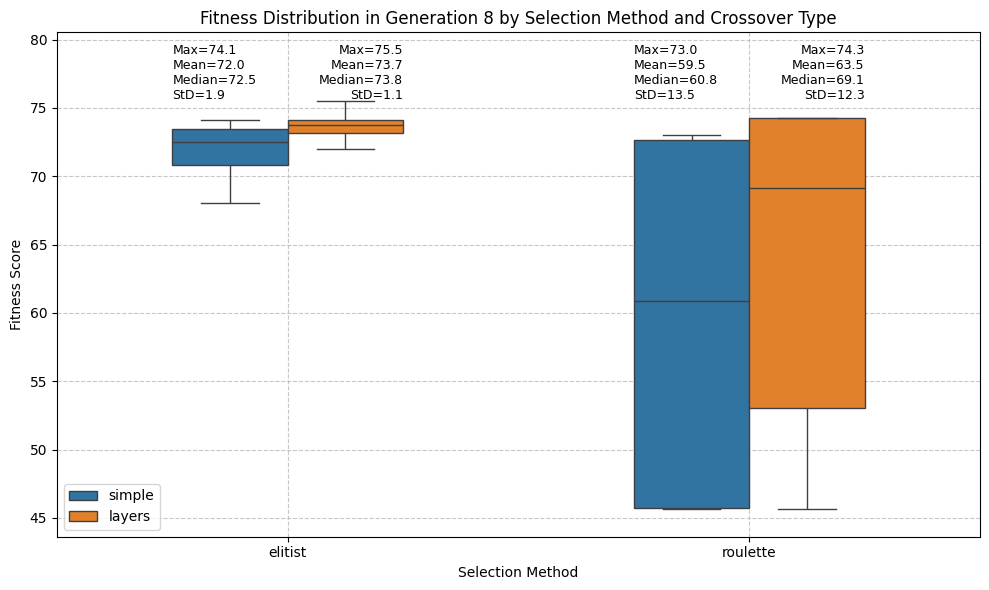


Numerical Summary for Generation 5 (excluding zero fitness):
                          mean    std    min    max
Method   Crossover Type                            
elitist  layers          73.69   1.14  72.00  75.53
         simple          71.98   1.86  68.06  74.09
roulette layers          63.52  12.32  45.66  74.28
         simple          59.55  13.55  45.62  73.03


In [ ]:
gen = num_generations
curr_df = comb_df[(comb_df['Generation'] == gen) & (comb_df['Fitness'] > 0)]
selection_methods = ['elitist', 'roulette']
crossover_methods = ['simple', 'layers']

visualize_method_x_crossover(curr_df, gen, selection_methods, crossover_methods)

Now let's check if the differences are significant.

Since the sample size is small, we will use the non-parametric **Pairwise Mann-Whitney U test with Bonferroni correction**:

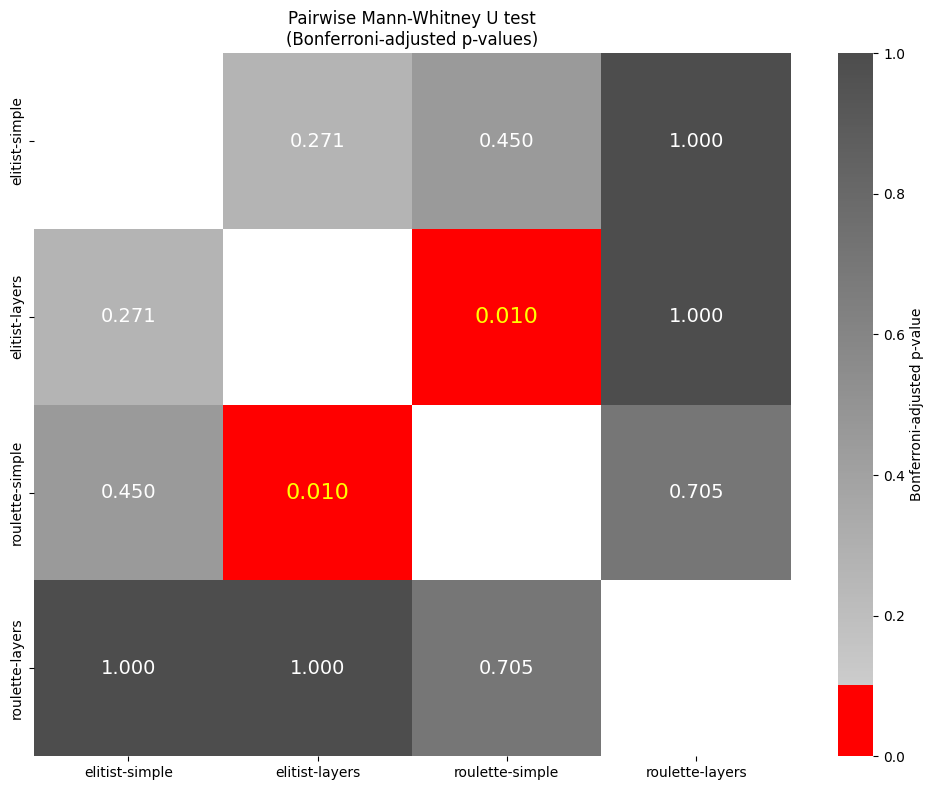

In [ ]:
# Create all group names
groups = ['elitist-simple', 'elitist-layers', 'roulette-simple', 'roulette-layers']
curr_df = comb_df[(comb_df['Generation'] == gen) & (comb_df['Fitness'] > 0)]
plot_heatmap_pairwise_mannwhitney(curr_df, groups)

It is important to note that what we are most interested in are the highest fitness values:

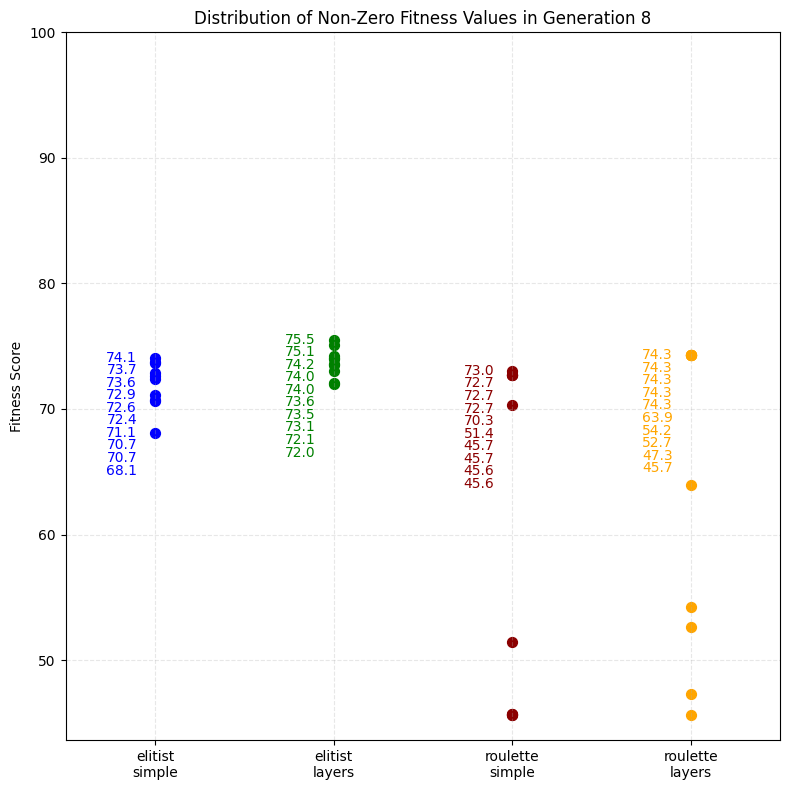

In [ ]:
gen = num_generations
curr_df = comb_df[(comb_df['Generation'] == gen) & (comb_df['Fitness'] > 0)]

groups = [('elitist', 'simple'), ('elitist', 'layers'), ('roulette', 'simple'), ('roulette', 'layers')]

# Define colors for each group
colors = {
    ('elitist', 'simple'): 'blue',
    ('elitist', 'layers'): 'green',
    ('roulette', 'simple'): 'darkred',
    ('roulette', 'layers'): 'orange'
}

plot_gen_values(curr_df, gen, colors)

Next, let's see how the evolution proceeded.

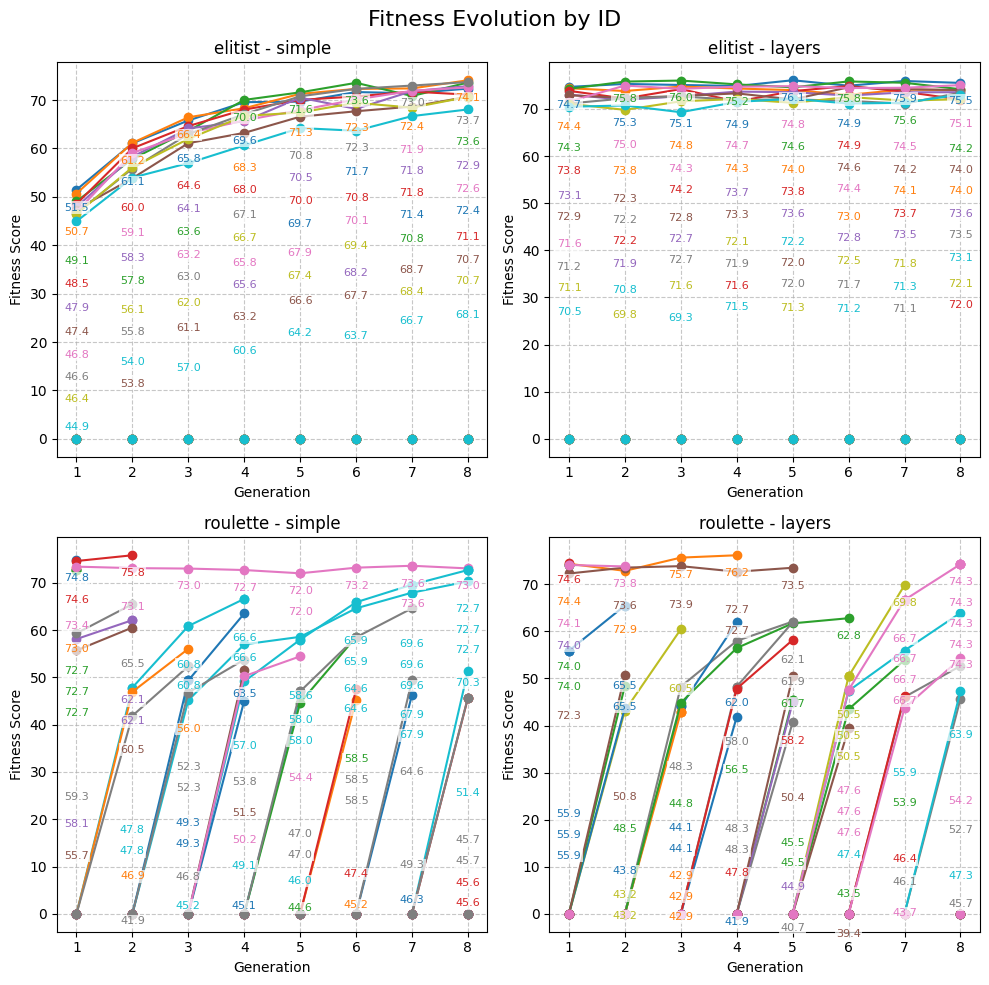

In [ ]:
curr_df = comb_df[comb_df['Method'].ne('') & comb_df['Crossover Type'].ne('')].copy()

plot_evo_paths(curr_df)

The **evolutionary effort**, calculated as

[number of generations] x [number of training epochs] x [population], is

In [ ]:
evo_effort = num_generations * num_train_epochs * population_size
print(f'{num_generations} x {num_train_epochs} x {population_size} = {evo_effort}')

8 x 7 x 20 = 1120


### Compare to a standard architecture for CIFAR-10

We will compare the performance of the evolutionary paradigm in experiments 2.1 and 2.2 to the EfficientNet-like architecture that has been suggested for CIFAR-10 (see <a href='https://ieeexplore.ieee.org/document/726791'>Tan and Le "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks." Proceedings of the 36 th International Conference on Machine
Learning (2019)</a>
)

In [ ]:
def generate_efficientnet_like_architecture():
    return {
        'input_shape': (3, 32, 32),
        'conv_layers': [
            # Entry flow
            {
                'out_channels': 32,
                'kernel_size': 3,
                'padding': 1,
                'activation': 'relu',
                'pooling': None
            },
            # MBConv1, k3x3
            {
                'out_channels': 16,
                'kernel_size': 3,
                'padding': 1,
                'activation': 'relu',
                'pooling': {'type': 'max', 'size': 2}
            },
            # MBConv6, k3x3
            {
                'out_channels': 24,
                'kernel_size': 3,
                'padding': 1,
                'activation': 'relu',
                'pooling': {'type': 'max', 'size': 2}
            },
            # Final stages
            {
                'out_channels': 40,
                'kernel_size': 3,
                'padding': 1,
                'activation': 'relu',
                'pooling': {'type': 'max', 'size': 2}
            }
        ],
        'fc_layers': [
            {
                'out_features': 512,
                'activation': 'relu'
            },
            {
                'out_features': 10,
                'activation': None
            }
        ]
    }

In [ ]:
print(f'Creating {population_size} models based on EfficientNet-like architecture...')
population0 = []
while len(population0) < population_size:
    entity = NN(generate_efficientnet_like_architecture(), input_height=input_height, input_width=input_width)
    if entity._viable:
        population0.append(entity)
    else:
        print(f'Entity {entity._id} is not viable:')
        print(ind.network_architecture)

Creating 20 models based on EfficientNet-like architecture...


In order to offer fair comparison, the numebr of epochs to train non-evolved models would be calculated as [evolutionary effort in previous experiments] / [populaiton size]:

In [ ]:
num_non_evo_train_epochs = evo_effort // population_size
print(num_non_evo_train_epochs)

15


In [ ]:
print(f'Training each model for {num_non_evo_train_epochs} epochs...')
for ind in population0:
    ind.fitness_score = evaluate_fitness(ind, train_loader, test_loader, num_epochs=num_non_evo_train_epochs)
    print(f'\nIndividual {ind._id}: {ind.fitness_score}')
    comb_df.loc[len(comb_df)] = {
        'ID': str(ind._id),
        'Fitness': ind.fitness_score,
        'ParentIDs': [],
        'Generation': 999,
        'Method': '',
        'Crossover Type': ''
    }

Training each model for 15 epochs...

Individual 52601647-c462-4fac-abba-c32f1b2fdd61: 96.0

Individual fd4c0e5e-5267-4abb-843f-809349bae9a0: 96.96875

Individual eebd0000-58c9-4de9-9d5d-5c5b6d03d2fa: 96.09375

Individual 151fe891-1f9d-4281-a39c-8db9344ae38f: 96.5

Individual 55d5e9c6-2932-4f8d-bd57-b75d4b71046b: 95.96875

Individual 33bdb4f3-2a54-484e-9b88-8de7e2136d36: 96.84375

Individual eccbc7e4-6d44-42f6-bcfd-e32145a9f79b: 96.4375

Individual 11b67f65-4fb0-4d47-93f6-410f270ceec3: 96.28125

Individual e20875b4-cfdf-4aef-87f6-bb55bda5b52b: 96.46875

Individual 1b1bd1ec-2103-46de-a939-2239fc020dc5: 96.28125

Individual 8ec4bd50-abb4-481c-a4b0-6d219b996896: 96.96875

Individual b01db17a-3c10-432b-8dd3-617ee3934713: 97.21875

Individual 20a09fae-7990-461f-bbfc-d6b0ad9cb4af: 96.3125

Individual dadf467e-990c-4930-9702-6b9d371864e3: 96.96875

Individual bec89bd2-8b10-4557-9ee2-cc5cc1c17d29: 96.15625


### Comparison and analysis

In [ ]:
# Get data for the comparison chart
colors = {
    ('elitist', 'simple'): 'blue',
    ('elitist', 'layers'): 'green',
    ('roulette', 'simple'): 'red',
    ('roulette', 'layers'): 'orange',
    ('',''): 'purple'}

# Filter for generations 5 and 999
filtered_df = comb_df[comb_df['Generation'].isin([gen, 999])]

result_list = []

# Add the subsets for each method-crossover combination for generation 5
for (method, crossover), color in colors.items():
    if method != '' and crossover != '':  # Skip the empty combination for now
        subset = filtered_df[
            (filtered_df['Method'] == method) &
            (filtered_df['Crossover Type'] == crossover) &
            (filtered_df['Generation'] == gen)
        ]
        if not subset.empty:
            # Get top num_top_surv by fitness
            top_subset = subset.nlargest(num_top_surv, 'Fitness')
            result_list.append([
                top_subset,
                color,
                f'{method} {crossover}'
            ])

# Add the subset for generation 999 (empty method and crossover type)
baseline_subset = filtered_df[
    (filtered_df['Method'] == '') &
    (filtered_df['Crossover Type'] == '') &
    (filtered_df['Generation'] == 999)
]
if not baseline_subset.empty:
    # Get top num_top_surv by Fitness
    top_baseline = baseline_subset.nlargest(num_top_surv, 'Fitness')
    result_list.append([
        top_baseline,
        'purple',
        'baseline'
    ])

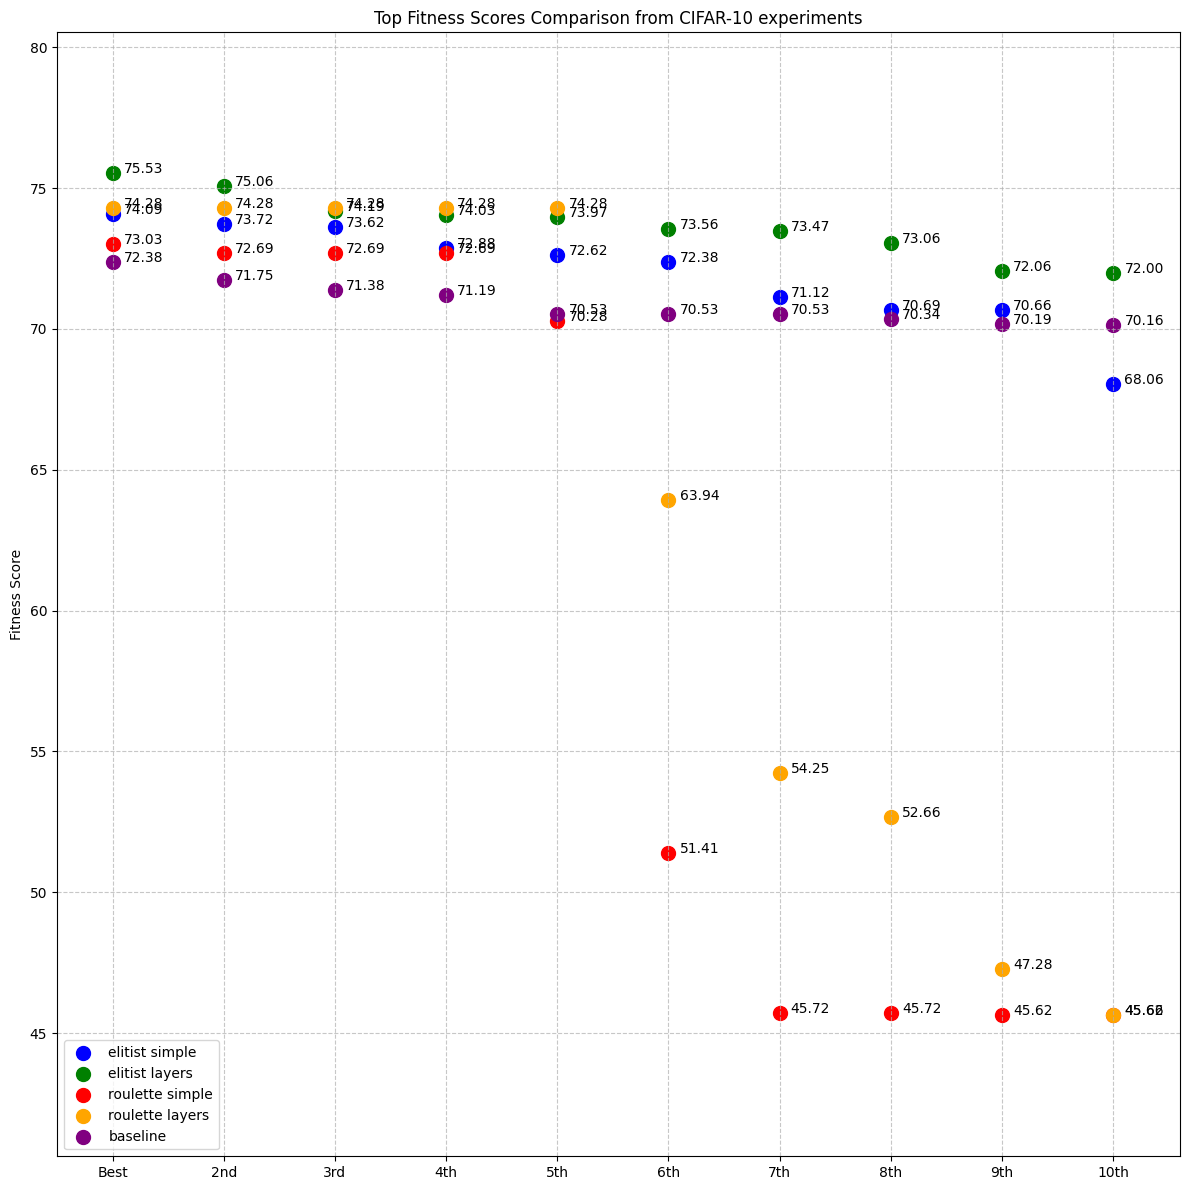

In [ ]:
plt.figure(figsize=(12, 12))

# Plot with labels for legend
min_fitness = float('inf')  # Initialize with infinity
max_fitness = 0
for d in result_list:
   fitness_values = d[0]['Fitness'].values
   min_fitness = min(min_fitness, min(fitness_values))  # Track minimum fitness
   max_fitness = max(max_fitness, max(fitness_values))  # Track maximum fitness
   for i, fitness in enumerate(fitness_values):
       plt.scatter([i+1], [fitness], color=d[1], s=100, label=d[2] if i == 0 else "")
       plt.annotate(f'{fitness:.2f}', (i+1.1, fitness))

plt.ylabel('Fitness Score')

positions = list(range(1, num_top_surv + 1))
labels = ['Best'] + [f'{i}nd' if i == 2 else f'{i}rd' if i == 3 else f'{i}th' for i in range(2, num_top_surv + 1)]
plt.xticks(positions, labels)

plt.title('Top Fitness Scores Comparison from CIFAR-10 experiments')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlim(0.5, num_top_surv + 0.6)
plt.ylim(min_fitness - 5, max_fitness + 5)  # Set y-axis from lowest value minus 5 to 100

plt.tight_layout()

plt.legend(loc='lower left')

# Show the plot
plt.show()

Now let's analyze the differences statistically. As we have a very small sample and we do not know the underlying distribution, pairwise **Mann-Whitney U tests with a Bonferroni correction** would be appropriate.

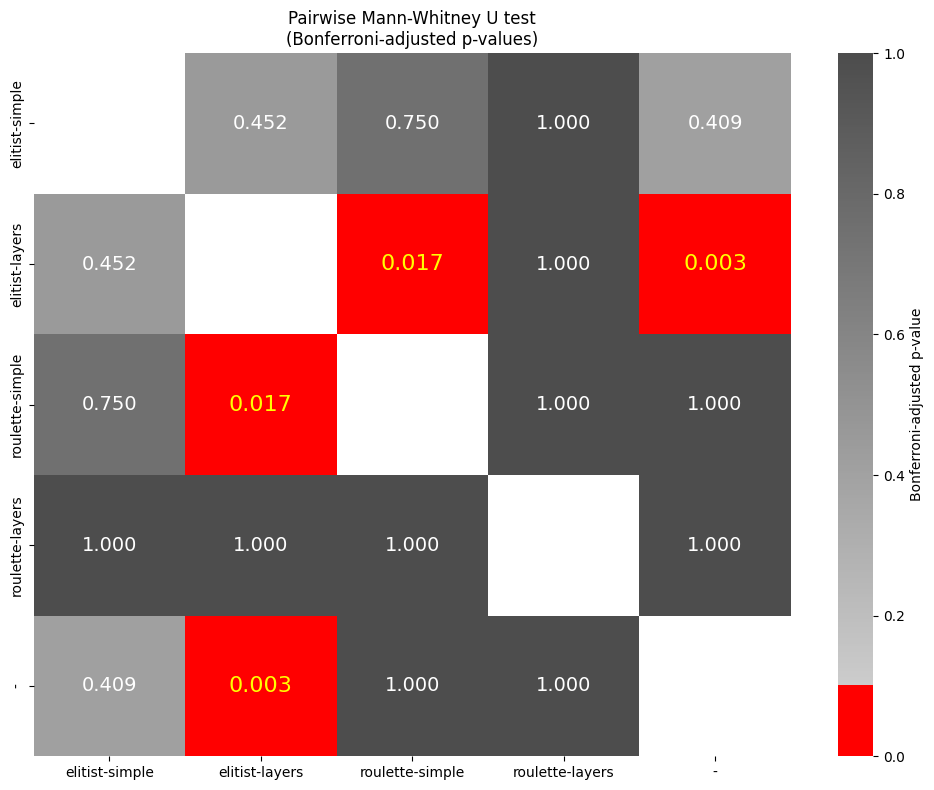

In [ ]:
# Create a new DataFrame combining all the data from result_list
combined_df = pd.DataFrame()
for df, color, label in result_list:
    # Split the label to get method and crossover type
    if label == 'baseline':
        method, crossover = '', ''
    else:
        method, crossover = label.split()

    # Add method and crossover type to the DataFrame
    df_copy = df.copy()
    df_copy['Method'] = method
    df_copy['Crossover Type'] = crossover
    combined_df = pd.concat([combined_df, df_copy], ignore_index=True)

# Create groups list
groups = [d[2].replace(' ', '-') if d[2] != 'baseline' else '-' for d in result_list]

# Call the function
plot_heatmap_pairwise_mannwhitney(combined_df, groups)

<font color=blue>
<u>Results:</u>
<ul>
<li>The Elitist selection method with crossover performs better than both the Roulette method without crossover and the Baseline architecture.
<li>The differnece in performance between different evolutionary methods seems as pronounced for the four top-performing evolved architectures, even though it is not feasible to ascertain that statistically due to the small number of samples.
</font>